<a href="https://colab.research.google.com/github/Limeo131/portal-innovation/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

import requests
import json
import pandas as pd
from itertools import chain
import time
import concurrent.futures
from requests.exceptions import HTTPError
import json
import ast
import re
import zipfile
import string

import matplotlib.pyplot as plot
import numpy as np

!pip install transformers
!pip install keyphrasetransformer
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer

#download and define embedding model
model = SentenceTransformer('allenai-specter')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
##################### read data #####################

# Connect notebook to Drive (left panel) by mounting drive

people_by = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/baylor_people_year0.csv')
people_gt = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/gtech_people.csv')
people_hp = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/hopkins_people.csv')

#people_1 = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/people.csv')

grants_by = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/baylor_grants.csv')
grants_gt = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/gtech_grants.csv')
grants_hp = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/hopkins_grants.csv')

# papers = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/papers.csv')
papers_by = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/unrolled_papers_df.csv')
papers_gt = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/gtech_papers.csv')
papers_hp = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/hopkins_papers.csv')

papers_1s = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/1s/ones_unrolled_papers_df.csv')


companies_by = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/baylor_companies.csv')
companies_gt = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/gtech_companies.csv')
companies_hp = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/hopkins_companies.csv')

companies_1s = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/1s/id_search.csv')


patents_by = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/baylor_inventors.csv')
patents_gt = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/gtech_inventors.csv')
patents_hp = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/extra data/hopkins_inventors.csv')

patents_1s = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/1s/ones_inventors.csv')



sample_inventors = pd.read_csv('/content/drive/MyDrive/portal_innovation/data/sample_inventors_with_startups_baylor.csv')
sample_inventors=sample_inventors.fillna(0)




In [ ]:
##################### combine data #####################

people = pd.concat([pd.DataFrame(people_by), pd.DataFrame(people_gt), pd.DataFrame(people_hp)], axis=0)
people = people.reset_index(drop=True)

grants = pd.concat([pd.DataFrame(grants_by), pd.DataFrame(grants_gt), pd.DataFrame(grants_hp)], axis=0)
grants = grants.reset_index(drop=True)

papers = pd.concat([pd.DataFrame(papers_by), pd.DataFrame(papers_gt), pd.DataFrame(papers_hp)], axis=0)
papers = papers.reset_index(drop=True)

companies = pd.concat([pd.DataFrame(companies_by), pd.DataFrame(companies_gt), pd.DataFrame(companies_hp)], axis=0)
companies = companies.reset_index(drop=True)

patents = pd.concat([pd.DataFrame(patents_by), pd.DataFrame(patents_gt), pd.DataFrame(patents_hp)], axis=0)
patents = patents.reset_index(drop=True)

patents['portal_index_id'] = patents['portal_index_id'].str.strip("[]").str.replace("'", "")
grants['portal_index_id'] = grants['portal_index_id'].str.strip("[]").str.replace("'", "")
papers['portal_index_id'] = papers['portal_index_id'].str.strip("[]").str.replace("'", "")

grants = grants.dropna(subset=['project_start_date'])
grants = grants.dropna(subset=['project_end_date'])


In [ ]:
##################### clean company data (portal_index_id) #####################

for i in range(len(companies['portal_index_id'])):
    id = companies['portal_index_id'].iloc[i]
    if id.count('[') > 0:
        if id.count(',') > 0:
            if id[2:13] != id[17:28]:
                new_index = len(companies)  # Get the index label for the new row
                companies.loc[new_index] = companies.iloc[i]  # Append a new row with the same values
                companies.at[i, 'portal_index_id'] = id[2:13]  # Modify the value using .at[]
                companies.at[new_index, 'portal_index_id'] = id[17:28]
            else:
                companies.at[i, 'portal_index_id'] = id[2:13]  # Modify the value using .at[]
        else:
            companies.at[i, 'portal_index_id'] = id[2:13]  # Modify the value using .at[]


# Sort the DataFrame by 'Raised to Date ($MM)' in descending order
companies_sorted = companies.sort_values(by='Raised to Date ($MM)', ascending=False)
# Drop duplicate rows based on 'portal_index_id', keeping the first occurrence (highest 'Raised to Date ($MM)')
companies_unique = companies_sorted.drop_duplicates(subset='portal_index_id', keep='first')
companies_unique=companies_unique.dropna(subset=['Year Founded'])
companies_unique.reset_index(drop=True, inplace=True)


for i in range(len(companies_unique)):
    if pd.isna(companies_unique['Most Recent Valuation (MM)'].loc[i]):
        companies_unique.loc[companies_unique['Most Recent Valuation (MM)'].isna(), 'Most Recent Valuation (MM)'] = companies_unique['Raised to Date ($MM)']

In [ ]:
##################### combine company data #####################

companies_1s = companies_1s.dropna(subset=['OA ID'])
companies_1s.reset_index(drop=True, inplace=True)
companies_1s['OA ID'] = companies_1s['OA ID'].str.replace('a', 'A')
companies_1s.columns = ['Inventors', 'University', 'Company', 'Raised to Date ($MM)','portal_index_id', 'Year Founded']


companies_1s['Year Founded'] = companies_1s['Year Founded'].str.split(',').str[0].str.strip()
companies_1s['Year Founded'] = companies_1s['Year Founded'].astype(float)


common_columns = companies_1s.columns.tolist()
companies_unique = pd.DataFrame(companies_unique)
companies_1s = pd.DataFrame(companies_1s)

# Add missing columns to DataFrame B
for col in companies_unique.columns:
    if col not in companies_1s.columns:
        companies_1s[col] = pd.NA

# Reorder DataFrame B columns to match DataFrame A
companies_1s = companies_1s[companies_unique.columns]

# Concatenate DataFrames
companies_merged = pd.concat([companies_unique, companies_1s], ignore_index=True)


<ipython-input-67-f34b5279dc55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies_1s['OA ID'] = companies_1s['OA ID'].str.replace('a', 'A')
<ipython-input-67-f34b5279dc55>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies_1s['Year Founded'] = companies_1s['Year Founded'].str.split(',').str[0].str.strip()
<ipython-input-67-f34b5279dc55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [ ]:
##################### combine paper data #####################

common_columns = papers_1s.columns.tolist()
papers = pd.DataFrame(papers)
papers_1s = pd.DataFrame(papers_1s)

# Add missing columns to DataFrame B
for col in papers.columns:
    if col not in papers_1s.columns:
        papers_1s[col] = pd.NA

# Reorder DataFrame B columns to match DataFrame A
papers_1s = papers_1s[papers.columns]

# Concatenate DataFrames
papers_merged = pd.concat([papers, papers_1s], ignore_index=True)


In [ ]:
##################### combine patent data #####################

common_columns = patents_1s.columns.tolist()
patents = pd.DataFrame(patents)
patents_1s = pd.DataFrame(patents_1s)

# Add missing columns to DataFrame B
for col in patents.columns:
    if col not in patents_1s.columns:
        patents_1s[col] = pd.NA

# Reorder DataFrame B columns to match DataFrame A
patents_1s = patents_1s[patents.columns]

# Concatenate DataFrames
patents_merged = pd.concat([patents, patents_1s], ignore_index=True)


In [ ]:
##################### combine people data #####################

people_1s = pd.DataFrame()
people_1s['name'] = companies_1s['Inventors']
people_1s['portal_index_id'] = companies_1s['portal_index_id']
people_1s['institution'] = companies_1s['University']
people_1s['institution'] = companies_1s['University']

common_columns = people_1s.columns.tolist()
people = pd.DataFrame(people)
people_1s = pd.DataFrame(people_1s)

# Add missing columns to DataFrame B
for col in people.columns:
    if col not in people_1s.columns:
        people_1s[col] = pd.NA

# Reorder DataFrame B columns to match DataFrame A
people_1s = people_1s[people.columns]

# Concatenate DataFrames
people_merged = pd.concat([people, people_1s], ignore_index=True)


In [ ]:
##################### prepare people data #####################


people_merged['portal_index_id'] = people_merged['portal_index_id'].astype(str)
papers_merged['portal_index_id'] = papers_merged['portal_index_id'].astype(str)
papers_merged['publication_year'] = papers_merged['publication_year'].astype(int)

# Merge the DataFrames on the portal_index_id
merged_df = pd.merge(people_merged, papers_merged, on='portal_index_id')

# Group by portal_index_id and find the earliest publication year
earliest_publication_years = merged_df.groupby('portal_index_id')['publication_year'].min().reset_index()

# Rename the column for clarity
earliest_publication_years.rename(columns={'publication_year': 'earliest_consecutive_year'}, inplace=True)

# Identify rows in people_df where the earliest_publication_year is NaN
people_nan = people_merged[people_merged['earliest_consecutive_year'].isna()]


# Merge the earliest publication years back into the subset where it is NaN
people_nan_updated = pd.merge(people_nan[['portal_index_id',  'earliest_consecutive_year']],
                              earliest_publication_years,
                              on='portal_index_id',
                              how='left')

people_nan_updated.drop(columns=['earliest_consecutive_year_x'],inplace=True)
people_nan_updated.rename(columns={'earliest_consecutive_year_y': 'earliest_consecutive_year'}, inplace=True)

updated_people = pd.merge(
    people_merged,
    people_nan_updated,
    on='portal_index_id',
    how='left',
    suffixes=('', '_new')
)


# Update only NaN values in 'earliest_consecutive_year' with 'earliest_consecutive_year_new'
updated_people['earliest_consecutive_year'] = updated_people['earliest_consecutive_year'].combine_first(
    updated_people['earliest_consecutive_year_new'])

# Drop the helper column 'earliest_consecutive_year_new'
updated_people.drop(columns=['earliest_consecutive_year_new'], inplace=True)

updated_people['earliest_consecutive_year'] = updated_people['earliest_consecutive_year']-1
people_merged  = updated_people

In [ ]:
##################### prepare people data #####################

people_mereged = people.dropna(subset=['earliest_consecutive_year'])
people_mereged.drop_duplicates(subset='portal_index_id', keep='first', inplace=True)
people_mereged.reset_index(drop=True, inplace=True)

people_merged['career length'] = 2023-people_merged['earliest_consecutive_year']+1

people_merged = pd.merge(people_merged, companies_merged[['portal_index_id', 'Year Founded']], on='portal_index_id', how='left')

people_merged['company prep'] = people_merged['Year Founded']-people_merged['earliest_consecutive_year']


<ipython-input-72-f71aeb26bec6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  people_mereged.drop_duplicates(subset='portal_index_id', keep='first', inplace=True)


In [ ]:
##################### remove data after Year Founded for 1s #####################

# Merge the patents_merged with companies_merged on portal_index_id
merged_df = pd.merge(patents_merged, companies_merged[['portal_index_id', 'Year Founded']], on='portal_index_id', how='left')
# Filter out the patents where publication_year is greater than year_founded for scientists with companies
filtered_df = merged_df.loc[(merged_df['publication_year'] <= merged_df['Year Founded']) | (merged_df['Year Founded'].isna())].copy()
# Drop the year_founded column as it's no longer needed
filtered_df.drop(columns=['Year Founded'], inplace=True)
# Result is the filtered patents DataFrame
filtered_patents_merged = filtered_df

filtered_patents_merged.reset_index(drop=True, inplace=True)



# Merge the patents_merged with companies_merged on portal_index_id
merged_df = pd.merge(papers_merged, companies_merged[['portal_index_id', 'Year Founded']], on='portal_index_id', how='left')
# Filter out the patents where publication_year is greater than year_founded for scientists with companies
filtered_df = merged_df.loc[(merged_df['publication_year'] <= merged_df['Year Founded']) | (merged_df['Year Founded'].isna())].copy()
# Drop the year_founded column as it's no longer needed
filtered_df.drop(columns=['Year Founded'], inplace=True)
# Result is the filtered patents DataFrame
filtered_papers_merged = filtered_df

filtered_papers_merged.reset_index(drop=True, inplace=True)



# Merge the patents_merged with companies_merged on portal_index_id
merged_df = pd.merge(grants, companies_merged[['portal_index_id', 'Year Founded']], on='portal_index_id', how='left')
# Filter out the patents where publication_year is greater than year_founded for scientists with companies
filtered_df = merged_df.loc[(merged_df['fiscal_year'] <= merged_df['Year Founded']) | (merged_df['Year Founded'].isna())].copy()
# Drop the year_founded column as it's no longer needed
filtered_df.drop(columns=['Year Founded'], inplace=True)
# Result is the filtered patents DataFrame
filtered_grants_merged = filtered_df

filtered_grants_merged.reset_index(drop=True, inplace=True)



In [ ]:
################## all the data I will use

############## people_merged
############## filtered_papers_merged
############## filtered_patents_merged
############## companies_merged
############## filtered_grants_merged


In [ ]:
##################### variables for 1s #####################

import pandas as pd

variables_1 = pd.DataFrame(index=people_merged.index)
variables_1['portal_index_id'] = people_merged['portal_index_id']
variables_1['career length'] = people_merged['career length']

short_career_condition = people_merged['career length'] <= 0
long_career_condition = ~short_career_condition

paper_min = people_merged.groupby('portal_index_id')['earliest_consecutive_year'].min()
paper_min = paper_min.reindex(people_merged['portal_index_id'], fill_value=2018)

#papers_merged_filtered = papers_merged[papers_merged['portal_index_id'].isin(paper_min.index)]

############################ Calculate paper frequency

short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(2018).sum() / (2023 - x.min() + 1)))
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_frequency.index)]
missing_short_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_frequency = short_career_frequency.combine_first(missing_short_ids_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.count() / people_merged.loc[people_merged['portal_index_id']==x.name, 'company prep'].iloc[0]) )
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_frequency.index)]
missing_long_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_frequency = long_career_frequency.combine_first(missing_long_ids_freq)


combined_frequencies = short_career_frequency.combine_first(long_career_frequency)
variables_1['paper frequency'] = variables_1['portal_index_id'].map(combined_frequencies)


############################ Calculate paper citation frequency
short_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / (2023 - x.index.min() + 1))
)
missing_short_citation_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_citation_frequency = short_career_citation_frequency.combine_first(missing_short_citation_ids_freq)

long_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / people_merged.loc[people_merged['portal_index_id']==x.name, 'company prep'].iloc[0])
)
missing_long_citation_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_citation_frequency = long_career_citation_frequency.combine_first(missing_long_citation_ids_freq)

combined_citation_frequencies = short_career_citation_frequency.combine_first(long_career_citation_frequency)
variables_1['paper citation frequency'] = variables_1['portal_index_id'].map(combined_citation_frequencies)


############################ Calculate paper citation per paper
short_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[x['publication_year'] >= 2018]['forward_citations'].sum() /
                     x[x['publication_year'] >= 2018]['publication_year'].count() if x[x['publication_year'] >= 2018]['publication_year'].count() > 0 else 0)
)
missing_short_citation_per_paper_ids = short_career_ids[~short_career_ids.isin(short_career_citation_per_paper.index)]
missing_short_citation_per_paper_freq = pd.Series(0, index=missing_short_citation_per_paper_ids)
short_career_citation_per_paper = short_career_citation_per_paper.combine_first(missing_short_citation_per_paper_freq)

long_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x['forward_citations'].sum() /
                     x['publication_year'].count() if x['publication_year'].count() > 0 else 0)
)
missing_long_citation_per_paper_ids = long_career_ids[~long_career_ids.isin(long_career_citation_per_paper.index)]
missing_long_citation_per_paper_freq = pd.Series(0, index=missing_long_citation_per_paper_ids)
long_career_citation_per_paper = long_career_citation_per_paper.combine_first(missing_long_citation_per_paper_freq)

combined_citation_per_paper_frequencies = short_career_citation_per_paper.combine_first(long_career_citation_per_paper)
variables_1['paper citation per paper'] = variables_1['portal_index_id'].map(combined_citation_per_paper_frequencies)



############################ Calculate grant number frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).ge(2018).count() / (2023 - x.str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_frequency.index)]
missing_short_grant_freq = pd.Series(0, index=missing_short_ids)
short_career_grant_frequency = short_career_grant_frequency.combine_first(missing_short_grant_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).count() / people_merged.loc[people_merged['portal_index_id']==x.name, 'company prep'].iloc[0])
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_frequency.index)]
missing_long_grant_freq = pd.Series(0, index=missing_long_ids)
long_career_grant_frequency = long_career_grant_frequency[~long_career_grant_frequency.index.duplicated(keep='first')]
missing_long_grant_freq = missing_long_grant_freq[~missing_long_grant_freq.index.duplicated(keep='first')]
long_career_grant_frequency = long_career_grant_frequency.combine_first(missing_long_grant_freq)

combined_grant_frequencies = short_career_grant_frequency.combine_first(long_career_grant_frequency)
variables_1['grant number'] = variables_1['portal_index_id'].map(combined_grant_frequencies)


############################ Calculate grant money frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= 2018].sum() / (2023 - 2018 + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money.index)]
missing_short_grant_money = pd.Series(0, index=missing_short_ids)
short_career_grant_money = short_career_grant_money.combine_first(missing_short_grant_money)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x.sum() / people_merged.loc[people_merged['portal_index_id']==x.name, 'company prep'].iloc[0])
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money.index)]
missing_long_grant_money = pd.Series(0, index=missing_long_ids)
long_career_grant_money = long_career_grant_money[~long_career_grant_money.index.duplicated(keep='first')]
missing_long_grant_money = missing_long_grant_money[~missing_long_grant_money.index.duplicated(keep='first')]
long_career_grant_money = long_career_grant_money.combine_first(missing_long_grant_money)

# Combine grant money frequencies and map to DataFrame
combined_grant_money = short_career_grant_money.combine_first(long_career_grant_money)
variables_1['grant money'] = variables_1['portal_index_id'].map(combined_grant_money)



############################ Calculate grant money per grant
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= 2018].sum())
)
short_career_grant_count = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).ge(2018).sum())
)
short_career_grant_money_per_grant = short_career_grant_money_sum / short_career_grant_count
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money_per_grant.index)]
missing_short_grant_money_per_grant = pd.Series(0, index=missing_short_ids)
short_career_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(missing_short_grant_money_per_grant)

# Calculate grant money per grant for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x.sum())
)
long_career_grant_count = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).count())
)
long_career_grant_money_per_grant = long_career_grant_money_sum / long_career_grant_count
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money_per_grant.index)]
missing_long_grant_money_per_grant = pd.Series(0, index=missing_long_ids)
long_career_grant_money_per_grant = long_career_grant_money_per_grant[~long_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_long_grant_money_per_grant = missing_long_grant_money_per_grant[~missing_long_grant_money_per_grant.index.duplicated(keep='first')]
long_career_grant_money_per_grant = long_career_grant_money_per_grant.combine_first(missing_long_grant_money_per_grant)

combined_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(long_career_grant_money_per_grant)
variables_1['grant money per grant'] = variables_1['portal_index_id'].map(combined_grant_money_per_grant)



############################ Calculate grant series

# Function to calculate grant series counts
def calculate_grant_series(grants, career_ids, paper_min, series_code):
    return (
        grants[grants['portal_index_id'].isin(career_ids) & grants['activity_code'].str.startswith(series_code)]
        .groupby('portal_index_id')['award_amount']
        .apply(lambda x: (
            x.count()
        ))
    )

# Clean the portal_index_id column in grants
grants['portal_index_id'] = grants['portal_index_id'].str.strip("[]").str.replace("'", "")

# Calculate grant series for short careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
grant_series_u_short = calculate_grant_series(grants, short_career_ids, paper_min, 'U')
grant_series_r_short = calculate_grant_series(grants, short_career_ids, paper_min, 'R')
grant_series_t_short = calculate_grant_series(grants, short_career_ids, paper_min, 'T')
grant_series_p_short = calculate_grant_series(grants, short_career_ids, paper_min, 'P')

# Calculate grant series for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
grant_series_u_long = calculate_grant_series(grants, long_career_ids, paper_min, 'U')
grant_series_r_long = calculate_grant_series(grants, long_career_ids, paper_min, 'R')
grant_series_t_long = calculate_grant_series(grants, long_career_ids, paper_min, 'T')
grant_series_p_long = calculate_grant_series(grants, long_career_ids, paper_min, 'P')

# Combine short and long career grant series
grant_series_u = grant_series_u_short.combine_first(grant_series_u_long)
grant_series_r = grant_series_r_short.combine_first(grant_series_r_long)
grant_series_t = grant_series_t_short.combine_first(grant_series_t_long)
grant_series_p = grant_series_p_short.combine_first(grant_series_p_long)

# Map combined series to variables_1 DataFrame
variables_1['grant series_u'] = variables_1['portal_index_id'].map(grant_series_u).fillna(0)
variables_1['grant series_r'] = variables_1['portal_index_id'].map(grant_series_r).fillna(0)
variables_1['grant series_t'] = variables_1['portal_index_id'].map(grant_series_t).fillna(0)
variables_1['grant series_p'] = variables_1['portal_index_id'].map(grant_series_p).fillna(0)



############################ Calculate grant duration per grant
def calculate_grant_duration(grants, career_ids, paper_min):
    def duration_calc(group, min_year, is_short):
        if is_short:
            filtered = group[group['project_start_date'].str[:4].astype(int) >= 2018]
        else:
            filtered = group
        num = filtered['fiscal_year'].dropna().count()
        if num == 0:
            return 0
        end_sum = filtered['project_end_date'].str[:4].astype(int).sum()
        start_sum = filtered['project_start_date'].str[:4].astype(int).sum()
        return (end_sum - start_sum) / num

    def get_min_year(portal_index_id):
        return paper_min.get(portal_index_id, 2018)  # Use 2018 as default if portal_index_id is not in paper_min

    def get_is_short(portal_index_id):
        return short_career_condition.get(portal_index_id, False)  # Use False as default if portal_index_id is not in short_career_condition

    return (
        grants[grants['portal_index_id'].isin(career_ids)]
        .groupby('portal_index_id')
        .apply(lambda x: duration_calc(x, filtered_papers_merged['publication_year'].min(), get_is_short(x.name)))
    )

# Calculate grant duration per grant for short and long careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
long_career_ids = people_merged[long_career_condition]['portal_index_id']

short_career_grant_duration = calculate_grant_duration(grants, short_career_ids, paper_min)
long_career_grant_duration = calculate_grant_duration(grants, long_career_ids, paper_min)

# Combine short and long career grant durations
combined_grant_duration = short_career_grant_duration.combine_first(long_career_grant_duration)

# Map combined grant durations to variables_1 DataFrame
variables_1['grant duration per grant'] = variables_1['portal_index_id'].map(combined_grant_duration).fillna(0)



############################ Calculate author position
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first')]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle')]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last')]['publication_year'].count()
    ) / max((2023 - paper_min.loc[x.name] + 1), 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_author_position.index)]
missing_short_author_position = pd.Series(0, index=missing_short_ids)
short_career_author_position = short_career_author_position.combine_first(missing_short_author_position)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first')]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle')]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last')]['publication_year'].count()
    ) / people_merged.loc[people_merged['portal_index_id']==x.name, 'company prep'].iloc[0] ) )

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_author_position.index)]
missing_long_author_position = pd.Series(0, index=missing_long_ids)
long_career_author_position = long_career_author_position.combine_first(missing_long_author_position)

combined_author_position = short_career_author_position.combine_first(long_career_author_position)
variables_1['author position'] = variables_1['portal_index_id'].map(combined_author_position)




############################ Calculate is corresponding
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(2018).count() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_is_corresponding.index)]
missing_short_is_corresponding = pd.Series(0, index=missing_short_ids)
short_career_is_corresponding = short_career_is_corresponding.combine_first(missing_short_is_corresponding)

# Calculate is_corresponding for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.count() / people_merged.loc[people_merged['portal_index_id']==x.name, 'company prep'].iloc[0])
)

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_is_corresponding.index)]
missing_long_is_corresponding = pd.Series(0, index=missing_long_ids)
long_career_is_corresponding = long_career_is_corresponding[~long_career_is_corresponding.index.duplicated(keep='first')]
missing_long_is_corresponding = missing_long_is_corresponding[~missing_long_is_corresponding.index.duplicated(keep='first')]
long_career_is_corresponding = long_career_is_corresponding.combine_first(missing_long_is_corresponding)

# Combine is_corresponding scores and map to DataFrame
combined_is_corresponding = short_career_is_corresponding.combine_first(long_career_is_corresponding)
variables_1['is_corresponding'] = variables_1['portal_index_id'].map(combined_is_corresponding)






############################ Calculate patents frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(2018).count() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_patents_frequency.index)]
missing_short_patents_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_frequency = short_career_patents_frequency.combine_first(missing_short_patents_frequency)


long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.count() / people_merged.loc[people_merged['portal_index_id']==x.name, 'company prep'].iloc[0])
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_patents_frequency.index)]
missing_long_patents_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_frequency = long_career_patents_frequency [~long_career_patents_frequency .index.duplicated(keep='first')]
missing_long_patents_frequency = missing_long_patents_frequency[~missing_long_patents_frequency.index.duplicated(keep='first')]
long_career_patents_frequency = long_career_patents_frequency.combine_first(missing_long_patents_frequency)

combined_patents_frequency = short_career_patents_frequency.combine_first(long_career_patents_frequency)
variables_1['patents frequency'] = variables_1['portal_index_id'].map(combined_patents_frequency)



############################ Calculate patents citations frequency
short_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[filtered_patents_merged['publication_year'] >= 2018].sum() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_patents_citations_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(missing_short_patents_citations_frequency)

long_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x.sum() / people_merged.loc[people_merged['portal_index_id']==x.name, 'company prep'].iloc[0])
)
missing_long_patents_citations_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_citations_frequency = long_career_patents_citations_frequency [~long_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_long_patents_citations_frequency = missing_long_patents_citations_frequency[~missing_long_patents_citations_frequency.index.duplicated(keep='first')]
long_career_patents_citations_frequency = long_career_patents_citations_frequency.combine_first(missing_long_patents_citations_frequency)

combined_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(long_career_patents_citations_frequency)
variables_1['patents citations frequency'] = variables_1['portal_index_id'].map(combined_patents_citations_frequency)


# Merge the DataFrames on portal_index_id
merged_df = pd.merge(variables_1, companies_merged[['portal_index_id', 'Raised to Date ($MM)']], on='portal_index_id', how='left')
# Update the variables_1 DataFrame with the 'Raised to Date ($MM)' values
variables_1['Startup value (mm$)'] = merged_df['Raised to Date ($MM)']
# Optionally, fill NaN values with 0 if needed
variables_1['Startup value (mm$)'].fillna(0, inplace=True)


# Normalize 'Startup value (mm$)'
variables_1['Startup value (mm$)'] = variables_1['Startup value (mm$)'].str.replace(',', '').str.replace('$', '').str.strip().fillna('0').astype(float)

# Create 'Startup value_0/1' binary indicator
variables_1['Startup value_0/1'] = (variables_1['Startup value (mm$)'] > 5).astype(int)

variables_1.fillna(0, inplace=True)
variables_1.replace([np.inf, -np.inf], 0, inplace=True)




<ipython-input-75-df9361d773e2>:310: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.ge(2018).count() / (2023 - paper_min.loc[x.name] + 1))
<ipython-input-75-df9361d773e2>:344: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.ge(2018).count() / (2023 - paper_min.loc[x.name] + 1))
<ipython-input-75-df9361d773e2>:372: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x[filtered_patents_merged['publication_year'] >= 2018].sum() / (2023 - paper_min.loc[x.name] + 1))


In [ ]:
############################################# Year 0-5 for 0s ############################################

variables_0_5 = pd.DataFrame(index=people_merged.index)
variables_0_5['portal_index_id'] = people_merged['portal_index_id']
variables_0_5['career length'] = people_merged['career length']

short_career_condition = people_merged['career length'] <= 5
long_career_condition = ~short_career_condition

paper_min = people_merged.groupby('portal_index_id')['earliest_consecutive_year'].min()
paper_min = paper_min.reindex(people_merged['portal_index_id'], fill_value=2018)

#papers_merged_filtered = papers_merged[papers_merged['portal_index_id'].isin(paper_min.index)]

############################ Calculate paper frequency

short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(2018).count() / (2023 - x.min() + 1)))
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_frequency.index)]
missing_short_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_frequency = short_career_frequency.combine_first(missing_short_ids_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.lt(x.min() + 5).count() / 5))
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_frequency.index)]
missing_long_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_frequency = long_career_frequency.combine_first(missing_long_ids_freq)


combined_frequencies = short_career_frequency.combine_first(long_career_frequency)
variables_0_5['paper frequency'] = variables_0_5['portal_index_id'].map(combined_frequencies)


############################ Calculate paper citation frequency
short_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / (2023 - x.index.min() + 1))
)
missing_short_citation_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_citation_frequency = short_career_citation_frequency.combine_first(missing_short_citation_ids_freq)

long_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / 5)
)
missing_long_citation_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_citation_frequency = long_career_citation_frequency.combine_first(missing_long_citation_ids_freq)

combined_citation_frequencies = short_career_citation_frequency.combine_first(long_career_citation_frequency)
variables_0_5['paper citation frequency'] = variables_0_5['portal_index_id'].map(combined_citation_frequencies)


############################ Calculate paper citation per paper
short_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[x['publication_year'] >= 2018]['forward_citations'].sum() /
                     x[x['publication_year'] >= 2018]['publication_year'].count() if x[x['publication_year'] >= 2018]['publication_year'].count() > 0 else 0)
)
missing_short_citation_per_paper_ids = short_career_ids[~short_career_ids.isin(short_career_citation_per_paper.index)]
missing_short_citation_per_paper_freq = pd.Series(0, index=missing_short_citation_per_paper_ids)
short_career_citation_per_paper = short_career_citation_per_paper.combine_first(missing_short_citation_per_paper_freq)

long_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[x['publication_year'] < x['publication_year'].min() + 5]['forward_citations'].sum() /
                     x[x['publication_year'] < x['publication_year'].min() + 5]['publication_year'].count() if x[x['publication_year'] < x['publication_year'].min() + 5]['publication_year'].count() > 0 else 0)
)
missing_long_citation_per_paper_ids = long_career_ids[~long_career_ids.isin(long_career_citation_per_paper.index)]
missing_long_citation_per_paper_freq = pd.Series(0, index=missing_long_citation_per_paper_ids)
long_career_citation_per_paper = long_career_citation_per_paper.combine_first(missing_long_citation_per_paper_freq)

combined_citation_per_paper_frequencies = short_career_citation_per_paper.combine_first(long_career_citation_per_paper)
variables_0_5['paper citation per paper'] = variables_0_5['portal_index_id'].map(combined_citation_per_paper_frequencies)



############################ Calculate grant number frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).ge(2018).count() / (2023 - x.str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_frequency.index)]
missing_short_grant_freq = pd.Series(0, index=missing_short_ids)
short_career_grant_frequency = short_career_grant_frequency.combine_first(missing_short_grant_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).lt(x.str[:4].astype(int).min() + 5).count() / 5)
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_frequency.index)]
missing_long_grant_freq = pd.Series(0, index=missing_long_ids)
long_career_grant_frequency = long_career_grant_frequency[~long_career_grant_frequency.index.duplicated(keep='first')]
missing_long_grant_freq = missing_long_grant_freq[~missing_long_grant_freq.index.duplicated(keep='first')]
long_career_grant_frequency = long_career_grant_frequency.combine_first(missing_long_grant_freq)

combined_grant_frequencies = short_career_grant_frequency.combine_first(long_career_grant_frequency)
variables_0_5['grant number'] = variables_0_5['portal_index_id'].map(combined_grant_frequencies)


############################ Calculate grant money frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= 2018].sum() / (2023 - 2018 + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money.index)]
missing_short_grant_money = pd.Series(0, index=missing_short_ids)
short_career_grant_money = short_career_grant_money.combine_first(missing_short_grant_money)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + 5)].sum() / 5)
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money.index)]
missing_long_grant_money = pd.Series(0, index=missing_long_ids)
long_career_grant_money = long_career_grant_money[~long_career_grant_money.index.duplicated(keep='first')]
missing_long_grant_money = missing_long_grant_money[~missing_long_grant_money.index.duplicated(keep='first')]
long_career_grant_money = long_career_grant_money.combine_first(missing_long_grant_money)

# Combine grant money frequencies and map to DataFrame
combined_grant_money = short_career_grant_money.combine_first(long_career_grant_money)
variables_0_5['grant money'] = variables_0_5['portal_index_id'].map(combined_grant_money)



############################ Calculate grant money per grant
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= 2018].sum())
)
short_career_grant_count = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).ge(2018).count())
)
short_career_grant_money_per_grant = short_career_grant_money_sum / short_career_grant_count
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money_per_grant.index)]
missing_short_grant_money_per_grant = pd.Series(0, index=missing_short_ids)
short_career_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(missing_short_grant_money_per_grant)

# Calculate grant money per grant for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + 5)].sum())
)
long_career_grant_count = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).lt(x.str[:4].astype(int).min() + 5).count())
)
long_career_grant_money_per_grant = long_career_grant_money_sum / long_career_grant_count
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money_per_grant.index)]
missing_long_grant_money_per_grant = pd.Series(0, index=missing_long_ids)
long_career_grant_money_per_grant = long_career_grant_money_per_grant[~long_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_long_grant_money_per_grant = missing_long_grant_money_per_grant[~missing_long_grant_money_per_grant.index.duplicated(keep='first')]
long_career_grant_money_per_grant = long_career_grant_money_per_grant.combine_first(missing_long_grant_money_per_grant)

combined_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(long_career_grant_money_per_grant)
variables_0_5['grant money per grant'] = variables_0_5['portal_index_id'].map(combined_grant_money_per_grant)



############################ Calculate grant series

# Function to calculate grant series counts
def calculate_grant_series(grants, career_ids, paper_min, series_code):
    return (
        grants[grants['portal_index_id'].isin(career_ids) & grants['activity_code'].str.startswith(series_code)]
        .groupby('portal_index_id')['award_amount']
        .apply(lambda x: (
            x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= 2018].count()
            if filtered_papers_merged['publication_year'].min() > 2018 else
            x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (filtered_papers_merged['publication_year'].min() + 5)].count()
        ))
    )

# Clean the portal_index_id column in grants
grants['portal_index_id'] = grants['portal_index_id'].str.strip("[]").str.replace("'", "")

# Calculate grant series for short careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
grant_series_u_short = calculate_grant_series(grants, short_career_ids, paper_min, 'U')
grant_series_r_short = calculate_grant_series(grants, short_career_ids, paper_min, 'R')
grant_series_t_short = calculate_grant_series(grants, short_career_ids, paper_min, 'T')
grant_series_p_short = calculate_grant_series(grants, short_career_ids, paper_min, 'P')

# Calculate grant series for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
grant_series_u_long = calculate_grant_series(grants, long_career_ids, paper_min, 'U')
grant_series_r_long = calculate_grant_series(grants, long_career_ids, paper_min, 'R')
grant_series_t_long = calculate_grant_series(grants, long_career_ids, paper_min, 'T')
grant_series_p_long = calculate_grant_series(grants, long_career_ids, paper_min, 'P')

# Combine short and long career grant series
grant_series_u = grant_series_u_short.combine_first(grant_series_u_long)
grant_series_r = grant_series_r_short.combine_first(grant_series_r_long)
grant_series_t = grant_series_t_short.combine_first(grant_series_t_long)
grant_series_p = grant_series_p_short.combine_first(grant_series_p_long)

# Map combined series to variables_0_5 DataFrame
variables_0_5['grant series_u'] = variables_0_5['portal_index_id'].map(grant_series_u).fillna(0)
variables_0_5['grant series_r'] = variables_0_5['portal_index_id'].map(grant_series_r).fillna(0)
variables_0_5['grant series_t'] = variables_0_5['portal_index_id'].map(grant_series_t).fillna(0)
variables_0_5['grant series_p'] = variables_0_5['portal_index_id'].map(grant_series_p).fillna(0)



############################ Calculate grant duration per grant
def calculate_grant_duration(grants, career_ids, paper_min):
    def duration_calc(group, min_year, is_short):
        if is_short:
            filtered = group[group['project_start_date'].str[:4].astype(int) >= 2018]
        else:
            filtered = group[group['project_start_date'].str[:4].astype(int) < min_year + 5]
        num = filtered['fiscal_year'].dropna().count()
        if num == 0:
            return 0
        end_sum = filtered['project_end_date'].str[:4].astype(int).sum()
        start_sum = filtered['project_start_date'].str[:4].astype(int).sum()
        return (end_sum - start_sum) / num

    def get_min_year(portal_index_id):
        return paper_min.get(portal_index_id, 2018)  # Use 2018 as default if portal_index_id is not in paper_min

    def get_is_short(portal_index_id):
        return short_career_condition.get(portal_index_id, False)  # Use False as default if portal_index_id is not in short_career_condition

    return (
        grants[grants['portal_index_id'].isin(career_ids)]
        .groupby('portal_index_id')
        .apply(lambda x: duration_calc(x, filtered_papers_merged['publication_year'].min(), get_is_short(x.name)))
    )

# Calculate grant duration per grant for short and long careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
long_career_ids = people_merged[long_career_condition]['portal_index_id']

short_career_grant_duration = calculate_grant_duration(grants, short_career_ids, paper_min)
long_career_grant_duration = calculate_grant_duration(grants, long_career_ids, paper_min)

# Combine short and long career grant durations
combined_grant_duration = short_career_grant_duration.combine_first(long_career_grant_duration)

# Map combined grant durations to variables_0_5 DataFrame
variables_0_5['grant duration per grant'] = variables_0_5['portal_index_id'].map(combined_grant_duration).fillna(0)



############################ Calculate author position
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] >= 2018)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] >= 2018)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] >= 2018)]['publication_year'].count()
    ) / max((2023 - paper_min.loc[x.name] + 1), 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_author_position.index)]
missing_short_author_position = pd.Series(0, index=missing_short_ids)
short_career_author_position = short_career_author_position.combine_first(missing_short_author_position)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] < x['publication_year'].min() + 5)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] < x['publication_year'].min() + 5)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] < x['publication_year'].min() + 5)]['publication_year'].count()
    ) / 5) )

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_author_position.index)]
missing_long_author_position = pd.Series(0, index=missing_long_ids)
long_career_author_position = long_career_author_position.combine_first(missing_long_author_position)

combined_author_position = short_career_author_position.combine_first(long_career_author_position)
variables_0_5['author position'] = variables_0_5['portal_index_id'].map(combined_author_position)




############################ Calculate is corresponding
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(2018).count() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_is_corresponding.index)]
missing_short_is_corresponding = pd.Series(0, index=missing_short_ids)
short_career_is_corresponding = short_career_is_corresponding.combine_first(missing_short_is_corresponding)

# Calculate is_corresponding for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.lt(x.min() + 5).count() / 5)
)

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_is_corresponding.index)]
missing_long_is_corresponding = pd.Series(0, index=missing_long_ids)
long_career_is_corresponding = long_career_is_corresponding[~long_career_is_corresponding.index.duplicated(keep='first')]
missing_long_is_corresponding = missing_long_is_corresponding[~missing_long_is_corresponding.index.duplicated(keep='first')]
long_career_is_corresponding = long_career_is_corresponding.combine_first(missing_long_is_corresponding)

# Combine is_corresponding scores and map to DataFrame
combined_is_corresponding = short_career_is_corresponding.combine_first(long_career_is_corresponding)
variables_0_5['is_corresponding'] = variables_0_5['portal_index_id'].map(combined_is_corresponding)






############################ Calculate patents frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(2018).count() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_patents_frequency.index)]
missing_short_patents_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_frequency = short_career_patents_frequency.combine_first(missing_short_patents_frequency)


long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.lt(x.min() + 5).count() / 5)
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_patents_frequency.index)]
missing_long_patents_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_frequency = long_career_patents_frequency [~long_career_patents_frequency .index.duplicated(keep='first')]
missing_long_patents_frequency = missing_long_patents_frequency[~missing_long_patents_frequency.index.duplicated(keep='first')]
long_career_patents_frequency = long_career_patents_frequency.combine_first(missing_long_patents_frequency)

combined_patents_frequency = short_career_patents_frequency.combine_first(long_career_patents_frequency)
variables_0_5['patents frequency'] = variables_0_5['portal_index_id'].map(combined_patents_frequency)



############################ Calculate patents citations frequency
short_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[filtered_patents_merged['publication_year'] >= 2018].sum() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_patents_citations_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(missing_short_patents_citations_frequency)

long_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[filtered_patents_merged['publication_year'] < filtered_patents_merged['publication_year'].min() + 5].sum() / 5)
)
missing_long_patents_citations_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_citations_frequency = long_career_patents_citations_frequency [~long_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_long_patents_citations_frequency = missing_long_patents_citations_frequency[~missing_long_patents_citations_frequency.index.duplicated(keep='first')]
long_career_patents_citations_frequency = long_career_patents_citations_frequency.combine_first(missing_long_patents_citations_frequency)

combined_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(long_career_patents_citations_frequency)
variables_0_5['patents citations frequency'] = variables_0_5['portal_index_id'].map(combined_patents_citations_frequency)


# Merge the DataFrames on portal_index_id
merged_df = pd.merge(variables_0_5, companies_merged[['portal_index_id', 'Raised to Date ($MM)']], on='portal_index_id', how='left')
# Update the variables_0_5 DataFrame with the 'Raised to Date ($MM)' values
variables_0_5['Startup value (mm$)'] = merged_df['Raised to Date ($MM)']
# Optionally, fill NaN values with 0 if needed
variables_0_5['Startup value (mm$)'].fillna(0, inplace=True)


# Normalize 'Startup value (mm$)'
variables_0_5['Startup value (mm$)'] = variables_0_5['Startup value (mm$)'].str.replace(',', '').str.replace('$', '').str.strip().fillna('0').astype(float)

# Create 'Startup value_0/1' binary indicator
variables_0_5['Startup value_0/1'] = (variables_0_5['Startup value (mm$)'] > 5).astype(int)

variables_0_5.fillna(0, inplace=True)
variables_0_5.replace([np.inf, -np.inf], 0, inplace=True)



<ipython-input-76-b3d19506ec51>:21: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.ge(2018).count() / (2023 - x.min() + 1)))
<ipython-input-76-b3d19506ec51>:310: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.ge(2018).count() / (2023 - paper_min.loc[x.name] + 1))
<ipython-input-76-b3d19506ec51>:344: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.ge(2018).count() / (2023 - paper_min.loc[x.name] + 1))
<ipython-input-76-b3d19506ec51>:372: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x[filtered_patents_merged['publication_year'] >= 2018].sum() / (2023 - paper_min.loc[x.name] + 1))


In [ ]:
############################################# Year 0-10 for 0s ############################################

year_criteria = 10
that_year = 2013

variables_0_10 = pd.DataFrame(index=people_merged.index)
variables_0_10['portal_index_id'] = people_merged['portal_index_id']
variables_0_10['career length'] = people_merged['career length']

short_career_condition = people_merged['career length'] <= year_criteria
long_career_condition = ~short_career_condition

paper_min = people_merged.groupby('portal_index_id')['earliest_consecutive_year'].min()
paper_min = paper_min.reindex(people_merged['portal_index_id'], fill_value=that_year)

#papers_merged_filtered = papers_merged[papers_merged['portal_index_id'].isin(paper_min.index)]

############################ Calculate paper frequency

short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(that_year).count() / (2023 - x.min() + 1)))
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_frequency.index)]
missing_short_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_frequency = short_career_frequency.combine_first(missing_short_ids_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.lt(x.min() + year_criteria).count() / year_criteria ))
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_frequency.index)]
missing_long_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_frequency = long_career_frequency.combine_first(missing_long_ids_freq)


combined_frequencies = short_career_frequency.combine_first(long_career_frequency)
variables_0_10['paper frequency'] = variables_0_10['portal_index_id'].map(combined_frequencies)


############################ Calculate paper citation frequency
short_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / (2023 - x.index.min() + 1))
)
missing_short_citation_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_citation_frequency = short_career_citation_frequency.combine_first(missing_short_citation_ids_freq)

long_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / year_criteria)
)
missing_long_citation_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_citation_frequency = long_career_citation_frequency.combine_first(missing_long_citation_ids_freq)

combined_citation_frequencies = short_career_citation_frequency.combine_first(long_career_citation_frequency)
variables_0_10['paper citation frequency'] = variables_0_10['portal_index_id'].map(combined_citation_frequencies)


############################ Calculate paper citation per paper
short_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[x['publication_year'] >= that_year]['forward_citations'].sum() /
                     x[x['publication_year'] >= that_year]['publication_year'].count() if x[x['publication_year'] >= that_year]['publication_year'].count() > 0 else 0)
)
missing_short_citation_per_paper_ids = short_career_ids[~short_career_ids.isin(short_career_citation_per_paper.index)]
missing_short_citation_per_paper_freq = pd.Series(0, index=missing_short_citation_per_paper_ids)
short_career_citation_per_paper = short_career_citation_per_paper.combine_first(missing_short_citation_per_paper_freq)

long_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[x['publication_year'] < x['publication_year'].min() + year_criteria]['forward_citations'].sum() /
                     x[x['publication_year'] < x['publication_year'].min() + year_criteria]['publication_year'].count() if x[x['publication_year'] < x['publication_year'].min() + year_criteria]['publication_year'].count() > 0 else 0)
)
missing_long_citation_per_paper_ids = long_career_ids[~long_career_ids.isin(long_career_citation_per_paper.index)]
missing_long_citation_per_paper_freq = pd.Series(0, index=missing_long_citation_per_paper_ids)
long_career_citation_per_paper = long_career_citation_per_paper.combine_first(missing_long_citation_per_paper_freq)

combined_citation_per_paper_frequencies = short_career_citation_per_paper.combine_first(long_career_citation_per_paper)
variables_0_10['paper citation per paper'] = variables_0_10['portal_index_id'].map(combined_citation_per_paper_frequencies)



############################ Calculate grant number frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).ge(that_year).count() / (2023 - x.str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_frequency.index)]
missing_short_grant_freq = pd.Series(0, index=missing_short_ids)
short_career_grant_frequency = short_career_grant_frequency[~short_career_grant_frequency.index.duplicated(keep='first')]
missing_short_grant_freq = missing_short_grant_freq[~missing_short_grant_freq.index.duplicated(keep='first')]
short_career_grant_frequency = short_career_grant_frequency.combine_first(missing_short_grant_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).lt(x.str[:4].astype(int).min() + year_criteria).count() / year_criteria)
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_frequency.index)]
missing_long_grant_freq = pd.Series(0, index=missing_long_ids)
long_career_grant_frequency = long_career_grant_frequency[~long_career_grant_frequency.index.duplicated(keep='first')]
missing_long_grant_freq = missing_long_grant_freq[~missing_long_grant_freq.index.duplicated(keep='first')]
long_career_grant_frequency = long_career_grant_frequency.combine_first(missing_long_grant_freq)

combined_grant_frequencies = short_career_grant_frequency.combine_first(long_career_grant_frequency)
variables_0_10['grant number'] = variables_0_10['portal_index_id'].map(combined_grant_frequencies)


############################ Calculate grant money frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year].sum() / (2023 - grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money.index)]
missing_short_grant_money = pd.Series(0, index=missing_short_ids)
short_career_grant_money = short_career_grant_money[~short_career_grant_money.index.duplicated(keep='first')]
missing_short_grant_money = missing_short_grant_money[~missing_short_grant_money.index.duplicated(keep='first')]
short_career_grant_money = short_career_grant_money.combine_first(missing_short_grant_money)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria)].sum() / year_criteria)
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money.index)]
missing_long_grant_money = pd.Series(0, index=missing_long_ids)
long_career_grant_money = long_career_grant_money[~long_career_grant_money.index.duplicated(keep='first')]
missing_long_grant_money = missing_long_grant_money[~missing_long_grant_money.index.duplicated(keep='first')]
long_career_grant_money = long_career_grant_money.combine_first(missing_long_grant_money)

# Combine grant money frequencies and map to DataFrame
combined_grant_money = short_career_grant_money.combine_first(long_career_grant_money)
variables_0_10['grant money'] = variables_0_10['portal_index_id'].map(combined_grant_money)



############################ Calculate grant money per grant
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year].sum())
)
short_career_grant_count = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).ge(that_year).count())
)
short_career_grant_money_per_grant = short_career_grant_money_sum / short_career_grant_count
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money_per_grant.index)]
missing_short_grant_money_per_grant = pd.Series(0, index=missing_short_ids)
short_career_grant_money_per_grant = short_career_grant_money_per_grant[~short_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_short_grant_money_per_grant = missing_short_grant_money_per_grant[~missing_short_grant_money_per_grant.index.duplicated(keep='first')]
short_career_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(missing_short_grant_money_per_grant)

# Calculate grant money per grant for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria)].sum())
)
long_career_grant_count = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).lt(x.str[:4].astype(int).min() + year_criteria).count())
)
long_career_grant_money_per_grant = long_career_grant_money_sum / long_career_grant_count
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money_per_grant.index)]
missing_long_grant_money_per_grant = pd.Series(0, index=missing_long_ids)
long_career_grant_money_per_grant = long_career_grant_money_per_grant[~long_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_long_grant_money_per_grant = missing_long_grant_money_per_grant[~missing_long_grant_money_per_grant.index.duplicated(keep='first')]
long_career_grant_money_per_grant = long_career_grant_money_per_grant.combine_first(missing_long_grant_money_per_grant)

combined_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(long_career_grant_money_per_grant)
variables_0_10['grant money per grant'] = variables_0_10['portal_index_id'].map(combined_grant_money_per_grant)



############################ Calculate grant series

# Function to calculate grant series counts
def calculate_grant_series(grants, career_ids, paper_min, series_code):
    return (
        grants[grants['portal_index_id'].isin(career_ids) & grants['activity_code'].str.startswith(series_code)]
        .groupby('portal_index_id')['award_amount']
        .apply(lambda x: (
            x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year].count()
            if filtered_papers_merged['publication_year'].min() > that_year else
            x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (filtered_papers_merged['publication_year'].min() + year_criteria)].count()
        ))
    )

# Clean the portal_index_id column in grants
grants['portal_index_id'] = grants['portal_index_id'].str.strip("[]").str.replace("'", "")

# Calculate grant series for short careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
grant_series_u_short = calculate_grant_series(grants, short_career_ids, paper_min, 'U')
grant_series_r_short = calculate_grant_series(grants, short_career_ids, paper_min, 'R')
grant_series_t_short = calculate_grant_series(grants, short_career_ids, paper_min, 'T')
grant_series_p_short = calculate_grant_series(grants, short_career_ids, paper_min, 'P')

# Calculate grant series for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
grant_series_u_long = calculate_grant_series(grants, long_career_ids, paper_min, 'U')
grant_series_r_long = calculate_grant_series(grants, long_career_ids, paper_min, 'R')
grant_series_t_long = calculate_grant_series(grants, long_career_ids, paper_min, 'T')
grant_series_p_long = calculate_grant_series(grants, long_career_ids, paper_min, 'P')

# Combine short and long career grant series
grant_series_u = grant_series_u_short.combine_first(grant_series_u_long)
grant_series_r = grant_series_r_short.combine_first(grant_series_r_long)
grant_series_t = grant_series_t_short.combine_first(grant_series_t_long)
grant_series_p = grant_series_p_short.combine_first(grant_series_p_long)

# Map combined series to variables_0_10 DataFrame
variables_0_10['grant series_u'] = variables_0_10['portal_index_id'].map(grant_series_u).fillna(0)
variables_0_10['grant series_r'] = variables_0_10['portal_index_id'].map(grant_series_r).fillna(0)
variables_0_10['grant series_t'] = variables_0_10['portal_index_id'].map(grant_series_t).fillna(0)
variables_0_10['grant series_p'] = variables_0_10['portal_index_id'].map(grant_series_p).fillna(0)



############################ Calculate grant duration per grant
def calculate_grant_duration(grants, career_ids, paper_min):
    def duration_calc(group, min_year, is_short):
        if is_short:
            filtered = group[group['project_start_date'].str[:4].astype(int) >= that_year]
        else:
            filtered = group[group['project_start_date'].str[:4].astype(int) < min_year + year_criteria]
        num = filtered['fiscal_year'].dropna().count()
        if num == 0:
            return 0
        end_sum = filtered['project_end_date'].str[:4].astype(int).sum()
        start_sum = filtered['project_start_date'].str[:4].astype(int).sum()
        return (end_sum - start_sum) / num

    def get_min_year(portal_index_id):
        return paper_min.get(portal_index_id, that_year)  # Use 2018 as default if portal_index_id is not in paper_min

    def get_is_short(portal_index_id):
        return short_career_condition.get(portal_index_id, False)  # Use False as default if portal_index_id is not in short_career_condition

    return (
        grants[grants['portal_index_id'].isin(career_ids)]
        .groupby('portal_index_id')
        .apply(lambda x: duration_calc(x, filtered_papers_merged['publication_year'].min(), get_is_short(x.name)))
    )

# Calculate grant duration per grant for short and long careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
long_career_ids = people_merged[long_career_condition]['portal_index_id']

short_career_grant_duration = calculate_grant_duration(grants, short_career_ids, paper_min)
long_career_grant_duration = calculate_grant_duration(grants, long_career_ids, paper_min)

# Combine short and long career grant durations
combined_grant_duration = short_career_grant_duration.combine_first(long_career_grant_duration)

# Map combined grant durations to variables_0_10 DataFrame
variables_0_10['grant duration per grant'] = variables_0_10['portal_index_id'].map(combined_grant_duration).fillna(0)



############################ Calculate author position
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] >= that_year)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] >= that_year)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] >= that_year)]['publication_year'].count()
    )  / (2023 - x['publication_year'].min() + 1)) #/ max((2023 - paper_min.loc[x.name] + 1), 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_author_position.index)]
missing_short_author_position = pd.Series(0, index=missing_short_ids)
short_career_author_position = short_career_author_position.combine_first(missing_short_author_position)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] < x['publication_year'].min() + year_criteria)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] < x['publication_year'].min() + year_criteria)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] < x['publication_year'].min() + year_criteria)]['publication_year'].count()
    ) / year_criteria) )

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_author_position.index)]
missing_long_author_position = pd.Series(0, index=missing_long_ids)
long_career_author_position = long_career_author_position.combine_first(missing_long_author_position)

combined_author_position = short_career_author_position.combine_first(long_career_author_position)
variables_0_10['author position'] = variables_0_10['portal_index_id'].map(combined_author_position)




############################ Calculate is corresponding
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(that_year).count() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_is_corresponding.index)]
missing_short_is_corresponding = pd.Series(0, index=missing_short_ids)
short_career_is_corresponding = short_career_is_corresponding[~short_career_is_corresponding.index.duplicated(keep='first')]
missing_short_is_corresponding = missing_short_is_corresponding[~missing_short_is_corresponding.index.duplicated(keep='first')]
short_career_is_corresponding = short_career_is_corresponding.combine_first(missing_short_is_corresponding)

# Calculate is_corresponding for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.lt(x.min() + year_criteria).count() / year_criteria)
)

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_is_corresponding.index)]
missing_long_is_corresponding = pd.Series(0, index=missing_long_ids)
long_career_is_corresponding = long_career_is_corresponding[~long_career_is_corresponding.index.duplicated(keep='first')]
missing_long_is_corresponding = missing_long_is_corresponding[~missing_long_is_corresponding.index.duplicated(keep='first')]
long_career_is_corresponding = long_career_is_corresponding.combine_first(missing_long_is_corresponding)

# Combine is_corresponding scores and map to DataFrame
combined_is_corresponding = short_career_is_corresponding.combine_first(long_career_is_corresponding)
variables_0_10['is_corresponding'] = variables_0_10['portal_index_id'].map(combined_is_corresponding)






############################ Calculate patents frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(that_year).count() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_patents_frequency.index)]
missing_short_patents_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_frequency = short_career_patents_frequency [~short_career_patents_frequency .index.duplicated(keep='first')]
missing_short_patents_frequency = missing_short_patents_frequency[~missing_short_patents_frequency.index.duplicated(keep='first')]
short_career_patents_frequency = short_career_patents_frequency.combine_first(missing_short_patents_frequency)


long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.lt(x.min() + year_criteria).count() / year_criteria)
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_patents_frequency.index)]
missing_long_patents_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_frequency = long_career_patents_frequency [~long_career_patents_frequency .index.duplicated(keep='first')]
missing_long_patents_frequency = missing_long_patents_frequency[~missing_long_patents_frequency.index.duplicated(keep='first')]
long_career_patents_frequency = long_career_patents_frequency.combine_first(missing_long_patents_frequency)

combined_patents_frequency = short_career_patents_frequency.combine_first(long_career_patents_frequency)
variables_0_10['patents frequency'] = variables_0_10['portal_index_id'].map(combined_patents_frequency)



############################ Calculate patents citations frequency
short_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[filtered_patents_merged['publication_year'] >= that_year].sum() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_patents_citations_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_citations_frequency = short_career_patents_citations_frequency [~short_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_short_patents_citations_frequency = missing_short_patents_citations_frequency[~missing_short_patents_citations_frequency.index.duplicated(keep='first')]
short_career_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(missing_short_patents_citations_frequency)

long_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[filtered_patents_merged['publication_year'] < filtered_patents_merged['publication_year'].min() + year_criteria].sum() / year_criteria)
)
missing_long_patents_citations_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_citations_frequency = long_career_patents_citations_frequency [~long_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_long_patents_citations_frequency = missing_long_patents_citations_frequency[~missing_long_patents_citations_frequency.index.duplicated(keep='first')]
long_career_patents_citations_frequency = long_career_patents_citations_frequency.combine_first(missing_long_patents_citations_frequency)

combined_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(long_career_patents_citations_frequency)
variables_0_10['patents citations frequency'] = variables_0_10['portal_index_id'].map(combined_patents_citations_frequency)


# Merge the DataFrames on portal_index_id
merged_df = pd.merge(variables_0_10, companies_merged[['portal_index_id', 'Raised to Date ($MM)']], on='portal_index_id', how='left')
# Update the variables_0_10 DataFrame with the 'Raised to Date ($MM)' values
variables_0_10['Startup value (mm$)'] = merged_df['Raised to Date ($MM)']
# Optionally, fill NaN values with 0 if needed
variables_0_10['Startup value (mm$)'].fillna(0, inplace=True)


# Normalize 'Startup value (mm$)'
variables_0_10['Startup value (mm$)'] = variables_0_10['Startup value (mm$)'].str.replace(',', '').str.replace('$', '').str.strip().fillna('0').astype(float)

# Create 'Startup value_0/1' binary indicator
variables_0_10['Startup value_0/1'] = (variables_0_10['Startup value (mm$)'] > 5).astype(int)

variables_0_10.fillna(0, inplace=True)
variables_0_10.replace([np.inf, -np.inf], 0, inplace=True)



<ipython-input-77-b5c3d8d03f58>:24: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.ge(that_year).count() / (2023 - x.min() + 1)))
<ipython-input-77-b5c3d8d03f58>:47: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.sum() / (2023 - x.index.min() + 1))
<ipython-input-77-b5c3d8d03f58>:95: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.str[:4].astype(int).ge(that_year).count() / (2023 - x.str[:4].astype(int).min() + 1))
<ipython-input-77-b5c3d8d03f58>:124: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year].sum() / (2023 - grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + 1))
<ipython-input-77-b5c3d8d03f58>:284: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: (
<ipython-input-77-b5c3d8d03f58>:319: RuntimeWarning: divide by zero encountere

In [ ]:
############################################# Year 0-15 for 0s ############################################

year_criteria = 15
that_year = 2008

variables_0_15 = pd.DataFrame(index=people_merged.index)
variables_0_15['portal_index_id'] = people_merged['portal_index_id']
variables_0_15['career length'] = people_merged['career length']

short_career_condition = people_merged['career length'] <= year_criteria
long_career_condition = ~short_career_condition

paper_min = people_merged.groupby('portal_index_id')['earliest_consecutive_year'].min()
paper_min = paper_min.reindex(people_merged['portal_index_id'], fill_value=that_year)

#papers_merged_filtered = papers_merged[papers_merged['portal_index_id'].isin(paper_min.index)]

############################ Calculate paper frequency

short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(that_year).count() / (2023 - x.min() + 1)))
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_frequency.index)]
missing_short_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_frequency = short_career_frequency.combine_first(missing_short_ids_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.lt(x.min() + year_criteria).count() / year_criteria ))
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_frequency.index)]
missing_long_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_frequency = long_career_frequency.combine_first(missing_long_ids_freq)


combined_frequencies = short_career_frequency.combine_first(long_career_frequency)
variables_0_15['paper frequency'] = variables_0_15['portal_index_id'].map(combined_frequencies)


############################ Calculate paper citation frequency
short_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / (2023 - x.index.min() + 1))
)
missing_short_citation_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_citation_frequency = short_career_citation_frequency.combine_first(missing_short_citation_ids_freq)

long_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / year_criteria)
)
missing_long_citation_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_citation_frequency = long_career_citation_frequency.combine_first(missing_long_citation_ids_freq)

combined_citation_frequencies = short_career_citation_frequency.combine_first(long_career_citation_frequency)
variables_0_15['paper citation frequency'] = variables_0_15['portal_index_id'].map(combined_citation_frequencies)


############################ Calculate paper citation per paper
short_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[x['publication_year'] >= that_year]['forward_citations'].sum() /
                     x[x['publication_year'] >= that_year]['publication_year'].count() if x[x['publication_year'] >= that_year]['publication_year'].count() > 0 else 0)
)
missing_short_citation_per_paper_ids = short_career_ids[~short_career_ids.isin(short_career_citation_per_paper.index)]
missing_short_citation_per_paper_freq = pd.Series(0, index=missing_short_citation_per_paper_ids)
short_career_citation_per_paper = short_career_citation_per_paper.combine_first(missing_short_citation_per_paper_freq)

long_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[x['publication_year'] < x['publication_year'].min() + year_criteria]['forward_citations'].sum() /
                     x[x['publication_year'] < x['publication_year'].min() + year_criteria]['publication_year'].count() if x[x['publication_year'] < x['publication_year'].min() + year_criteria]['publication_year'].count() > 0 else 0)
)
missing_long_citation_per_paper_ids = long_career_ids[~long_career_ids.isin(long_career_citation_per_paper.index)]
missing_long_citation_per_paper_freq = pd.Series(0, index=missing_long_citation_per_paper_ids)
long_career_citation_per_paper = long_career_citation_per_paper.combine_first(missing_long_citation_per_paper_freq)

combined_citation_per_paper_frequencies = short_career_citation_per_paper.combine_first(long_career_citation_per_paper)
variables_0_15['paper citation per paper'] = variables_0_15['portal_index_id'].map(combined_citation_per_paper_frequencies)



############################ Calculate grant number frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).ge(that_year).count() / (2023 - x.str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_frequency.index)]
missing_short_grant_freq = pd.Series(0, index=missing_short_ids)
short_career_grant_frequency = short_career_grant_frequency[~short_career_grant_frequency.index.duplicated(keep='first')]
missing_short_grant_freq = missing_short_grant_freq[~missing_short_grant_freq.index.duplicated(keep='first')]
short_career_grant_frequency = short_career_grant_frequency.combine_first(missing_short_grant_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).lt(x.str[:4].astype(int).min() + year_criteria).count() / year_criteria)
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_frequency.index)]
missing_long_grant_freq = pd.Series(0, index=missing_long_ids)
long_career_grant_frequency = long_career_grant_frequency[~long_career_grant_frequency.index.duplicated(keep='first')]
missing_long_grant_freq = missing_long_grant_freq[~missing_long_grant_freq.index.duplicated(keep='first')]
long_career_grant_frequency = long_career_grant_frequency.combine_first(missing_long_grant_freq)

combined_grant_frequencies = short_career_grant_frequency.combine_first(long_career_grant_frequency)
variables_0_15['grant number'] = variables_0_15['portal_index_id'].map(combined_grant_frequencies)


############################ Calculate grant money frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year].sum() / (2023 - grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money.index)]
missing_short_grant_money = pd.Series(0, index=missing_short_ids)
short_career_grant_money = short_career_grant_money[~short_career_grant_money.index.duplicated(keep='first')]
missing_short_grant_money = missing_short_grant_money[~missing_short_grant_money.index.duplicated(keep='first')]
short_career_grant_money = short_career_grant_money.combine_first(missing_short_grant_money)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria)].sum() / year_criteria)
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money.index)]
missing_long_grant_money = pd.Series(0, index=missing_long_ids)
long_career_grant_money = long_career_grant_money[~long_career_grant_money.index.duplicated(keep='first')]
missing_long_grant_money = missing_long_grant_money[~missing_long_grant_money.index.duplicated(keep='first')]
long_career_grant_money = long_career_grant_money.combine_first(missing_long_grant_money)

# Combine grant money frequencies and map to DataFrame
combined_grant_money = short_career_grant_money.combine_first(long_career_grant_money)
variables_0_15['grant money'] = variables_0_15['portal_index_id'].map(combined_grant_money)



############################ Calculate grant money per grant
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year].sum())
)
short_career_grant_count = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).ge(that_year).count())
)
short_career_grant_money_per_grant = short_career_grant_money_sum / short_career_grant_count
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money_per_grant.index)]
missing_short_grant_money_per_grant = pd.Series(0, index=missing_short_ids)
short_career_grant_money_per_grant = short_career_grant_money_per_grant[~short_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_short_grant_money_per_grant = missing_short_grant_money_per_grant[~missing_short_grant_money_per_grant.index.duplicated(keep='first')]
short_career_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(missing_short_grant_money_per_grant)

# Calculate grant money per grant for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria)].sum())
)
long_career_grant_count = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).lt(x.str[:4].astype(int).min() + year_criteria).count())
)
long_career_grant_money_per_grant = long_career_grant_money_sum / long_career_grant_count
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money_per_grant.index)]
missing_long_grant_money_per_grant = pd.Series(0, index=missing_long_ids)
long_career_grant_money_per_grant = long_career_grant_money_per_grant[~long_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_long_grant_money_per_grant = missing_long_grant_money_per_grant[~missing_long_grant_money_per_grant.index.duplicated(keep='first')]
long_career_grant_money_per_grant = long_career_grant_money_per_grant.combine_first(missing_long_grant_money_per_grant)

combined_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(long_career_grant_money_per_grant)
variables_0_15['grant money per grant'] = variables_0_15['portal_index_id'].map(combined_grant_money_per_grant)



############################ Calculate grant series

# Function to calculate grant series counts
def calculate_grant_series(grants, career_ids, paper_min, series_code):
    return (
        grants[grants['portal_index_id'].isin(career_ids) & grants['activity_code'].str.startswith(series_code)]
        .groupby('portal_index_id')['award_amount']
        .apply(lambda x: (
            x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year].count()
            if filtered_papers_merged['publication_year'].min() > that_year else
            x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (filtered_papers_merged['publication_year'].min() + year_criteria)].count()
        ))
    )

# Clean the portal_index_id column in grants
grants['portal_index_id'] = grants['portal_index_id'].str.strip("[]").str.replace("'", "")

# Calculate grant series for short careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
grant_series_u_short = calculate_grant_series(grants, short_career_ids, paper_min, 'U')
grant_series_r_short = calculate_grant_series(grants, short_career_ids, paper_min, 'R')
grant_series_t_short = calculate_grant_series(grants, short_career_ids, paper_min, 'T')
grant_series_p_short = calculate_grant_series(grants, short_career_ids, paper_min, 'P')

# Calculate grant series for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
grant_series_u_long = calculate_grant_series(grants, long_career_ids, paper_min, 'U')
grant_series_r_long = calculate_grant_series(grants, long_career_ids, paper_min, 'R')
grant_series_t_long = calculate_grant_series(grants, long_career_ids, paper_min, 'T')
grant_series_p_long = calculate_grant_series(grants, long_career_ids, paper_min, 'P')

# Combine short and long career grant series
grant_series_u = grant_series_u_short.combine_first(grant_series_u_long)
grant_series_r = grant_series_r_short.combine_first(grant_series_r_long)
grant_series_t = grant_series_t_short.combine_first(grant_series_t_long)
grant_series_p = grant_series_p_short.combine_first(grant_series_p_long)

# Map combined series to variables_0_15 DataFrame
variables_0_15['grant series_u'] = variables_0_15['portal_index_id'].map(grant_series_u).fillna(0)
variables_0_15['grant series_r'] = variables_0_15['portal_index_id'].map(grant_series_r).fillna(0)
variables_0_15['grant series_t'] = variables_0_15['portal_index_id'].map(grant_series_t).fillna(0)
variables_0_15['grant series_p'] = variables_0_15['portal_index_id'].map(grant_series_p).fillna(0)



############################ Calculate grant duration per grant
def calculate_grant_duration(grants, career_ids, paper_min):
    def duration_calc(group, min_year, is_short):
        if is_short:
            filtered = group[group['project_start_date'].str[:4].astype(int) >= that_year]
        else:
            filtered = group[group['project_start_date'].str[:4].astype(int) < min_year + year_criteria]
        num = filtered['fiscal_year'].dropna().count()
        if num == 0:
            return 0
        end_sum = filtered['project_end_date'].str[:4].astype(int).sum()
        start_sum = filtered['project_start_date'].str[:4].astype(int).sum()
        return (end_sum - start_sum) / num

    def get_min_year(portal_index_id):
        return paper_min.get(portal_index_id, that_year)  # Use 2018 as default if portal_index_id is not in paper_min

    def get_is_short(portal_index_id):
        return short_career_condition.get(portal_index_id, False)  # Use False as default if portal_index_id is not in short_career_condition

    return (
        grants[grants['portal_index_id'].isin(career_ids)]
        .groupby('portal_index_id')
        .apply(lambda x: duration_calc(x, filtered_papers_merged['publication_year'].min(), get_is_short(x.name)))
    )

# Calculate grant duration per grant for short and long careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
long_career_ids = people_merged[long_career_condition]['portal_index_id']

short_career_grant_duration = calculate_grant_duration(grants, short_career_ids, paper_min)
long_career_grant_duration = calculate_grant_duration(grants, long_career_ids, paper_min)

# Combine short and long career grant durations
combined_grant_duration = short_career_grant_duration.combine_first(long_career_grant_duration)

# Map combined grant durations to variables_0_15 DataFrame
variables_0_15['grant duration per grant'] = variables_0_15['portal_index_id'].map(combined_grant_duration).fillna(0)



############################ Calculate author position
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] >= that_year)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] >= that_year)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] >= that_year)]['publication_year'].count()
    )  / (2023 - x['publication_year'].min() + 1)) #/ max((2023 - paper_min.loc[x.name] + 1), 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_author_position.index)]
missing_short_author_position = pd.Series(0, index=missing_short_ids)
short_career_author_position = short_career_author_position.combine_first(missing_short_author_position)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] < x['publication_year'].min() + year_criteria)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] < x['publication_year'].min() + year_criteria)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] < x['publication_year'].min() + year_criteria)]['publication_year'].count()
    ) / year_criteria) )

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_author_position.index)]
missing_long_author_position = pd.Series(0, index=missing_long_ids)
long_career_author_position = long_career_author_position.combine_first(missing_long_author_position)

combined_author_position = short_career_author_position.combine_first(long_career_author_position)
variables_0_15['author position'] = variables_0_15['portal_index_id'].map(combined_author_position)




############################ Calculate is corresponding
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(that_year).count() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_is_corresponding.index)]
missing_short_is_corresponding = pd.Series(0, index=missing_short_ids)
short_career_is_corresponding = short_career_is_corresponding[~short_career_is_corresponding.index.duplicated(keep='first')]
missing_short_is_corresponding = missing_short_is_corresponding[~missing_short_is_corresponding.index.duplicated(keep='first')]
short_career_is_corresponding = short_career_is_corresponding.combine_first(missing_short_is_corresponding)

# Calculate is_corresponding for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.lt(x.min() + year_criteria).count() / year_criteria)
)

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_is_corresponding.index)]
missing_long_is_corresponding = pd.Series(0, index=missing_long_ids)
long_career_is_corresponding = long_career_is_corresponding[~long_career_is_corresponding.index.duplicated(keep='first')]
missing_long_is_corresponding = missing_long_is_corresponding[~missing_long_is_corresponding.index.duplicated(keep='first')]
long_career_is_corresponding = long_career_is_corresponding.combine_first(missing_long_is_corresponding)

# Combine is_corresponding scores and map to DataFrame
combined_is_corresponding = short_career_is_corresponding.combine_first(long_career_is_corresponding)
variables_0_15['is_corresponding'] = variables_0_15['portal_index_id'].map(combined_is_corresponding)






############################ Calculate patents frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.ge(that_year).count() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_patents_frequency.index)]
missing_short_patents_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_frequency = short_career_patents_frequency [~short_career_patents_frequency .index.duplicated(keep='first')]
missing_short_patents_frequency = missing_short_patents_frequency[~missing_short_patents_frequency.index.duplicated(keep='first')]
short_career_patents_frequency = short_career_patents_frequency.combine_first(missing_short_patents_frequency)


long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.lt(x.min() + year_criteria).count() / year_criteria)
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_patents_frequency.index)]
missing_long_patents_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_frequency = long_career_patents_frequency [~long_career_patents_frequency .index.duplicated(keep='first')]
missing_long_patents_frequency = missing_long_patents_frequency[~missing_long_patents_frequency.index.duplicated(keep='first')]
long_career_patents_frequency = long_career_patents_frequency.combine_first(missing_long_patents_frequency)

combined_patents_frequency = short_career_patents_frequency.combine_first(long_career_patents_frequency)
variables_0_15['patents frequency'] = variables_0_15['portal_index_id'].map(combined_patents_frequency)



############################ Calculate patents citations frequency
short_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[filtered_patents_merged['publication_year'] >= that_year].sum() / (2023 - paper_min.loc[x.name] + 1))
)
missing_short_patents_citations_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_citations_frequency = short_career_patents_citations_frequency [~short_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_short_patents_citations_frequency = missing_short_patents_citations_frequency[~missing_short_patents_citations_frequency.index.duplicated(keep='first')]
short_career_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(missing_short_patents_citations_frequency)

long_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[filtered_patents_merged['publication_year'] < filtered_patents_merged['publication_year'].min() + year_criteria].sum() / year_criteria)
)
missing_long_patents_citations_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_citations_frequency = long_career_patents_citations_frequency [~long_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_long_patents_citations_frequency = missing_long_patents_citations_frequency[~missing_long_patents_citations_frequency.index.duplicated(keep='first')]
long_career_patents_citations_frequency = long_career_patents_citations_frequency.combine_first(missing_long_patents_citations_frequency)

combined_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(long_career_patents_citations_frequency)
variables_0_15['patents citations frequency'] = variables_0_15['portal_index_id'].map(combined_patents_citations_frequency)


# Merge the DataFrames on portal_index_id
merged_df = pd.merge(variables_0_15, companies_merged[['portal_index_id', 'Raised to Date ($MM)']], on='portal_index_id', how='left')
# Update the variables_0_15 DataFrame with the 'Raised to Date ($MM)' values
variables_0_15['Startup value (mm$)'] = merged_df['Raised to Date ($MM)']
# Optionally, fill NaN values with 0 if needed
variables_0_15['Startup value (mm$)'].fillna(0, inplace=True)


# Normalize 'Startup value (mm$)'
variables_0_15['Startup value (mm$)'] = variables_0_15['Startup value (mm$)'].str.replace(',', '').str.replace('$', '').str.strip().fillna('0').astype(float)

# Create 'Startup value_0/1' binary indicator
variables_0_15['Startup value_0/1'] = (variables_0_15['Startup value (mm$)'] > 5).astype(int)

variables_0_15.fillna(0, inplace=True)
variables_0_15.replace([np.inf, -np.inf], 0, inplace=True)



<ipython-input-78-9e8fdff8d14b>:24: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.ge(that_year).count() / (2023 - x.min() + 1)))
<ipython-input-78-9e8fdff8d14b>:47: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.sum() / (2023 - x.index.min() + 1))
<ipython-input-78-9e8fdff8d14b>:95: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.str[:4].astype(int).ge(that_year).count() / (2023 - x.str[:4].astype(int).min() + 1))
<ipython-input-78-9e8fdff8d14b>:124: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x[grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year].sum() / (2023 - grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + 1))
<ipython-input-78-9e8fdff8d14b>:284: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: (
<ipython-input-78-9e8fdff8d14b>:319: RuntimeWarning: divide by zero encountere

In [ ]:
############################################# Year 5-10 for 0s ############################################

year_criteria_1 = 5
year_criteria_2 = 10
that_year_1 = 2013
that_year_2 = 2018

variables_5_10 = pd.DataFrame(index=people_merged.index)
variables_5_10['portal_index_id'] = people_merged['portal_index_id']
variables_5_10['career length'] = people_merged['career length']

short_career_condition = people_merged['career length'] <= year_criteria_1
long_career_condition = ~short_career_condition

paper_min = people_merged.groupby('portal_index_id')['earliest_consecutive_year'].min()
paper_min = paper_min.reindex(people_merged['portal_index_id'], fill_value=that_year_1)

#papers_merged_filtered = papers_merged[papers_merged['portal_index_id'].isin(paper_min.index)]

############################ Calculate paper frequency

short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between(that_year_1, that_year_2).count() / (that_year_2 - x.min() + 1)))
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_frequency.index)]
missing_short_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_frequency = short_career_frequency.combine_first(missing_short_ids_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between(x.min() + year_criteria_1,x.min() + year_criteria_2).count() / (year_criteria_2-year_criteria_1) ))
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_frequency.index)]
missing_long_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_frequency = long_career_frequency.combine_first(missing_long_ids_freq)


combined_frequencies = short_career_frequency.combine_first(long_career_frequency)
variables_5_10['paper frequency'] = variables_5_10['portal_index_id'].map(combined_frequencies)


############################ Calculate paper citation frequency
short_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / (that_year_2 - x.index.min() + 1))
)
missing_short_citation_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_citation_frequency = short_career_citation_frequency.combine_first(missing_short_citation_ids_freq)

long_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / (year_criteria_2-year_criteria_1) )
)
missing_long_citation_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_citation_frequency = long_career_citation_frequency.combine_first(missing_long_citation_ids_freq)

combined_citation_frequencies = short_career_citation_frequency.combine_first(long_career_citation_frequency)
variables_5_10['paper citation frequency'] = variables_5_10['portal_index_id'].map(combined_citation_frequencies)


############################ Calculate paper citation per paper
short_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[(x['publication_year'] >= that_year_1) & (x['publication_year']< that_year_2)]['forward_citations'].sum() /
                     x[(x['publication_year'] >= that_year_1) & (x['publication_year']< that_year_2)]['publication_year'].count() if x[(x['publication_year'] >= that_year_1) & (x['publication_year']< that_year_2)]['publication_year'].count() > 0 else 0)
)
missing_short_citation_per_paper_ids = short_career_ids[~short_career_ids.isin(short_career_citation_per_paper.index)]
missing_short_citation_per_paper_freq = pd.Series(0, index=missing_short_citation_per_paper_ids)
short_career_citation_per_paper = short_career_citation_per_paper.combine_first(missing_short_citation_per_paper_freq)

long_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[(x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['forward_citations'].sum() /
                     x[(x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count() if x[(x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count() > 0 else 0)
)
missing_long_citation_per_paper_ids = long_career_ids[~long_career_ids.isin(long_career_citation_per_paper.index)]
missing_long_citation_per_paper_freq = pd.Series(0, index=missing_long_citation_per_paper_ids)
long_career_citation_per_paper = long_career_citation_per_paper.combine_first(missing_long_citation_per_paper_freq)

combined_citation_per_paper_frequencies = short_career_citation_per_paper.combine_first(long_career_citation_per_paper)
variables_5_10['paper citation per paper'] = variables_5_10['portal_index_id'].map(combined_citation_per_paper_frequencies)



############################ Calculate grant number frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).between(that_year_1, that_year_2).count() / (that_year_2 - x.str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_frequency.index)]
missing_short_grant_freq = pd.Series(0, index=missing_short_ids)
short_career_grant_frequency = short_career_grant_frequency[~short_career_grant_frequency.index.duplicated(keep='first')]
missing_short_grant_freq = missing_short_grant_freq[~missing_short_grant_freq.index.duplicated(keep='first')]
short_career_grant_frequency = short_career_grant_frequency.combine_first(missing_short_grant_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).between(x.str[:4].astype(int).min() + year_criteria_1, x.str[:4].astype(int).min() + year_criteria_2).count() / (year_criteria_2-year_criteria_1) )
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_frequency.index)]
missing_long_grant_freq = pd.Series(0, index=missing_long_ids)
long_career_grant_frequency = long_career_grant_frequency[~long_career_grant_frequency.index.duplicated(keep='first')]
missing_long_grant_freq = missing_long_grant_freq[~missing_long_grant_freq.index.duplicated(keep='first')]
long_career_grant_frequency = long_career_grant_frequency.combine_first(missing_long_grant_freq)

combined_grant_frequencies = short_career_grant_frequency.combine_first(long_career_grant_frequency)
variables_5_10['grant number'] = variables_5_10['portal_index_id'].map(combined_grant_frequencies)


############################ Calculate grant money frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year_1) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < that_year_2)].sum() / (that_year_2 - grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money.index)]
missing_short_grant_money = pd.Series(0, index=missing_short_ids)
short_career_grant_money = short_career_grant_money[~short_career_grant_money.index.duplicated(keep='first')]
missing_short_grant_money = missing_short_grant_money[~missing_short_grant_money.index.duplicated(keep='first')]
short_career_grant_money = short_career_grant_money.combine_first(missing_short_grant_money)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria_1)) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria_2))].sum() / (year_criteria_2-year_criteria_1) )
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money.index)]
missing_long_grant_money = pd.Series(0, index=missing_long_ids)
long_career_grant_money = long_career_grant_money[~long_career_grant_money.index.duplicated(keep='first')]
missing_long_grant_money = missing_long_grant_money[~missing_long_grant_money.index.duplicated(keep='first')]
long_career_grant_money = long_career_grant_money.combine_first(missing_long_grant_money)

# Combine grant money frequencies and map to DataFrame
combined_grant_money = short_career_grant_money.combine_first(long_career_grant_money)
variables_5_10['grant money'] = variables_5_10['portal_index_id'].map(combined_grant_money)



############################ Calculate grant money per grant
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year_1) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < that_year_2)].sum())
)
short_career_grant_count = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).between(that_year_1,that_year_2).count())
)
short_career_grant_money_per_grant = short_career_grant_money_sum / short_career_grant_count
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money_per_grant.index)]
missing_short_grant_money_per_grant = pd.Series(0, index=missing_short_ids)
short_career_grant_money_per_grant = short_career_grant_money_per_grant[~short_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_short_grant_money_per_grant = missing_short_grant_money_per_grant[~missing_short_grant_money_per_grant.index.duplicated(keep='first')]
short_career_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(missing_short_grant_money_per_grant)

# Calculate grant money per grant for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria_1)) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria_2))].sum())
)
long_career_grant_count = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).between(x.str[:4].astype(int).min() + year_criteria_1,x.str[:4].astype(int).min() + year_criteria_2).count())
)
long_career_grant_money_per_grant = long_career_grant_money_sum / long_career_grant_count
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money_per_grant.index)]
missing_long_grant_money_per_grant = pd.Series(0, index=missing_long_ids)
long_career_grant_money_per_grant = long_career_grant_money_per_grant[~long_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_long_grant_money_per_grant = missing_long_grant_money_per_grant[~missing_long_grant_money_per_grant.index.duplicated(keep='first')]
long_career_grant_money_per_grant = long_career_grant_money_per_grant.combine_first(missing_long_grant_money_per_grant)

combined_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(long_career_grant_money_per_grant)
variables_5_10['grant money per grant'] = variables_5_10['portal_index_id'].map(combined_grant_money_per_grant)



############################ Calculate grant series

# Function to calculate grant series counts
def calculate_grant_series(grants, career_ids, paper_min, series_code):
    return (
        grants[grants['portal_index_id'].isin(career_ids) & grants['activity_code'].str.startswith(series_code)]
        .groupby('portal_index_id')['award_amount']
        .apply(lambda x: (
            x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year_1) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < that_year_2) ].count()
            if filtered_papers_merged['publication_year'].min() > that_year else
            x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= (filtered_papers_merged['publication_year'].min() + year_criteria_1))& (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (filtered_papers_merged['publication_year'].min() + year_criteria_2))].count()
        ))
    )

# Clean the portal_index_id column in grants
grants['portal_index_id'] = grants['portal_index_id'].str.strip("[]").str.replace("'", "")

# Calculate grant series for short careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
grant_series_u_short = calculate_grant_series(grants, short_career_ids, paper_min, 'U')
grant_series_r_short = calculate_grant_series(grants, short_career_ids, paper_min, 'R')
grant_series_t_short = calculate_grant_series(grants, short_career_ids, paper_min, 'T')
grant_series_p_short = calculate_grant_series(grants, short_career_ids, paper_min, 'P')

# Calculate grant series for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
grant_series_u_long = calculate_grant_series(grants, long_career_ids, paper_min, 'U')
grant_series_r_long = calculate_grant_series(grants, long_career_ids, paper_min, 'R')
grant_series_t_long = calculate_grant_series(grants, long_career_ids, paper_min, 'T')
grant_series_p_long = calculate_grant_series(grants, long_career_ids, paper_min, 'P')

# Combine short and long career grant series
grant_series_u = grant_series_u_short.combine_first(grant_series_u_long)
grant_series_r = grant_series_r_short.combine_first(grant_series_r_long)
grant_series_t = grant_series_t_short.combine_first(grant_series_t_long)
grant_series_p = grant_series_p_short.combine_first(grant_series_p_long)

# Map combined series to variables_5_10 DataFrame
variables_5_10['grant series_u'] = variables_5_10['portal_index_id'].map(grant_series_u).fillna(0)
variables_5_10['grant series_r'] = variables_5_10['portal_index_id'].map(grant_series_r).fillna(0)
variables_5_10['grant series_t'] = variables_5_10['portal_index_id'].map(grant_series_t).fillna(0)
variables_5_10['grant series_p'] = variables_5_10['portal_index_id'].map(grant_series_p).fillna(0)



############################ Calculate grant duration per grant
def calculate_grant_duration(grants, career_ids, paper_min):
    def duration_calc(group, min_year, is_short):
        if is_short:
            filtered = group[(group['project_start_date'].str[:4].astype(int) >= that_year_1) & (group['project_start_date'].str[:4].astype(int) < that_year_2)]
        else:
            filtered = group[(group['project_start_date'].str[:4].astype(int) >= min_year + year_criteria_1) & (group['project_start_date'].str[:4].astype(int) < min_year + year_criteria_2)]
        num = filtered['fiscal_year'].dropna().count()
        if num == 0:
            return 0
        end_sum = filtered['project_end_date'].str[:4].astype(int).sum()
        start_sum = filtered['project_start_date'].str[:4].astype(int).sum()
        return (end_sum - start_sum) / num

    def get_min_year(portal_index_id):
        return paper_min.get(portal_index_id, that_year_2)  # Use 2018 as default if portal_index_id is not in paper_min

    def get_is_short(portal_index_id):
        return short_career_condition.get(portal_index_id, False)  # Use False as default if portal_index_id is not in short_career_condition

    return (
        grants[grants['portal_index_id'].isin(career_ids)]
        .groupby('portal_index_id')
        .apply(lambda x: duration_calc(x, filtered_papers_merged['publication_year'].min(), get_is_short(x.name)))
    )

# Calculate grant duration per grant for short and long careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
long_career_ids = people_merged[long_career_condition]['portal_index_id']

short_career_grant_duration = calculate_grant_duration(grants, short_career_ids, paper_min)
long_career_grant_duration = calculate_grant_duration(grants, long_career_ids, paper_min)

# Combine short and long career grant durations
combined_grant_duration = short_career_grant_duration.combine_first(long_career_grant_duration)

# Map combined grant durations to variables_5_10 DataFrame
variables_5_10['grant duration per grant'] = variables_5_10['portal_index_id'].map(combined_grant_duration).fillna(0)



############################ Calculate author position
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] >= that_year_1) & (x['publication_year'] < that_year_2)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] >= that_year_1) & (x['publication_year'] < that_year_2)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] >= that_year_1) & (x['publication_year'] < that_year_2)]['publication_year'].count()
    )  / (that_year_2 - x['publication_year'].min() + 1)) #/ max((2023 - paper_min.loc[x.name] + 1), 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_author_position.index)]
missing_short_author_position = pd.Series(0, index=missing_short_ids)
short_career_author_position = short_career_author_position.combine_first(missing_short_author_position)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count()
    ) / (year_criteria_2 - year_criteria_1) ) )

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_author_position.index)]
missing_long_author_position = pd.Series(0, index=missing_long_ids)
long_career_author_position = long_career_author_position.combine_first(missing_long_author_position)

combined_author_position = short_career_author_position.combine_first(long_career_author_position)
variables_5_10['author position'] = variables_5_10['portal_index_id'].map(combined_author_position)




############################ Calculate is corresponding
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between(that_year_1,that_year_2).count() / (that_year_2 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_is_corresponding.index)]
missing_short_is_corresponding = pd.Series(0, index=missing_short_ids)
short_career_is_corresponding = short_career_is_corresponding[~short_career_is_corresponding.index.duplicated(keep='first')]
missing_short_is_corresponding = missing_short_is_corresponding[~missing_short_is_corresponding.index.duplicated(keep='first')]
short_career_is_corresponding = short_career_is_corresponding.combine_first(missing_short_is_corresponding)

# Calculate is_corresponding for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between((x.min() + year_criteria_1),(x.min() + year_criteria_2)).count() / (year_criteria_2 - year_criteria_1))
)

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_is_corresponding.index)]
missing_long_is_corresponding = pd.Series(0, index=missing_long_ids)
long_career_is_corresponding = long_career_is_corresponding[~long_career_is_corresponding.index.duplicated(keep='first')]
missing_long_is_corresponding = missing_long_is_corresponding[~missing_long_is_corresponding.index.duplicated(keep='first')]
long_career_is_corresponding = long_career_is_corresponding.combine_first(missing_long_is_corresponding)

# Combine is_corresponding scores and map to DataFrame
combined_is_corresponding = short_career_is_corresponding.combine_first(long_career_is_corresponding)
variables_5_10['is_corresponding'] = variables_5_10['portal_index_id'].map(combined_is_corresponding)






############################ Calculate patents frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between(that_year_1,that_year_2).count() / (that_year_2 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_patents_frequency.index)]
missing_short_patents_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_frequency = short_career_patents_frequency [~short_career_patents_frequency .index.duplicated(keep='first')]
missing_short_patents_frequency = missing_short_patents_frequency[~missing_short_patents_frequency.index.duplicated(keep='first')]
short_career_patents_frequency = short_career_patents_frequency.combine_first(missing_short_patents_frequency)


long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between((x.min() + year_criteria_1),(x.min() + year_criteria_2)).count() / (year_criteria_2 - year_criteria_1))
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_patents_frequency.index)]
missing_long_patents_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_frequency = long_career_patents_frequency [~long_career_patents_frequency .index.duplicated(keep='first')]
missing_long_patents_frequency = missing_long_patents_frequency[~missing_long_patents_frequency.index.duplicated(keep='first')]
long_career_patents_frequency = long_career_patents_frequency.combine_first(missing_long_patents_frequency)

combined_patents_frequency = short_career_patents_frequency.combine_first(long_career_patents_frequency)
variables_5_10['patents frequency'] = variables_5_10['portal_index_id'].map(combined_patents_frequency)



############################ Calculate patents citations frequency
short_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[(filtered_patents_merged['publication_year'] >= that_year_1)&(filtered_patents_merged['publication_year'] < that_year_2)].sum() / (that_year_2 - paper_min.loc[x.name] + 1))
)
missing_short_patents_citations_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_citations_frequency = short_career_patents_citations_frequency [~short_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_short_patents_citations_frequency = missing_short_patents_citations_frequency[~missing_short_patents_citations_frequency.index.duplicated(keep='first')]
short_career_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(missing_short_patents_citations_frequency)

long_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[(filtered_patents_merged['publication_year'] >= filtered_patents_merged['publication_year'].min() + year_criteria_1)&(filtered_patents_merged['publication_year'] < filtered_patents_merged['publication_year'].min() + year_criteria_2)].sum() / (year_criteria_2-year_criteria_1))
)
missing_long_patents_citations_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_citations_frequency = long_career_patents_citations_frequency [~long_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_long_patents_citations_frequency = missing_long_patents_citations_frequency[~missing_long_patents_citations_frequency.index.duplicated(keep='first')]
long_career_patents_citations_frequency = long_career_patents_citations_frequency.combine_first(missing_long_patents_citations_frequency)

combined_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(long_career_patents_citations_frequency)
variables_5_10['patents citations frequency'] = variables_5_10['portal_index_id'].map(combined_patents_citations_frequency)


# Merge the DataFrames on portal_index_id
merged_df = pd.merge(variables_5_10, companies_merged[['portal_index_id', 'Raised to Date ($MM)']], on='portal_index_id', how='left')
# Update the variables_5_10 DataFrame with the 'Raised to Date ($MM)' values
variables_5_10['Startup value (mm$)'] = merged_df['Raised to Date ($MM)']
# Optionally, fill NaN values with 0 if needed
variables_5_10['Startup value (mm$)'].fillna(0, inplace=True)


# Normalize 'Startup value (mm$)'
variables_5_10['Startup value (mm$)'] = variables_5_10['Startup value (mm$)'].str.replace(',', '').str.replace('$', '').str.strip().fillna('0').astype(float)

# Create 'Startup value_0/1' binary indicator
variables_5_10['Startup value_0/1'] = (variables_5_10['Startup value (mm$)'] > 5).astype(int)

variables_5_10.fillna(0, inplace=True)
variables_5_10.replace([np.inf, -np.inf], 0, inplace=True)



<ipython-input-79-092c7c722446>:26: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.between(that_year_1, that_year_2).count() / (that_year_2 - x.min() + 1)))
<ipython-input-79-092c7c722446>:97: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.str[:4].astype(int).between(that_year_1, that_year_2).count() / (that_year_2 - x.str[:4].astype(int).min() + 1))
<ipython-input-79-092c7c722446>:97: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.str[:4].astype(int).between(that_year_1, that_year_2).count() / (that_year_2 - x.str[:4].astype(int).min() + 1))
<ipython-input-79-092c7c722446>:97: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.str[:4].astype(int).between(that_year_1, that_year_2).count() / (that_year_2 - x.str[:4].astype(int).min() + 1))
<ipython-input-79-092c7c722446>:97: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.st

In [ ]:
############################################# Year 10-15 for 0s ############################################

year_criteria_1 = 10
year_criteria_2 = 15
that_year_1 = 2008
that_year_2 = 2013

variables_10_15 = pd.DataFrame(index=people_merged.index)
variables_10_15['portal_index_id'] = people_merged['portal_index_id']
variables_10_15['career length'] = people_merged['career length']

short_career_condition = people_merged['career length'] <= year_criteria_1
long_career_condition = ~short_career_condition

paper_min = people_merged.groupby('portal_index_id')['earliest_consecutive_year'].min()
paper_min = paper_min.reindex(people_merged['portal_index_id'], fill_value=that_year_1)

#papers_merged_filtered = papers_merged[papers_merged['portal_index_id'].isin(paper_min.index)]

############################ Calculate paper frequency

short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between(that_year_1, that_year_2).count() / (that_year_2 - x.min() + 1)))
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_frequency.index)]
missing_short_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_frequency = short_career_frequency.combine_first(missing_short_ids_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between(x.min() + year_criteria_1,x.min() + year_criteria_2).count() / (year_criteria_2-year_criteria_1) ))
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_frequency.index)]
missing_long_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_frequency = long_career_frequency.combine_first(missing_long_ids_freq)


combined_frequencies = short_career_frequency.combine_first(long_career_frequency)
variables_10_15['paper frequency'] = variables_10_15['portal_index_id'].map(combined_frequencies)


############################ Calculate paper citation frequency
short_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / (that_year_2 - x.index.min() + 1))
)
missing_short_citation_ids_freq = pd.Series(0, index=missing_short_ids)
short_career_citation_frequency = short_career_citation_frequency.combine_first(missing_short_citation_ids_freq)

long_career_citation_frequency = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['forward_citations']
    .apply(lambda x: x.sum() / (year_criteria_2-year_criteria_1) )
)
missing_long_citation_ids_freq = pd.Series(0, index=missing_long_ids)
long_career_citation_frequency = long_career_citation_frequency.combine_first(missing_long_citation_ids_freq)

combined_citation_frequencies = short_career_citation_frequency.combine_first(long_career_citation_frequency)
variables_10_15['paper citation frequency'] = variables_10_15['portal_index_id'].map(combined_citation_frequencies)


############################ Calculate paper citation per paper
short_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[(x['publication_year'] >= that_year_1) & (x['publication_year']< that_year_2)]['forward_citations'].sum() /
                     x[(x['publication_year'] >= that_year_1) & (x['publication_year']< that_year_2)]['publication_year'].count() if x[(x['publication_year'] >= that_year_1) & (x['publication_year']< that_year_2)]['publication_year'].count() > 0 else 0)
)
missing_short_citation_per_paper_ids = short_career_ids[~short_career_ids.isin(short_career_citation_per_paper.index)]
missing_short_citation_per_paper_freq = pd.Series(0, index=missing_short_citation_per_paper_ids)
short_career_citation_per_paper = short_career_citation_per_paper.combine_first(missing_short_citation_per_paper_freq)

long_career_citation_per_paper = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: x[(x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['forward_citations'].sum() /
                     x[(x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count() if x[(x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count() > 0 else 0)
)
missing_long_citation_per_paper_ids = long_career_ids[~long_career_ids.isin(long_career_citation_per_paper.index)]
missing_long_citation_per_paper_freq = pd.Series(0, index=missing_long_citation_per_paper_ids)
long_career_citation_per_paper = long_career_citation_per_paper.combine_first(missing_long_citation_per_paper_freq)

combined_citation_per_paper_frequencies = short_career_citation_per_paper.combine_first(long_career_citation_per_paper)
variables_10_15['paper citation per paper'] = variables_10_15['portal_index_id'].map(combined_citation_per_paper_frequencies)



############################ Calculate grant number frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).between(that_year_1, that_year_2).count() / (that_year_2 - x.str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_frequency.index)]
missing_short_grant_freq = pd.Series(0, index=missing_short_ids)
short_career_grant_frequency = short_career_grant_frequency[~short_career_grant_frequency.index.duplicated(keep='first')]
missing_short_grant_freq = missing_short_grant_freq[~missing_short_grant_freq.index.duplicated(keep='first')]
short_career_grant_frequency = short_career_grant_frequency.combine_first(missing_short_grant_freq)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_frequency = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).between(x.str[:4].astype(int).min() + year_criteria_1, x.str[:4].astype(int).min() + year_criteria_2).count() / (year_criteria_2-year_criteria_1) )
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_frequency.index)]
missing_long_grant_freq = pd.Series(0, index=missing_long_ids)
long_career_grant_frequency = long_career_grant_frequency[~long_career_grant_frequency.index.duplicated(keep='first')]
missing_long_grant_freq = missing_long_grant_freq[~missing_long_grant_freq.index.duplicated(keep='first')]
long_career_grant_frequency = long_career_grant_frequency.combine_first(missing_long_grant_freq)

combined_grant_frequencies = short_career_grant_frequency.combine_first(long_career_grant_frequency)
variables_10_15['grant number'] = variables_10_15['portal_index_id'].map(combined_grant_frequencies)


############################ Calculate grant money frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year_1) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < that_year_2)].sum() / (that_year_2 - grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money.index)]
missing_short_grant_money = pd.Series(0, index=missing_short_ids)
short_career_grant_money = short_career_grant_money[~short_career_grant_money.index.duplicated(keep='first')]
missing_short_grant_money = missing_short_grant_money[~missing_short_grant_money.index.duplicated(keep='first')]
short_career_grant_money = short_career_grant_money.combine_first(missing_short_grant_money)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria_1)) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria_2))].sum() / (year_criteria_2-year_criteria_1) )
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money.index)]
missing_long_grant_money = pd.Series(0, index=missing_long_ids)
long_career_grant_money = long_career_grant_money[~long_career_grant_money.index.duplicated(keep='first')]
missing_long_grant_money = missing_long_grant_money[~missing_long_grant_money.index.duplicated(keep='first')]
long_career_grant_money = long_career_grant_money.combine_first(missing_long_grant_money)

# Combine grant money frequencies and map to DataFrame
combined_grant_money = short_career_grant_money.combine_first(long_career_grant_money)
variables_10_15['grant money'] = variables_10_15['portal_index_id'].map(combined_grant_money)



############################ Calculate grant money per grant
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year_1) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < that_year_2)].sum())
)
short_career_grant_count = (
    grants[grants['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).between(that_year_1,that_year_2).count())
)
short_career_grant_money_per_grant = short_career_grant_money_sum / short_career_grant_count
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_grant_money_per_grant.index)]
missing_short_grant_money_per_grant = pd.Series(0, index=missing_short_ids)
short_career_grant_money_per_grant = short_career_grant_money_per_grant[~short_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_short_grant_money_per_grant = missing_short_grant_money_per_grant[~missing_short_grant_money_per_grant.index.duplicated(keep='first')]
short_career_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(missing_short_grant_money_per_grant)

# Calculate grant money per grant for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_grant_money_sum = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['award_amount']
    .apply(lambda x: x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria_1)) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (grants.loc[x.index, 'project_start_date'].str[:4].astype(int).min() + year_criteria_2))].sum())
)
long_career_grant_count = (
    grants[grants['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['project_start_date']
    .apply(lambda x: x.str[:4].astype(int).between(x.str[:4].astype(int).min() + year_criteria_1,x.str[:4].astype(int).min() + year_criteria_2).count())
)
long_career_grant_money_per_grant = long_career_grant_money_sum / long_career_grant_count
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_grant_money_per_grant.index)]
missing_long_grant_money_per_grant = pd.Series(0, index=missing_long_ids)
long_career_grant_money_per_grant = long_career_grant_money_per_grant[~long_career_grant_money_per_grant.index.duplicated(keep='first')]
missing_long_grant_money_per_grant = missing_long_grant_money_per_grant[~missing_long_grant_money_per_grant.index.duplicated(keep='first')]
long_career_grant_money_per_grant = long_career_grant_money_per_grant.combine_first(missing_long_grant_money_per_grant)

combined_grant_money_per_grant = short_career_grant_money_per_grant.combine_first(long_career_grant_money_per_grant)
variables_10_15['grant money per grant'] = variables_10_15['portal_index_id'].map(combined_grant_money_per_grant)



############################ Calculate grant series

# Function to calculate grant series counts
def calculate_grant_series(grants, career_ids, paper_min, series_code):
    return (
        grants[grants['portal_index_id'].isin(career_ids) & grants['activity_code'].str.startswith(series_code)]
        .groupby('portal_index_id')['award_amount']
        .apply(lambda x: (
            x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= that_year_1) & (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < that_year_2) ].count()
            if filtered_papers_merged['publication_year'].min() > that_year else
            x[(grants.loc[x.index, 'project_start_date'].str[:4].astype(int) >= (filtered_papers_merged['publication_year'].min() + year_criteria_1))& (grants.loc[x.index, 'project_start_date'].str[:4].astype(int) < (filtered_papers_merged['publication_year'].min() + year_criteria_2))].count()
        ))
    )

# Clean the portal_index_id column in grants
grants['portal_index_id'] = grants['portal_index_id'].str.strip("[]").str.replace("'", "")

# Calculate grant series for short careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
grant_series_u_short = calculate_grant_series(grants, short_career_ids, paper_min, 'U')
grant_series_r_short = calculate_grant_series(grants, short_career_ids, paper_min, 'R')
grant_series_t_short = calculate_grant_series(grants, short_career_ids, paper_min, 'T')
grant_series_p_short = calculate_grant_series(grants, short_career_ids, paper_min, 'P')

# Calculate grant series for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
grant_series_u_long = calculate_grant_series(grants, long_career_ids, paper_min, 'U')
grant_series_r_long = calculate_grant_series(grants, long_career_ids, paper_min, 'R')
grant_series_t_long = calculate_grant_series(grants, long_career_ids, paper_min, 'T')
grant_series_p_long = calculate_grant_series(grants, long_career_ids, paper_min, 'P')

# Combine short and long career grant series
grant_series_u = grant_series_u_short.combine_first(grant_series_u_long)
grant_series_r = grant_series_r_short.combine_first(grant_series_r_long)
grant_series_t = grant_series_t_short.combine_first(grant_series_t_long)
grant_series_p = grant_series_p_short.combine_first(grant_series_p_long)

# Map combined series to variables_10_15 DataFrame
variables_10_15['grant series_u'] = variables_10_15['portal_index_id'].map(grant_series_u).fillna(0)
variables_10_15['grant series_r'] = variables_10_15['portal_index_id'].map(grant_series_r).fillna(0)
variables_10_15['grant series_t'] = variables_10_15['portal_index_id'].map(grant_series_t).fillna(0)
variables_10_15['grant series_p'] = variables_10_15['portal_index_id'].map(grant_series_p).fillna(0)



############################ Calculate grant duration per grant
def calculate_grant_duration(grants, career_ids, paper_min):
    def duration_calc(group, min_year, is_short):
        if is_short:
            filtered = group[(group['project_start_date'].str[:4].astype(int) >= that_year_1) & (group['project_start_date'].str[:4].astype(int) < that_year_2)]
        else:
            filtered = group[(group['project_start_date'].str[:4].astype(int) >= min_year + year_criteria_1) & (group['project_start_date'].str[:4].astype(int) < min_year + year_criteria_2)]
        num = filtered['fiscal_year'].dropna().count()
        if num == 0:
            return 0
        end_sum = filtered['project_end_date'].str[:4].astype(int).sum()
        start_sum = filtered['project_start_date'].str[:4].astype(int).sum()
        return (end_sum - start_sum) / num

    def get_min_year(portal_index_id):
        return paper_min.get(portal_index_id, that_year_2)  # Use 2018 as default if portal_index_id is not in paper_min

    def get_is_short(portal_index_id):
        return short_career_condition.get(portal_index_id, False)  # Use False as default if portal_index_id is not in short_career_condition

    return (
        grants[grants['portal_index_id'].isin(career_ids)]
        .groupby('portal_index_id')
        .apply(lambda x: duration_calc(x, filtered_papers_merged['publication_year'].min(), get_is_short(x.name)))
    )

# Calculate grant duration per grant for short and long careers
short_career_ids = people_merged[short_career_condition]['portal_index_id']
long_career_ids = people_merged[long_career_condition]['portal_index_id']

short_career_grant_duration = calculate_grant_duration(grants, short_career_ids, paper_min)
long_career_grant_duration = calculate_grant_duration(grants, long_career_ids, paper_min)

# Combine short and long career grant durations
combined_grant_duration = short_career_grant_duration.combine_first(long_career_grant_duration)

# Map combined grant durations to variables_10_15 DataFrame
variables_10_15['grant duration per grant'] = variables_10_15['portal_index_id'].map(combined_grant_duration).fillna(0)



############################ Calculate author position
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] >= that_year_1) & (x['publication_year'] < that_year_2)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] >= that_year_1) & (x['publication_year'] < that_year_2)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] >= that_year_1) & (x['publication_year'] < that_year_2)]['publication_year'].count()
    )  / (that_year_2 - x['publication_year'].min() + 1)) #/ max((2023 - paper_min.loc[x.name] + 1), 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_author_position.index)]
missing_short_author_position = pd.Series(0, index=missing_short_ids)
short_career_author_position = short_career_author_position.combine_first(missing_short_author_position)

long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_author_position = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')
    .apply(lambda x: (
        5 * x[(x['author_position'] == 'first') & (x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count() +
        3 * x[(x['author_position'] == 'middle') & (x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count() +
        1 * x[(x['author_position'] == 'last') & (x['publication_year'] >= x['publication_year'].min() + year_criteria_1) & (x['publication_year'] < x['publication_year'].min() + year_criteria_2)]['publication_year'].count()
    ) / (year_criteria_2 - year_criteria_1) ) )

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_author_position.index)]
missing_long_author_position = pd.Series(0, index=missing_long_ids)
long_career_author_position = long_career_author_position.combine_first(missing_long_author_position)

combined_author_position = short_career_author_position.combine_first(long_career_author_position)
variables_10_15['author position'] = variables_10_15['portal_index_id'].map(combined_author_position)




############################ Calculate is corresponding
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(short_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between(that_year_1,that_year_2).count() / (that_year_2 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_is_corresponding.index)]
missing_short_is_corresponding = pd.Series(0, index=missing_short_ids)
short_career_is_corresponding = short_career_is_corresponding[~short_career_is_corresponding.index.duplicated(keep='first')]
missing_short_is_corresponding = missing_short_is_corresponding[~missing_short_is_corresponding.index.duplicated(keep='first')]
short_career_is_corresponding = short_career_is_corresponding.combine_first(missing_short_is_corresponding)

# Calculate is_corresponding for long careers
long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_is_corresponding = (
    filtered_papers_merged[filtered_papers_merged['portal_index_id'].isin(long_career_ids) & (filtered_papers_merged['is_corresponding'] == True)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between((x.min() + year_criteria_1),(x.min() + year_criteria_2)).count() / (year_criteria_2 - year_criteria_1))
)

missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_is_corresponding.index)]
missing_long_is_corresponding = pd.Series(0, index=missing_long_ids)
long_career_is_corresponding = long_career_is_corresponding[~long_career_is_corresponding.index.duplicated(keep='first')]
missing_long_is_corresponding = missing_long_is_corresponding[~missing_long_is_corresponding.index.duplicated(keep='first')]
long_career_is_corresponding = long_career_is_corresponding.combine_first(missing_long_is_corresponding)

# Combine is_corresponding scores and map to DataFrame
combined_is_corresponding = short_career_is_corresponding.combine_first(long_career_is_corresponding)
variables_10_15['is_corresponding'] = variables_10_15['portal_index_id'].map(combined_is_corresponding)






############################ Calculate patents frequency
short_career_ids = people_merged[short_career_condition]['portal_index_id']
short_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between(that_year_1,that_year_2).count() / (that_year_2 - paper_min.loc[x.name] + 1))
)
missing_short_ids = short_career_ids[~short_career_ids.isin(short_career_patents_frequency.index)]
missing_short_patents_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_frequency = short_career_patents_frequency [~short_career_patents_frequency .index.duplicated(keep='first')]
missing_short_patents_frequency = missing_short_patents_frequency[~missing_short_patents_frequency.index.duplicated(keep='first')]
short_career_patents_frequency = short_career_patents_frequency.combine_first(missing_short_patents_frequency)


long_career_ids = people_merged[long_career_condition]['portal_index_id']
long_career_patents_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['publication_year']
    .apply(lambda x: x.between((x.min() + year_criteria_1),(x.min() + year_criteria_2)).count() / (year_criteria_2 - year_criteria_1))
)
missing_long_ids = long_career_ids[~long_career_ids.isin(long_career_patents_frequency.index)]
missing_long_patents_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_frequency = long_career_patents_frequency [~long_career_patents_frequency .index.duplicated(keep='first')]
missing_long_patents_frequency = missing_long_patents_frequency[~missing_long_patents_frequency.index.duplicated(keep='first')]
long_career_patents_frequency = long_career_patents_frequency.combine_first(missing_long_patents_frequency)

combined_patents_frequency = short_career_patents_frequency.combine_first(long_career_patents_frequency)
variables_10_15['patents frequency'] = variables_10_15['portal_index_id'].map(combined_patents_frequency)



############################ Calculate patents citations frequency
short_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(short_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[(filtered_patents_merged['publication_year'] >= that_year_1)&(filtered_patents_merged['publication_year'] < that_year_2)].sum() / (that_year_2 - paper_min.loc[x.name] + 1))
)
missing_short_patents_citations_frequency = pd.Series(0, index=missing_short_ids)
short_career_patents_citations_frequency = short_career_patents_citations_frequency [~short_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_short_patents_citations_frequency = missing_short_patents_citations_frequency[~missing_short_patents_citations_frequency.index.duplicated(keep='first')]
short_career_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(missing_short_patents_citations_frequency)

long_career_patents_citations_frequency = (
    filtered_patents_merged[filtered_patents_merged['portal_index_id'].isin(long_career_ids)]
    .groupby('portal_index_id')['npl_cite_count']
    .apply(lambda x: x[(filtered_patents_merged['publication_year'] >= filtered_patents_merged['publication_year'].min() + year_criteria_1)&(filtered_patents_merged['publication_year'] < filtered_patents_merged['publication_year'].min() + year_criteria_2)].sum() / (year_criteria_2-year_criteria_1))
)
missing_long_patents_citations_frequency = pd.Series(0, index=missing_long_ids)
long_career_patents_citations_frequency = long_career_patents_citations_frequency [~long_career_patents_citations_frequency .index.duplicated(keep='first')]
missing_long_patents_citations_frequency = missing_long_patents_citations_frequency[~missing_long_patents_citations_frequency.index.duplicated(keep='first')]
long_career_patents_citations_frequency = long_career_patents_citations_frequency.combine_first(missing_long_patents_citations_frequency)

combined_patents_citations_frequency = short_career_patents_citations_frequency.combine_first(long_career_patents_citations_frequency)
variables_10_15['patents citations frequency'] = variables_10_15['portal_index_id'].map(combined_patents_citations_frequency)


# Merge the DataFrames on portal_index_id
merged_df = pd.merge(variables_10_15, companies_merged[['portal_index_id', 'Raised to Date ($MM)']], on='portal_index_id', how='left')
# Update the variables_10_15 DataFrame with the 'Raised to Date ($MM)' values
variables_10_15['Startup value (mm$)'] = merged_df['Raised to Date ($MM)']
# Optionally, fill NaN values with 0 if needed
variables_10_15['Startup value (mm$)'].fillna(0, inplace=True)


# Normalize 'Startup value (mm$)'
variables_10_15['Startup value (mm$)'] = variables_10_15['Startup value (mm$)'].str.replace(',', '').str.replace('$', '').str.strip().fillna('0').astype(float)

# Create 'Startup value_0/1' binary indicator
variables_10_15['Startup value_0/1'] = (variables_10_15['Startup value (mm$)'] > 5).astype(int)

variables_10_15.fillna(0, inplace=True)
variables_10_15.replace([np.inf, -np.inf], 0, inplace=True)



<ipython-input-80-cd05f78149df>:26: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.between(that_year_1, that_year_2).count() / (that_year_2 - x.min() + 1)))
<ipython-input-80-cd05f78149df>:97: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.str[:4].astype(int).between(that_year_1, that_year_2).count() / (that_year_2 - x.str[:4].astype(int).min() + 1))
<ipython-input-80-cd05f78149df>:97: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.str[:4].astype(int).between(that_year_1, that_year_2).count() / (that_year_2 - x.str[:4].astype(int).min() + 1))
<ipython-input-80-cd05f78149df>:97: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.str[:4].astype(int).between(that_year_1, that_year_2).count() / (that_year_2 - x.str[:4].astype(int).min() + 1))
<ipython-input-80-cd05f78149df>:126: RuntimeWarning: invalid value encountered in scalar divide
  .apply(lambda x: x[(g

In [ ]:
##################### prepare X&Y data #####################

# Filter the rows
variables_1_filtered = variables_1[variables_1['Startup value_0/1'] == 1]
variables_0_5_filtered = variables_0_5[variables_0_5['Startup value_0/1'] == 0]
# Concatenate the filtered rows
XY_0_5 = pd.concat([variables_1_filtered, variables_0_5_filtered], ignore_index=True)



# Filter the rows
variables_1_filtered = variables_1[variables_1['Startup value_0/1'] == 1]
variables_0_10_filtered = variables_0_10[variables_0_10['Startup value_0/1'] == 0]
# Concatenate the filtered rows
XY_0_10 = pd.concat([variables_1_filtered, variables_0_10_filtered], ignore_index=True)



# Filter the rows
variables_1_filtered = variables_1[variables_1['Startup value_0/1'] == 1]
variables_0_15_filtered = variables_0_15[variables_0_15['Startup value_0/1'] == 0]
# Concatenate the filtered rows
XY_0_15 = pd.concat([variables_1_filtered, variables_0_15_filtered], ignore_index=True)


# Filter the rows
variables_1_filtered = variables_1[variables_1['Startup value_0/1'] == 1]
variables_5_10_filtered = variables_5_10[variables_5_10['Startup value_0/1'] == 0]
# Concatenate the filtered rows
XY_5_10 = pd.concat([variables_1_filtered, variables_5_10_filtered], ignore_index=True)


# Filter the rows
variables_1_filtered = variables_1[variables_1['Startup value_0/1'] == 1]
variables_10_15_filtered = variables_10_15[variables_10_15['Startup value_0/1'] == 0]
# Concatenate the filtered rows
XY_10_15 = pd.concat([variables_1_filtered, variables_10_15_filtered], ignore_index=True)


# **Train and Test**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from itertools import combinations


Training set size: 8960
Test set size: 5975


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      5774
           1       0.36      0.04      0.08       201

    accuracy                           0.97      5975
   macro avg       0.66      0.52      0.53      5975
weighted avg       0.95      0.97      0.95      5975

Decision Tree:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5774
           1       0.76      0.65      0.70       201

    accuracy                           0.98      5975
   macro avg       0.87      0.82      0.84      5975
weighted avg       0.98      0.98      0.98      5975

Random Forest:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5774
           1       0.90      0.60      0.72       201

    accuracy                           0.98      5975
   macro avg       0.94      0.80      0.86      5975
weighted avg       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Machine:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      5774
           1       0.00      0.00      0.00       201

    accuracy                           0.97      5975
   macro avg       0.48      0.50      0.49      5975
weighted avg       0.93      0.97      0.95      5975

K-Nearest Neighbors:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5774
           1       0.48      0.26      0.34       201

    accuracy                           0.97      5975
   macro avg       0.73      0.63      0.66      5975
weighted avg       0.96      0.97      0.96      5975

Naive Bayes:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5774
           1       0.39      0.37      0.38       201

    accuracy                           0.96      5975
   macro avg       0.68      0.67      0.68      5975
weighted avg 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-83-9e55cd515dcd>:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')
<ipyth

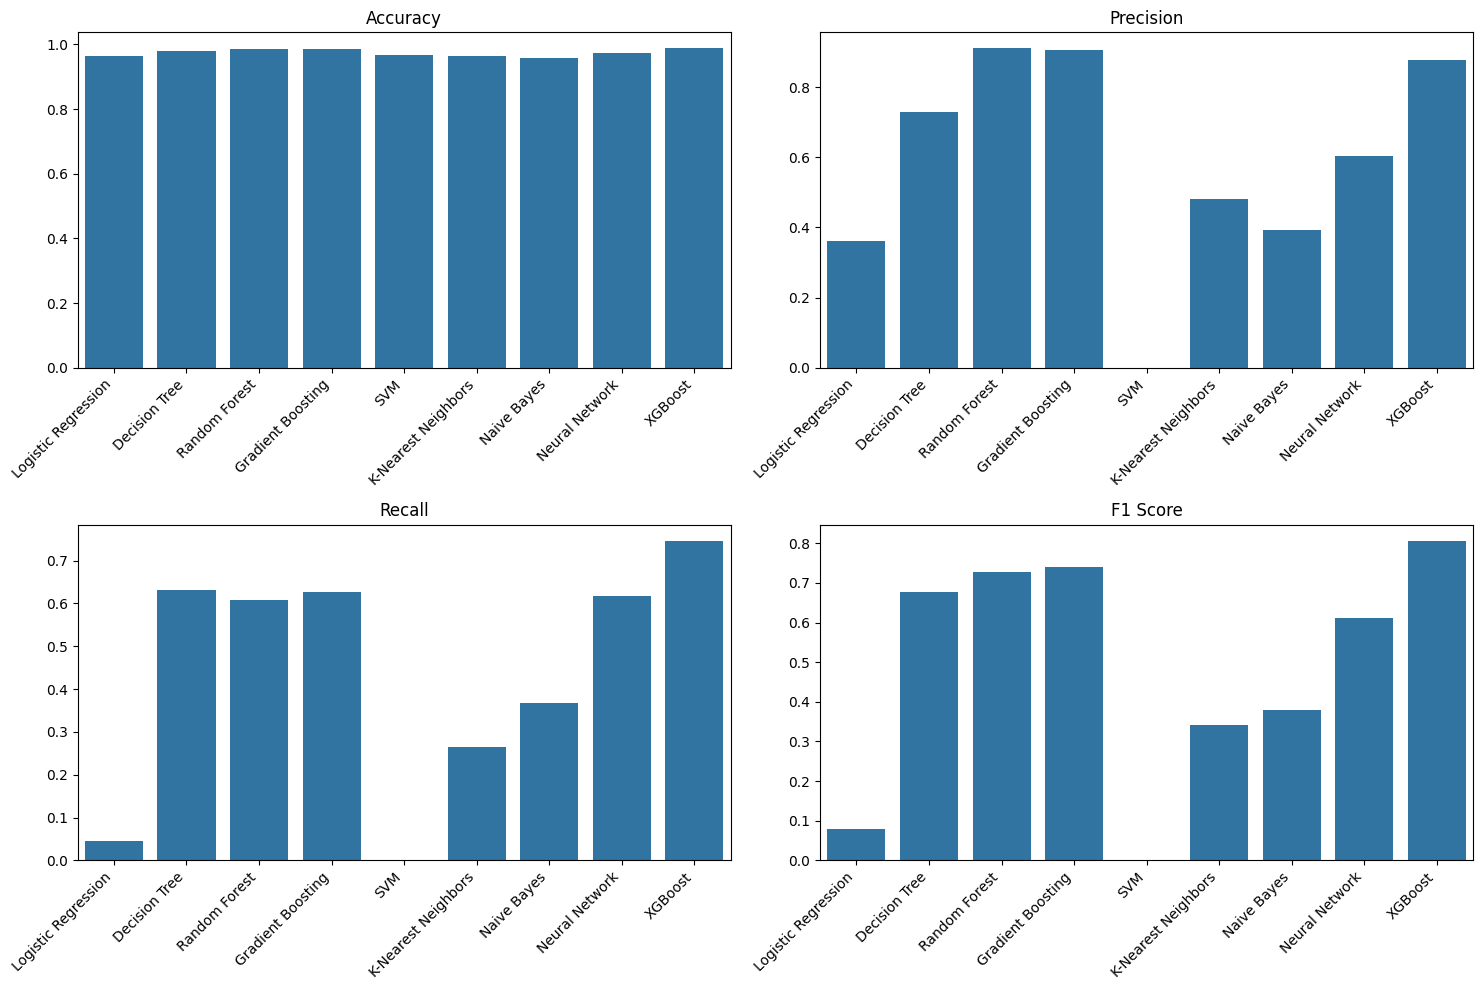

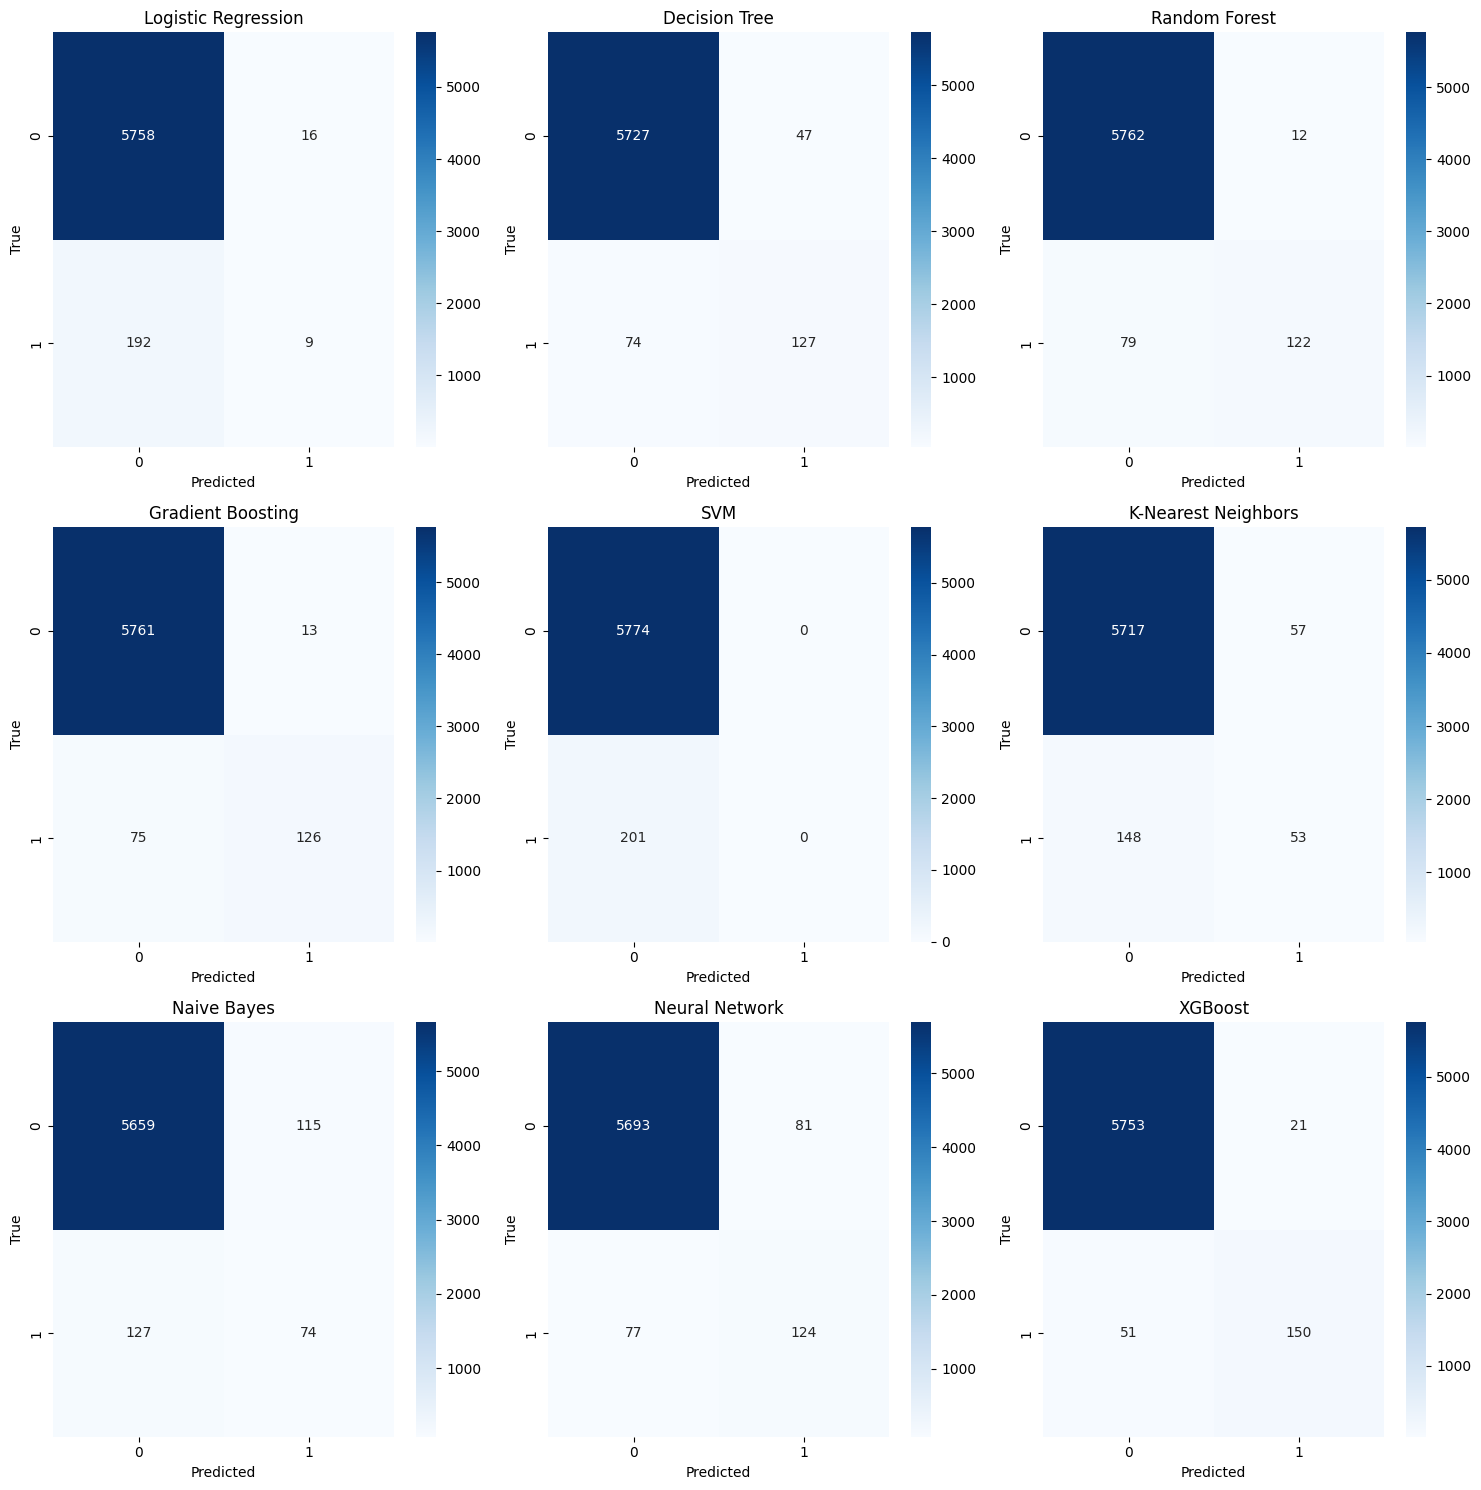

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-83-9e55cd515dcd>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes['sum'] = votes.sum(axis=1)
<ipython-input-83-9e55cd515dcd>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


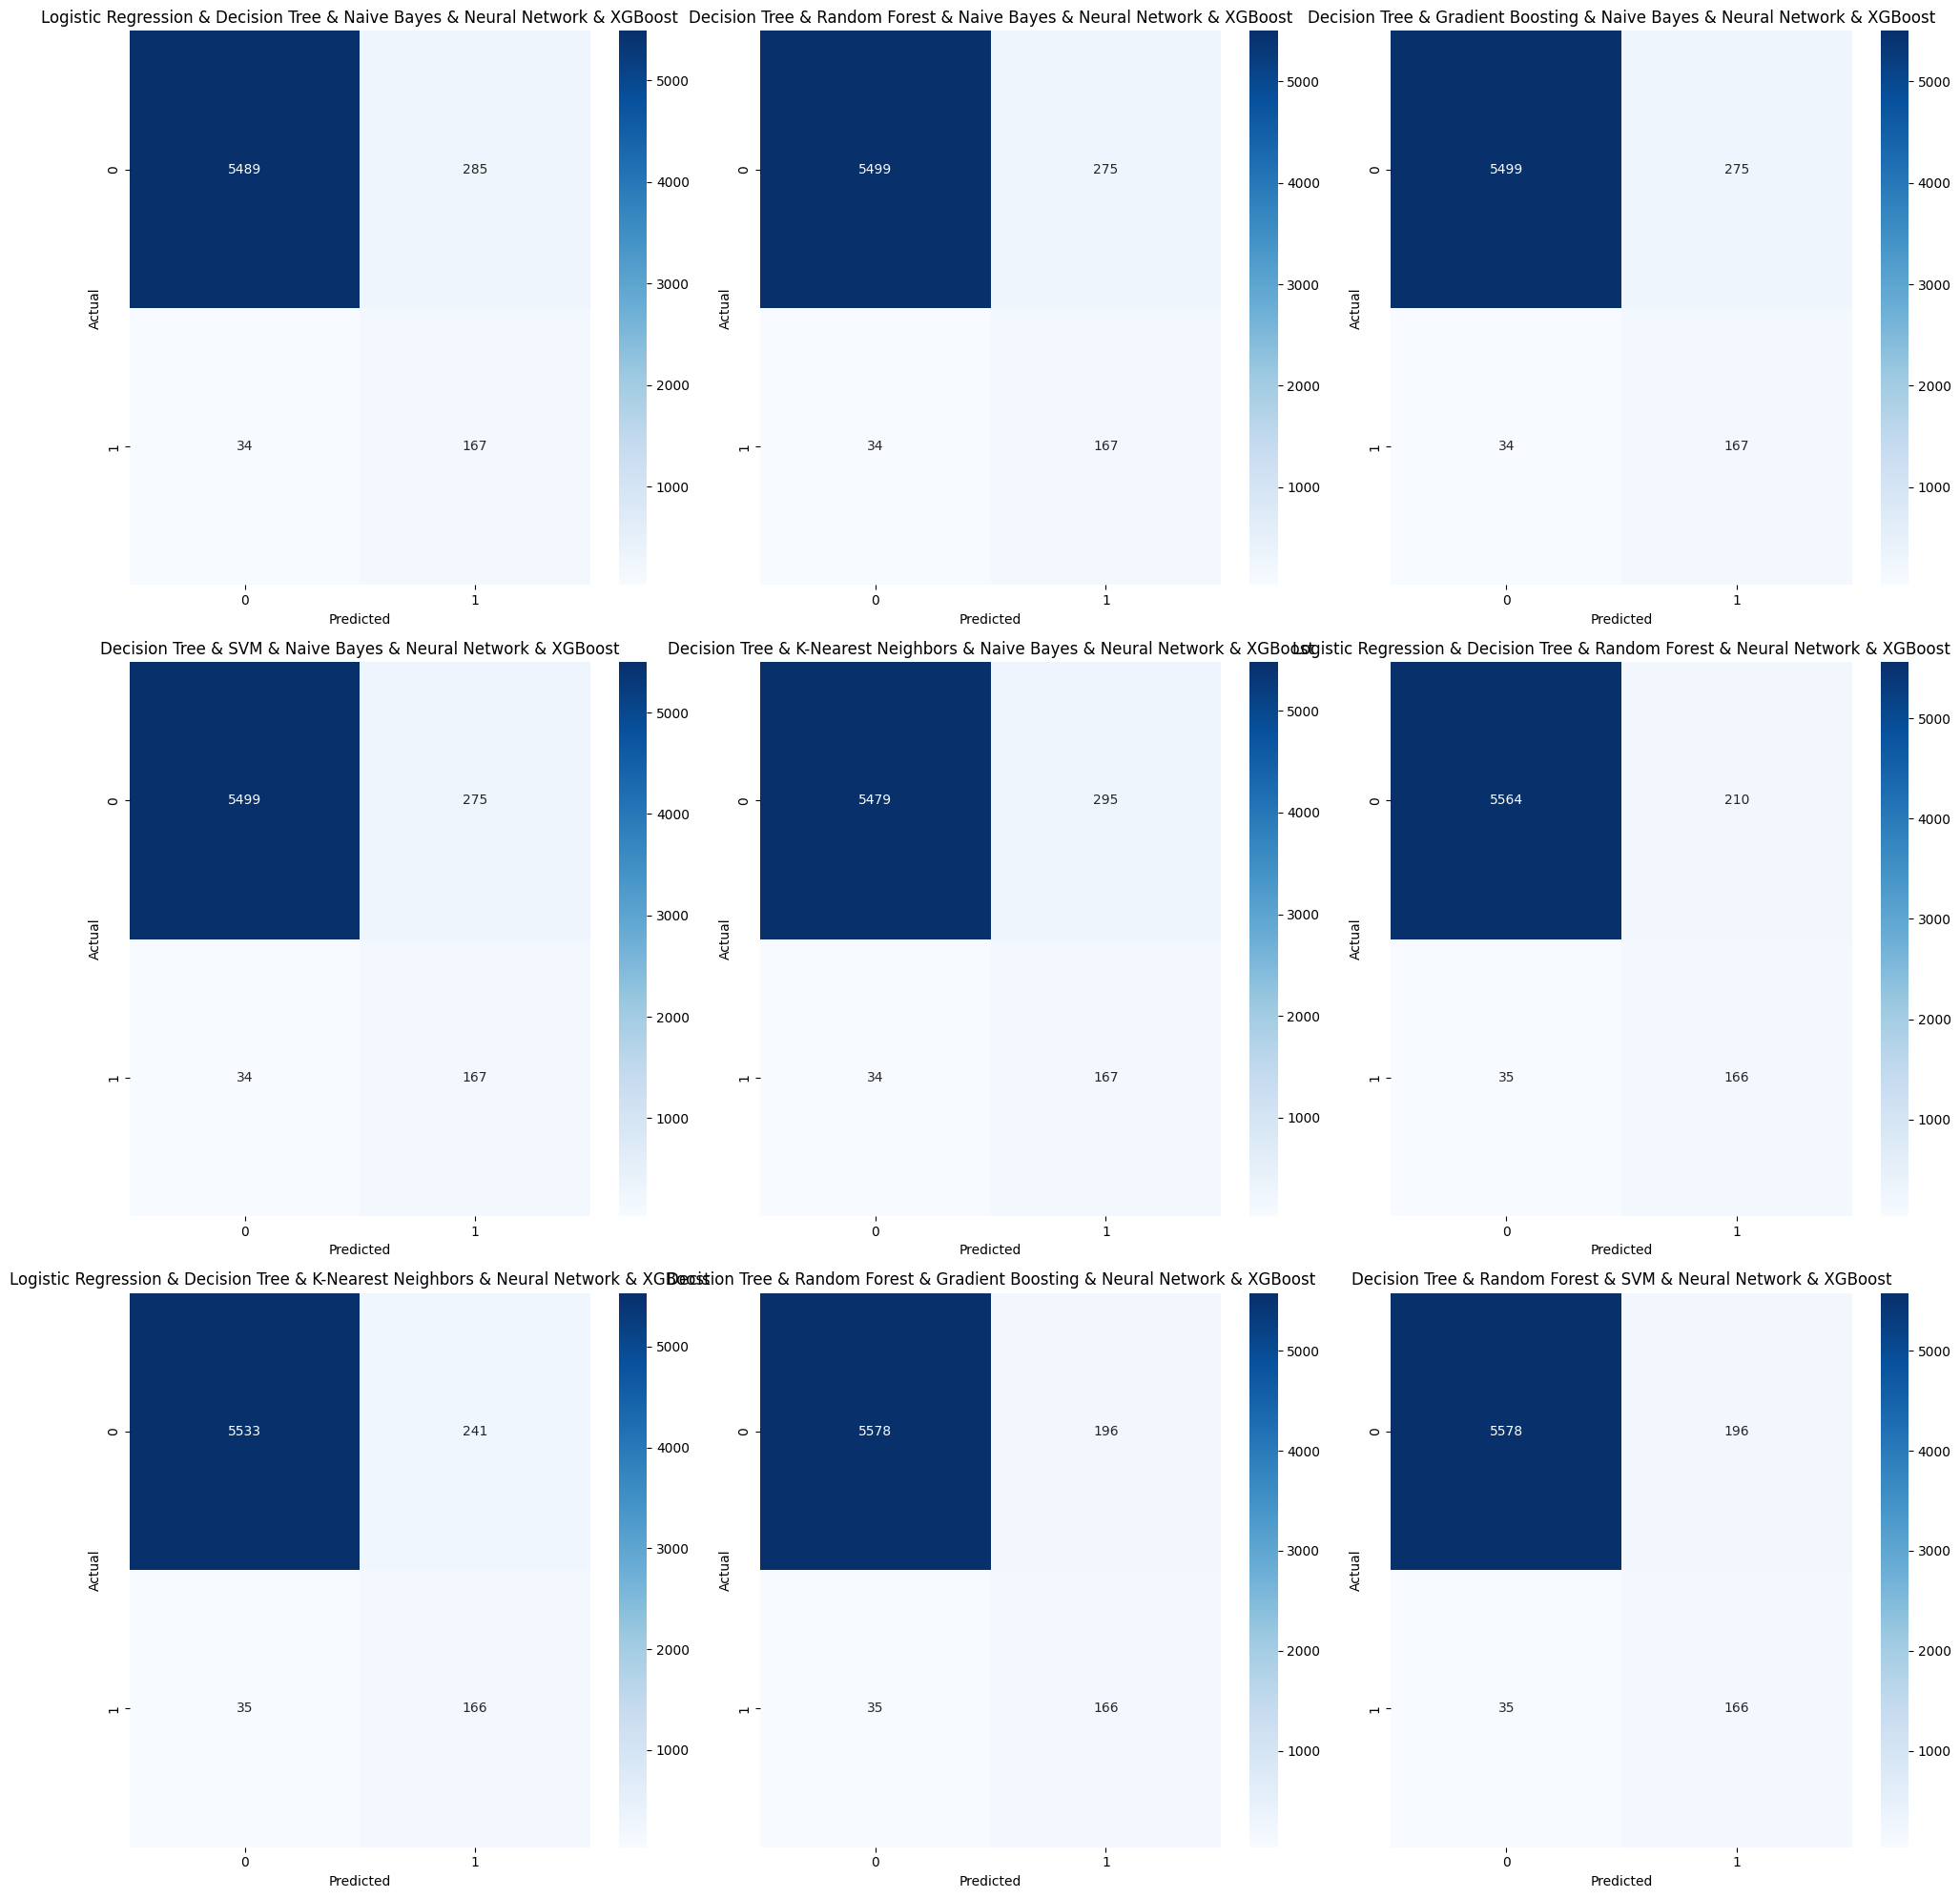

In [ ]:
######################### Year 0-5 ########################


X = XY_0_5.iloc[:,2:-2]

y = XY_0_5.iloc[:,-1]

# Separate the data based on y
X_y1 = X[y == 1]
y_y1 = y[y == 1]
X_y0 = X[y == 0]
y_y0 = y[y == 0]

# Split each subset into training and testing sets with a ratio of 6:4
X_y1_train, X_y1_test, y_y1_train, y_y1_test = train_test_split(X_y1, y_y1, test_size=0.4, random_state=42)
X_y0_train, X_y0_test, y_y0_train, y_y0_test = train_test_split(X_y0, y_y0, test_size=0.4, random_state=42)

# Combine the training sets and testing sets from both subsets
X_train = pd.concat([X_y1_train, X_y0_train])
y_train = pd.concat([y_y1_train, y_y0_train])
X_test = pd.concat([X_y1_test, X_y0_test])
y_test = pd.concat([y_y1_test, y_y0_test])

# Shuffle the combined training and testing sets
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Reindex the shuffled sets
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Now X_train, X_test, y_train, and y_test are ready for use
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree:\n", classification_report(y_test, y_pred_dt))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting:\n", classification_report(y_test, y_pred_gb))

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine:\n", classification_report(y_test, y_pred_svm))

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("K-Nearest Neighbors:\n", classification_report(y_test, y_pred_knn))

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))

# Neural Network
nn = MLPClassifier()
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
print("Neural Network:\n", classification_report(y_test, y_pred_nn))

# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(),
    "XGBoost": XGBClassifier()
}

# Train and predict
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Plotting metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for idx, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    sns.barplot(x=list(models.keys()), y=values, ax=axs[idx])
    axs[idx].set_title(metric)
    axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Plotting confusion matrices
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for idx, model in enumerate(models):
    cm = results[model]["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(model)
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('True')

plt.tight_layout()
plt.show()




import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and predict
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# Create DataFrame of predictions
pred_df = pd.DataFrame(predictions)

# Evaluate all possible juries of 5 models
combinations_list = list(combinations(models.keys(), 5))
#combinations_list = list(combinations(models.keys(), 4))
results = []

for combo in combinations_list:
    votes = pred_df[list(combo)]
    votes['sum'] = votes.sum(axis=1)
    votes['final_prediction'] = votes['sum'].apply(lambda x: 1 if x >= 1 else 0 )
#    votes['final_prediction'] = votes['sum'].apply(lambda x: 1 if x >= 3 else (0 if x <= 1 else 'do not score'))

    # Filter out 'do not score' predictions
    valid_votes = votes[votes['final_prediction'] != 'do not score']
    valid_indices = valid_votes.index
    actual_values = y_test.iloc[valid_indices]
    voted_predictions = valid_votes['final_prediction'].astype(int)  # Ensure binary targets

    # Calculate accuracy
    accuracy = accuracy_score(actual_values, voted_predictions)

    # Calculate true positives (TP)
    conf_matrix = confusion_matrix(actual_values, voted_predictions)
    true_positives = conf_matrix[1, 1]

    # Store the result
    results.append({
        'models': combo,
        'accuracy': accuracy,
        'valid_count': len(voted_predictions),
        'conf_matrix': conf_matrix,
        'true_positives': true_positives
    })

# Sort results by true positives in descending order and select top 9 combinations
results_sorted = sorted(results, key=lambda x: x['true_positives'], reverse=True)
top_9_results = results_sorted[:9]

# Plotting confusion matrices for the top 9 combinations
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.ravel()

for idx, result in enumerate(top_9_results):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(' & '.join(result['models']))
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()


Training set size: 8960
Test set size: 5975


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      5774
           1       0.37      0.07      0.12       201

    accuracy                           0.96      5975
   macro avg       0.67      0.53      0.55      5975
weighted avg       0.95      0.96      0.95      5975

Decision Tree:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5774
           1       0.71      0.67      0.69       201

    accuracy                           0.98      5975
   macro avg       0.85      0.83      0.84      5975
weighted avg       0.98      0.98      0.98      5975

Random Forest:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5774
           1       0.89      0.61      0.73       201

    accuracy                           0.98      5975
   macro avg       0.94      0.80      0.86      5975
weighted avg       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Machine:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      5774
           1       0.00      0.00      0.00       201

    accuracy                           0.97      5975
   macro avg       0.48      0.50      0.49      5975
weighted avg       0.93      0.97      0.95      5975

K-Nearest Neighbors:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      5774
           1       0.57      0.29      0.39       201

    accuracy                           0.97      5975
   macro avg       0.77      0.64      0.69      5975
weighted avg       0.96      0.97      0.96      5975

Naive Bayes:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5774
           1       0.44      0.33      0.38       201

    accuracy                           0.96      5975
   macro avg       0.71      0.66      0.68      5975
weighted avg 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-84-f815d4f8ee51>:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')
<ipyth

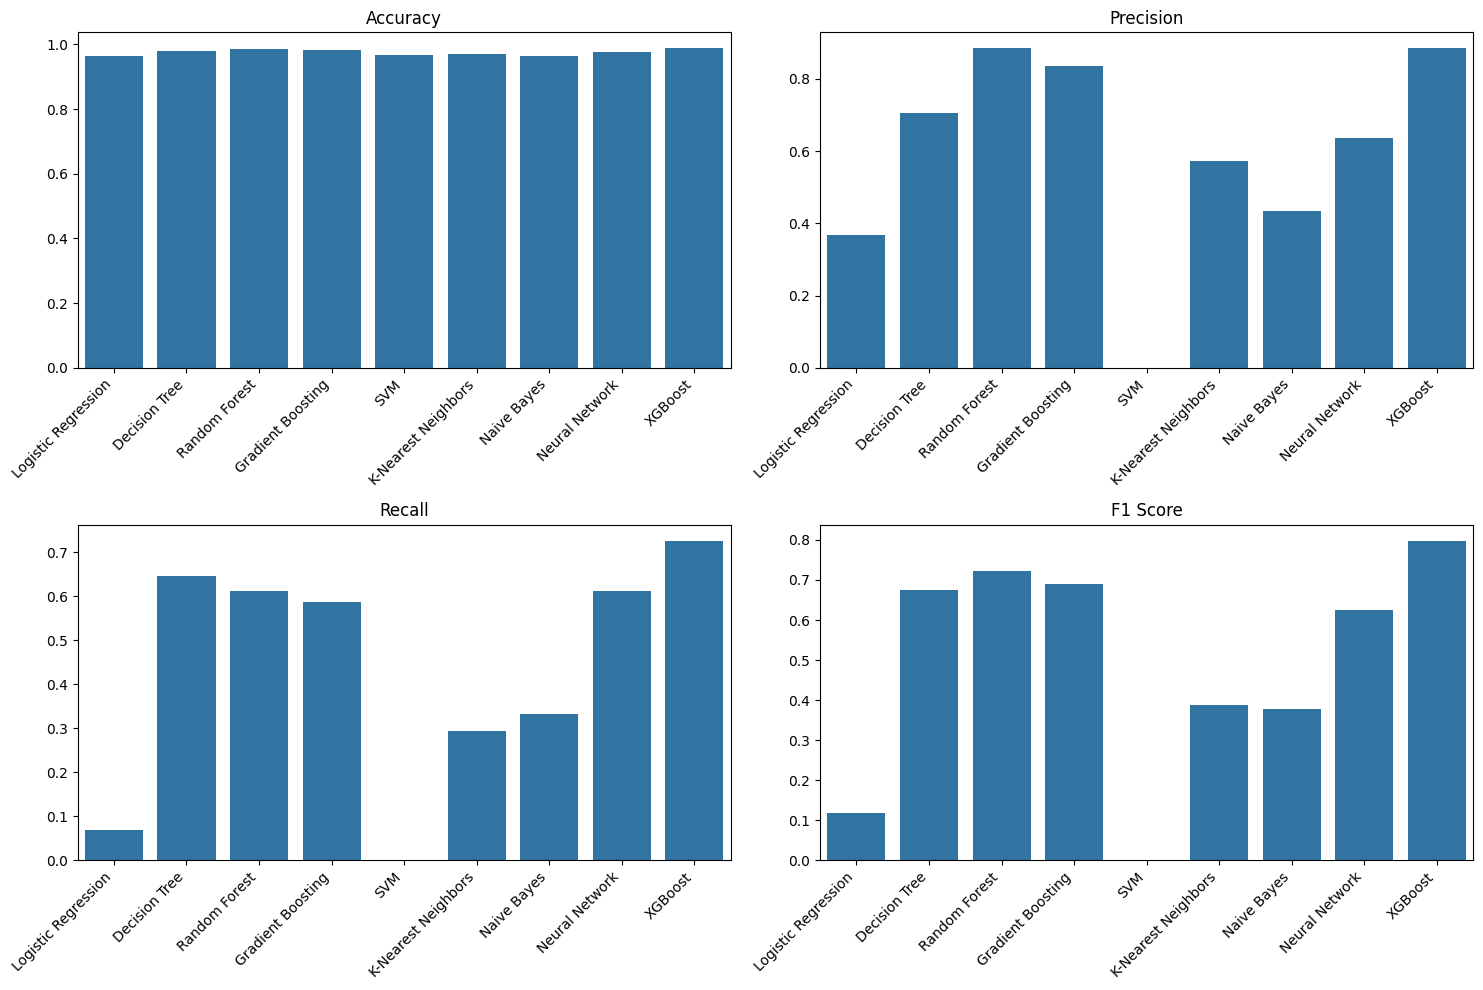

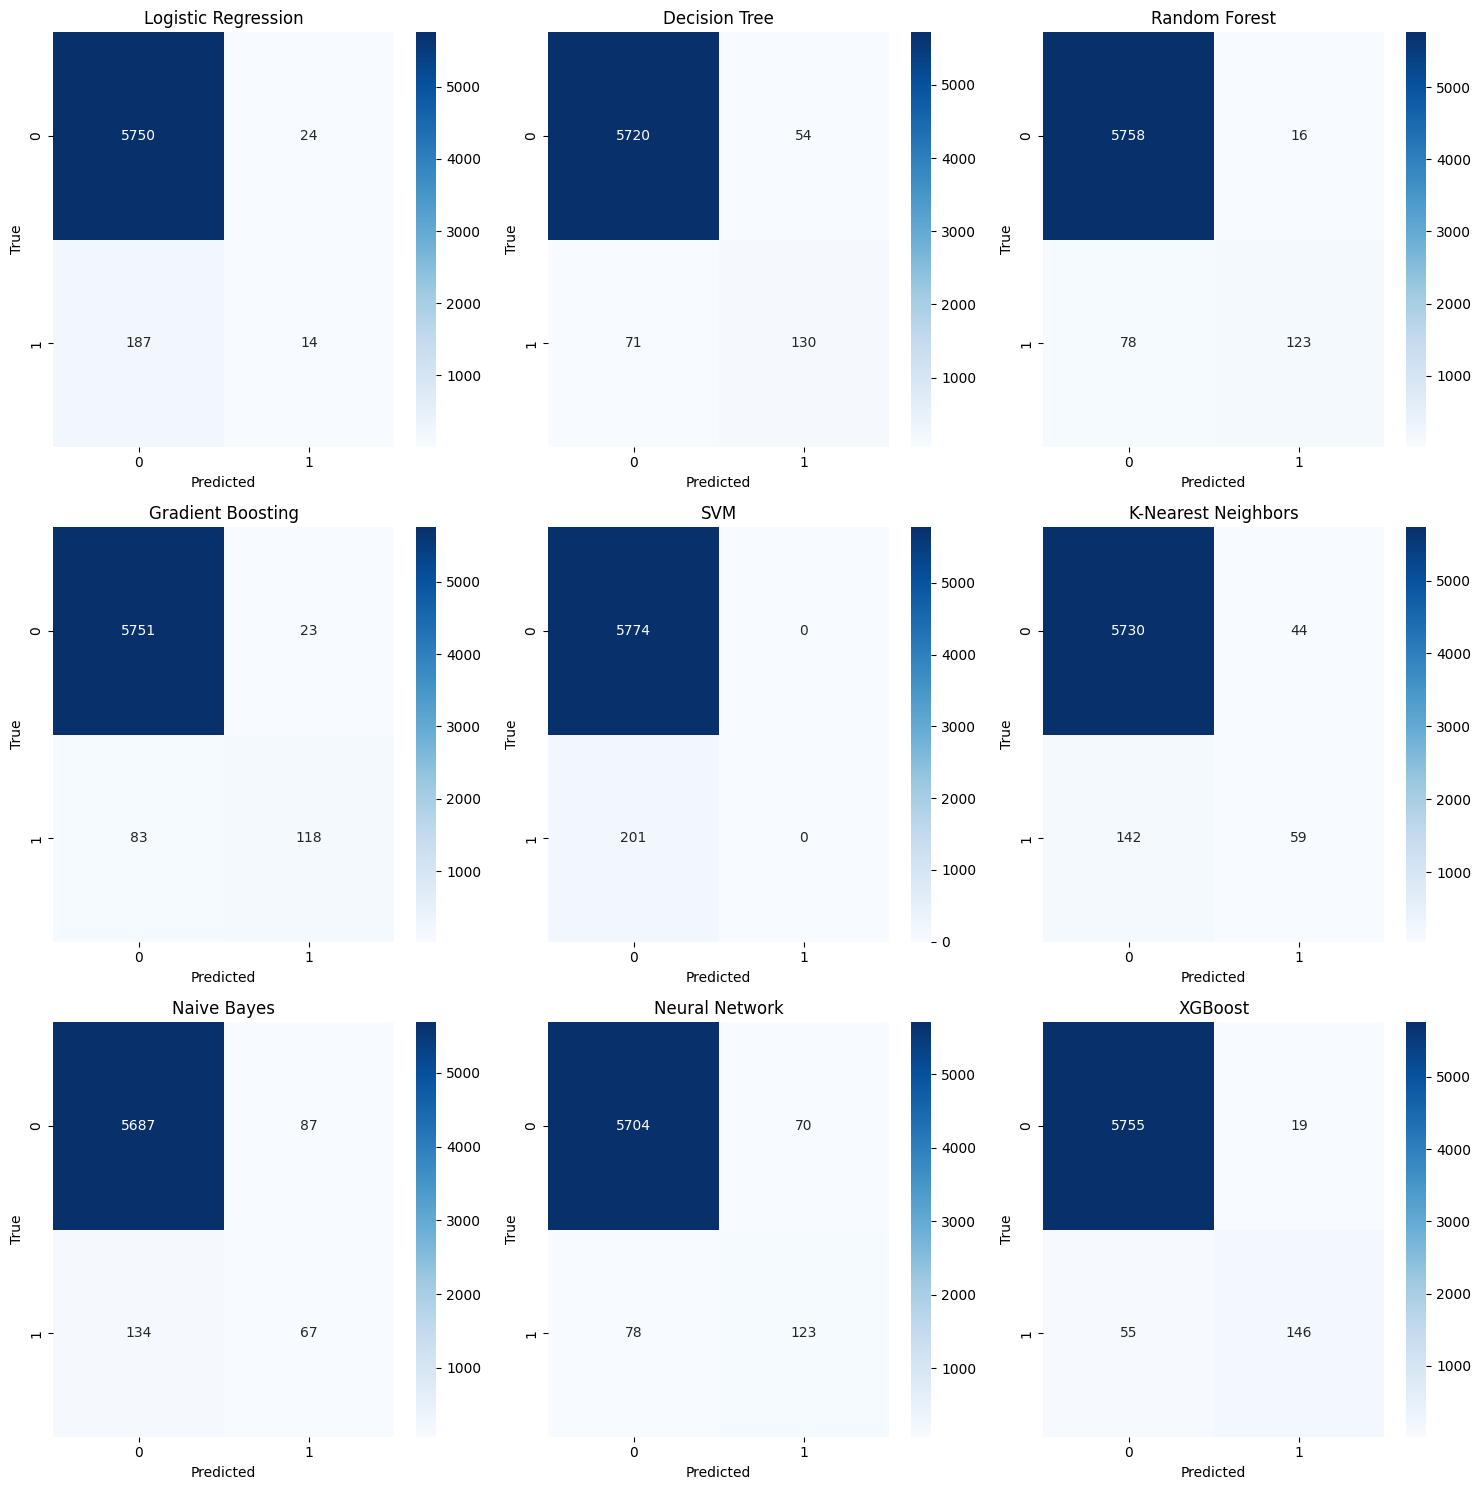

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-84-f815d4f8ee51>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes['sum'] = votes.sum(axis=1)
<ipython-input-84-f815d4f8ee51>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


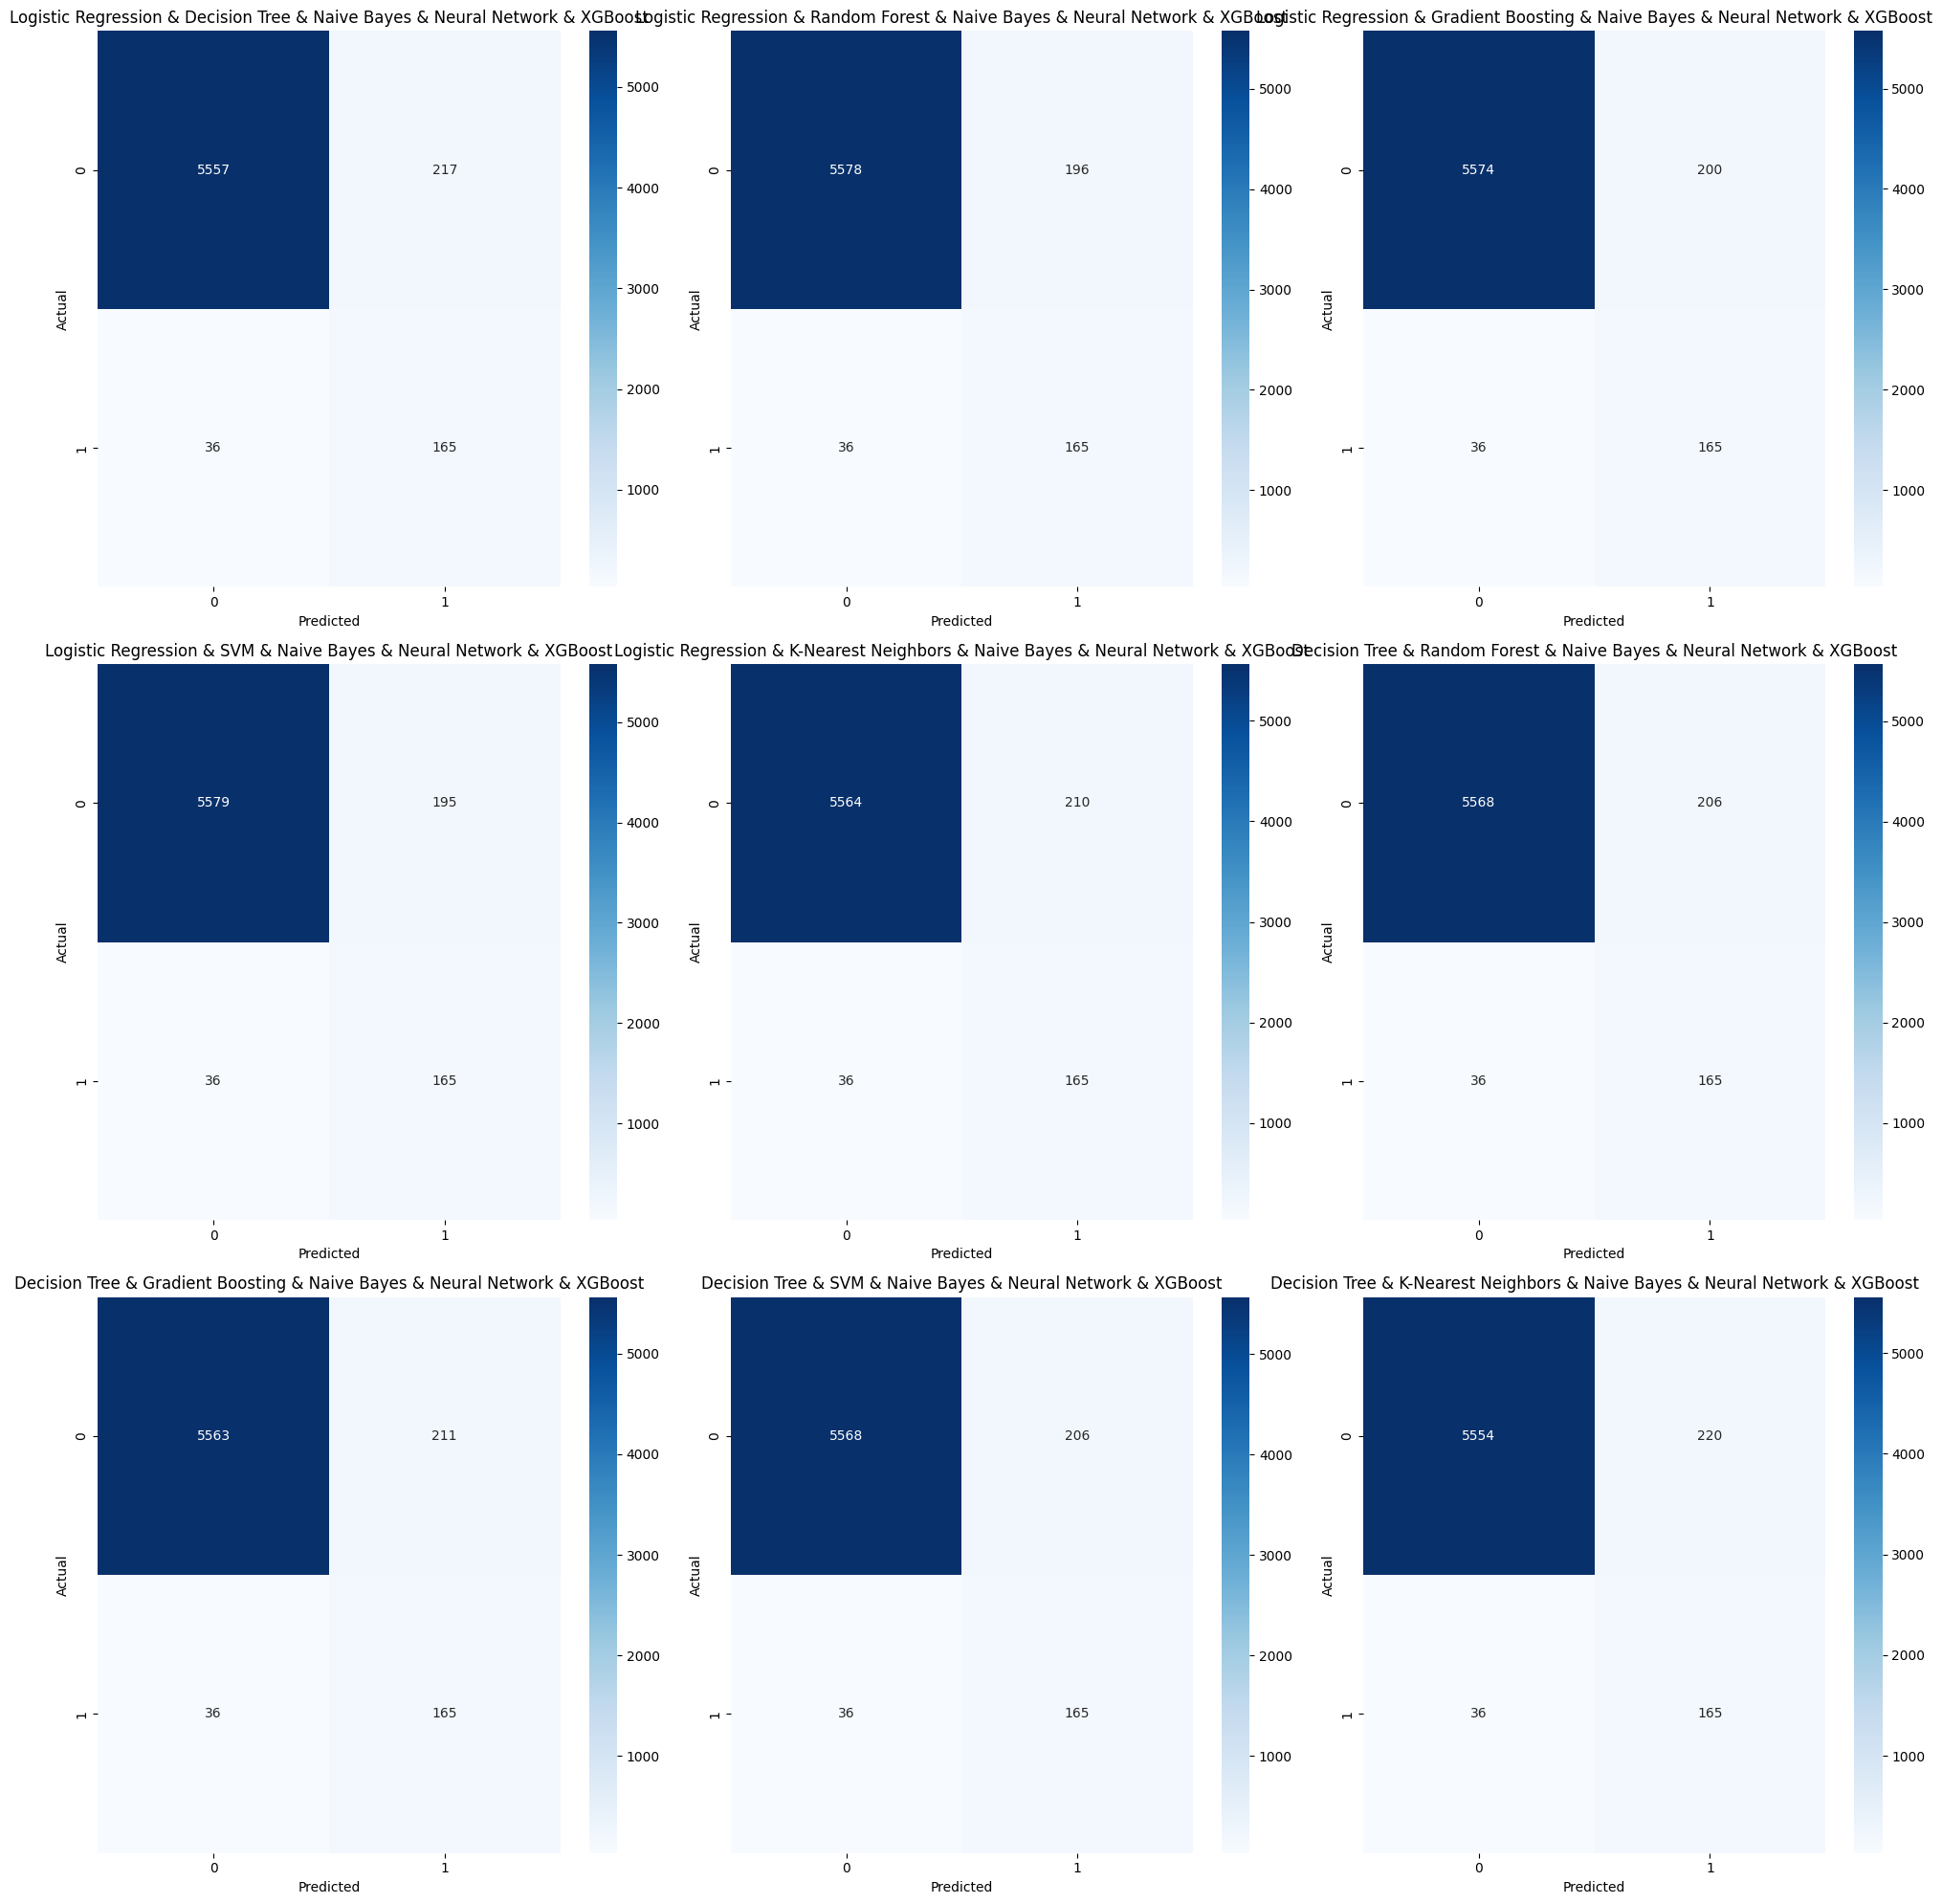

In [ ]:
######################### Year 0-10 ########################


X = XY_0_10.iloc[:,2:-2]

y = XY_0_10.iloc[:,-1]

# Separate the data based on y
X_y1 = X[y == 1]
y_y1 = y[y == 1]
X_y0 = X[y == 0]
y_y0 = y[y == 0]

# Split each subset into training and testing sets with a ratio of 6:4
X_y1_train, X_y1_test, y_y1_train, y_y1_test = train_test_split(X_y1, y_y1, test_size=0.4, random_state=42)
X_y0_train, X_y0_test, y_y0_train, y_y0_test = train_test_split(X_y0, y_y0, test_size=0.4, random_state=42)

# Combine the training sets and testing sets from both subsets
X_train = pd.concat([X_y1_train, X_y0_train])
y_train = pd.concat([y_y1_train, y_y0_train])
X_test = pd.concat([X_y1_test, X_y0_test])
y_test = pd.concat([y_y1_test, y_y0_test])

# Shuffle the combined training and testing sets
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Reindex the shuffled sets
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Now X_train, X_test, y_train, and y_test are ready for use
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree:\n", classification_report(y_test, y_pred_dt))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting:\n", classification_report(y_test, y_pred_gb))

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine:\n", classification_report(y_test, y_pred_svm))

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("K-Nearest Neighbors:\n", classification_report(y_test, y_pred_knn))

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))

# Neural Network
nn = MLPClassifier()
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
print("Neural Network:\n", classification_report(y_test, y_pred_nn))

# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(),
    "XGBoost": XGBClassifier()
}

# Train and predict
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Plotting metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for idx, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    sns.barplot(x=list(models.keys()), y=values, ax=axs[idx])
    axs[idx].set_title(metric)
    axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Plotting confusion matrices
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for idx, model in enumerate(models):
    cm = results[model]["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(model)
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('True')

plt.tight_layout()
plt.show()




import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and predict
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# Create DataFrame of predictions
pred_df = pd.DataFrame(predictions)

# Evaluate all possible juries of 4 models
combinations_list = list(combinations(models.keys(), 5))
results = []

for combo in combinations_list:
    votes = pred_df[list(combo)]
    votes['sum'] = votes.sum(axis=1)
    votes['final_prediction'] = votes['sum'].apply(lambda x: 1 if x >= 1 else 0)

    # Filter out 'do not score' predictions
    valid_votes = votes[votes['final_prediction'] != 'do not score']
    valid_indices = valid_votes.index
    actual_values = y_test.iloc[valid_indices]
    voted_predictions = valid_votes['final_prediction'].astype(int)  # Ensure binary targets

    # Calculate accuracy
    accuracy = accuracy_score(actual_values, voted_predictions)

    # Calculate true positives (TP)
    conf_matrix = confusion_matrix(actual_values, voted_predictions)
    true_positives = conf_matrix[1, 1]

    # Store the result
    results.append({
        'models': combo,
        'accuracy': accuracy,
        'valid_count': len(voted_predictions),
        'conf_matrix': conf_matrix,
        'true_positives': true_positives
    })

# Sort results by true positives in descending order and select top 9 combinations
results_sorted = sorted(results, key=lambda x: x['true_positives'], reverse=True)
top_9_results = results_sorted[:9]

# Plotting confusion matrices for the top 9 combinations
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.ravel()

for idx, result in enumerate(top_9_results):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(' & '.join(result['models']))
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()


Training set size: 8960
Test set size: 5975


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5774
           1       0.44      0.48      0.46       201

    accuracy                           0.96      5975
   macro avg       0.71      0.73      0.72      5975
weighted avg       0.96      0.96      0.96      5975

Decision Tree:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5774
           1       0.71      0.65      0.68       201

    accuracy                           0.98      5975
   macro avg       0.85      0.82      0.83      5975
weighted avg       0.98      0.98      0.98      5975

Random Forest:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5774
           1       0.87      0.62      0.72       201

    accuracy                           0.98      5975
   macro avg       0.93      0.81      0.86      5975
weighted avg       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Machine:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      5774
           1       0.00      0.00      0.00       201

    accuracy                           0.97      5975
   macro avg       0.48      0.50      0.49      5975
weighted avg       0.93      0.97      0.95      5975

K-Nearest Neighbors:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      5774
           1       0.63      0.35      0.45       201

    accuracy                           0.97      5975
   macro avg       0.80      0.67      0.72      5975
weighted avg       0.97      0.97      0.97      5975

Naive Bayes:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      5774
           1       0.47      0.35      0.40       201

    accuracy                           0.97      5975
   macro avg       0.73      0.67      0.69      5975
weighted avg 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-85-e3dea5b8ee6a>:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')
<ipyth

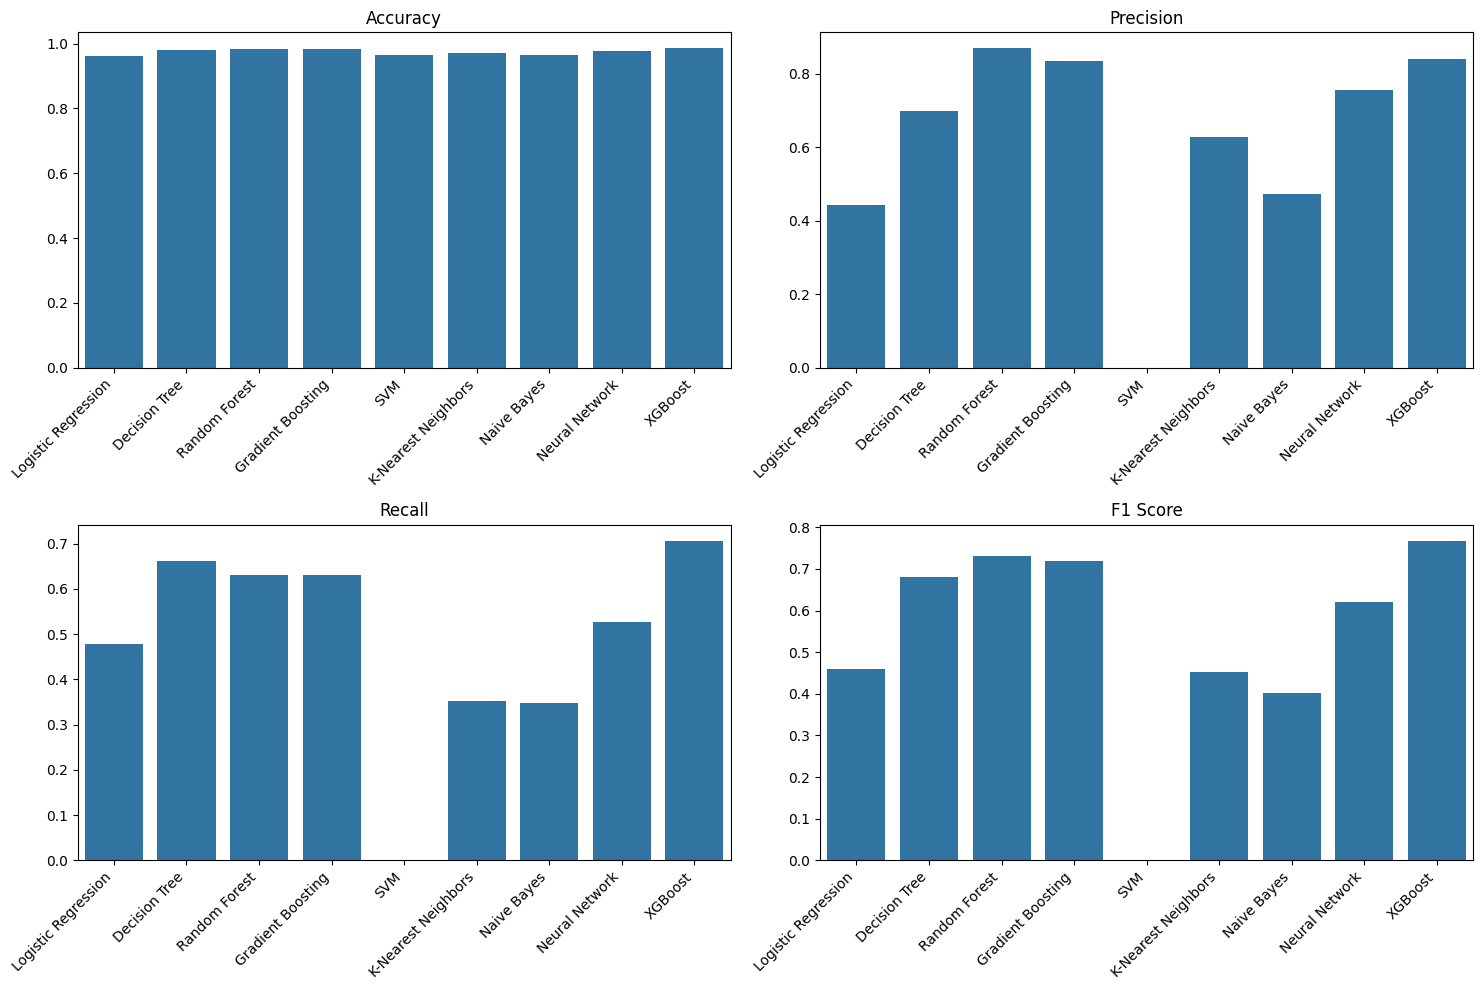

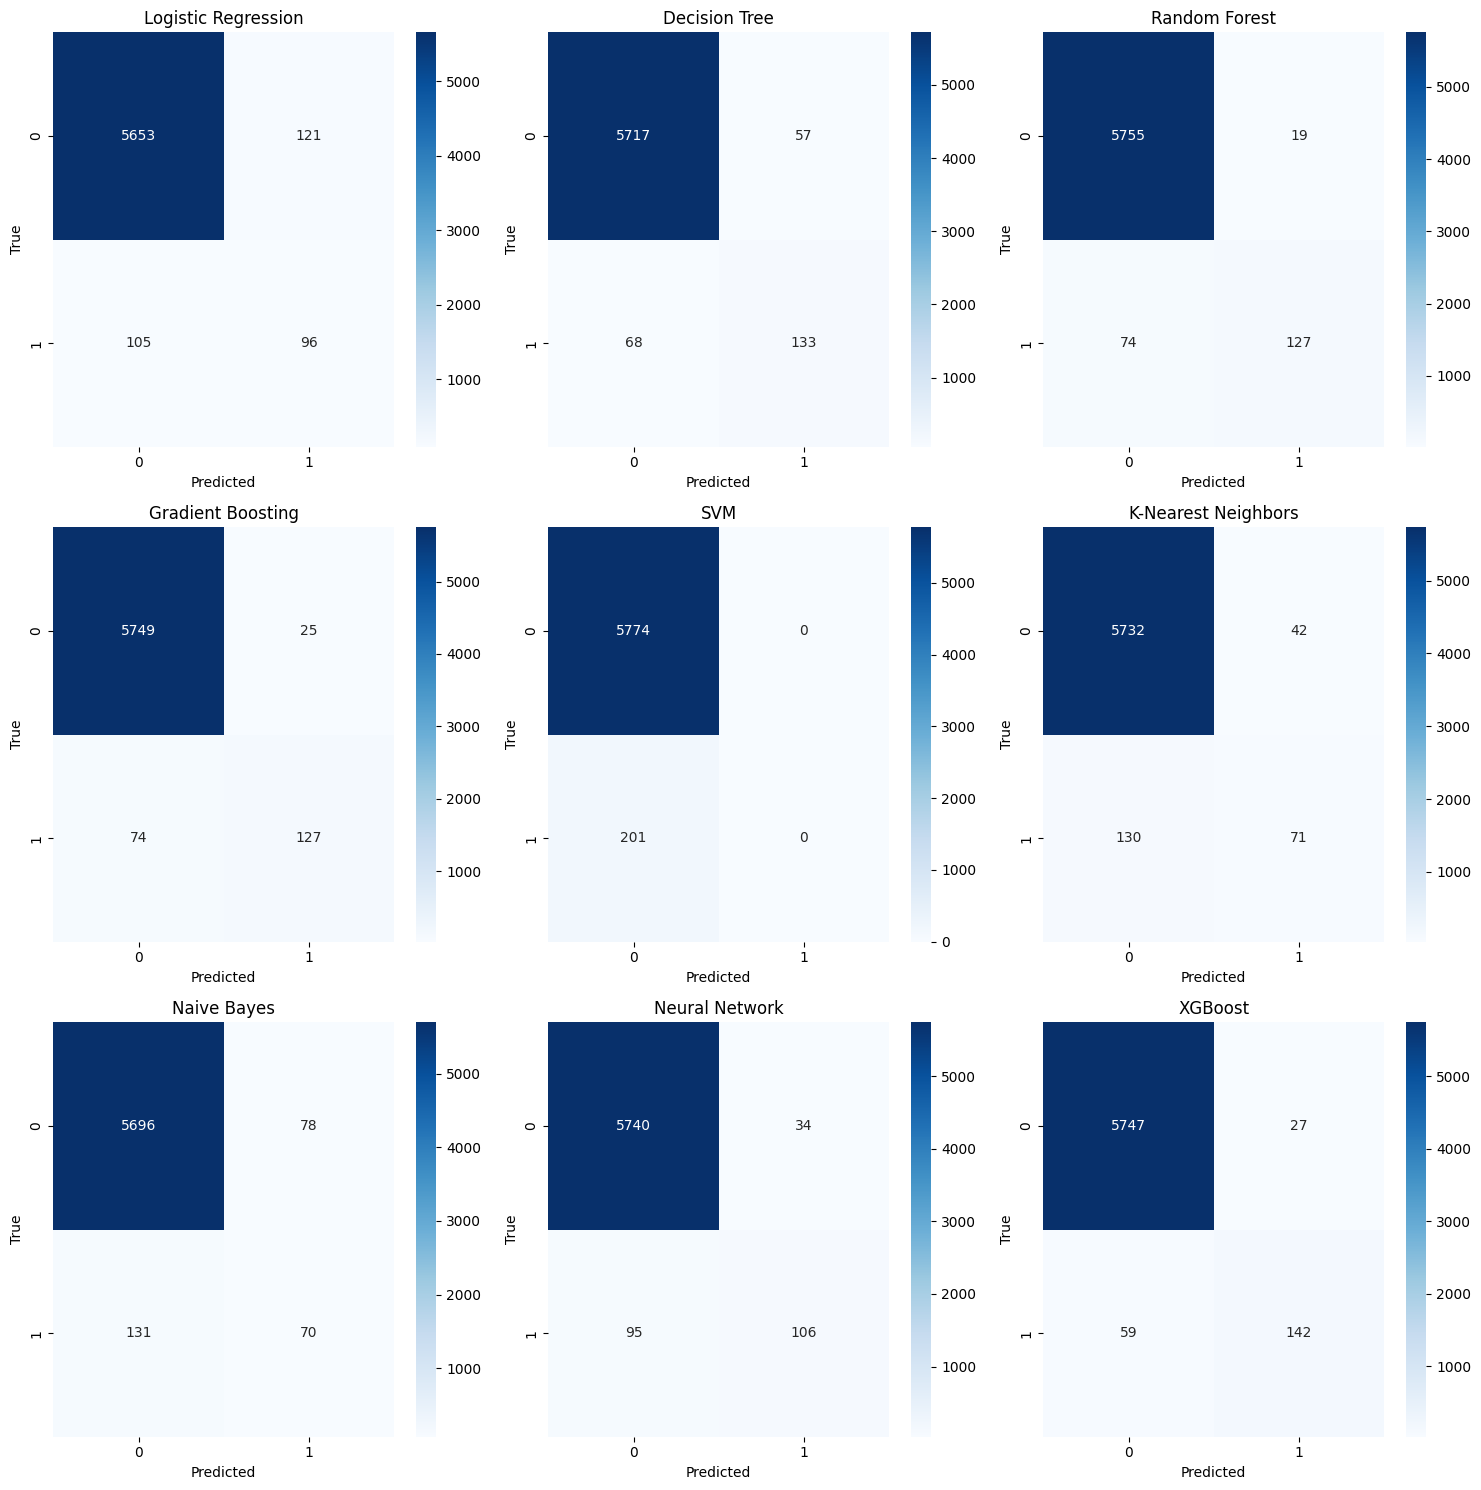

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-85-e3dea5b8ee6a>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes['sum'] = votes.sum(axis=1)
<ipython-input-85-e3dea5b8ee6a>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


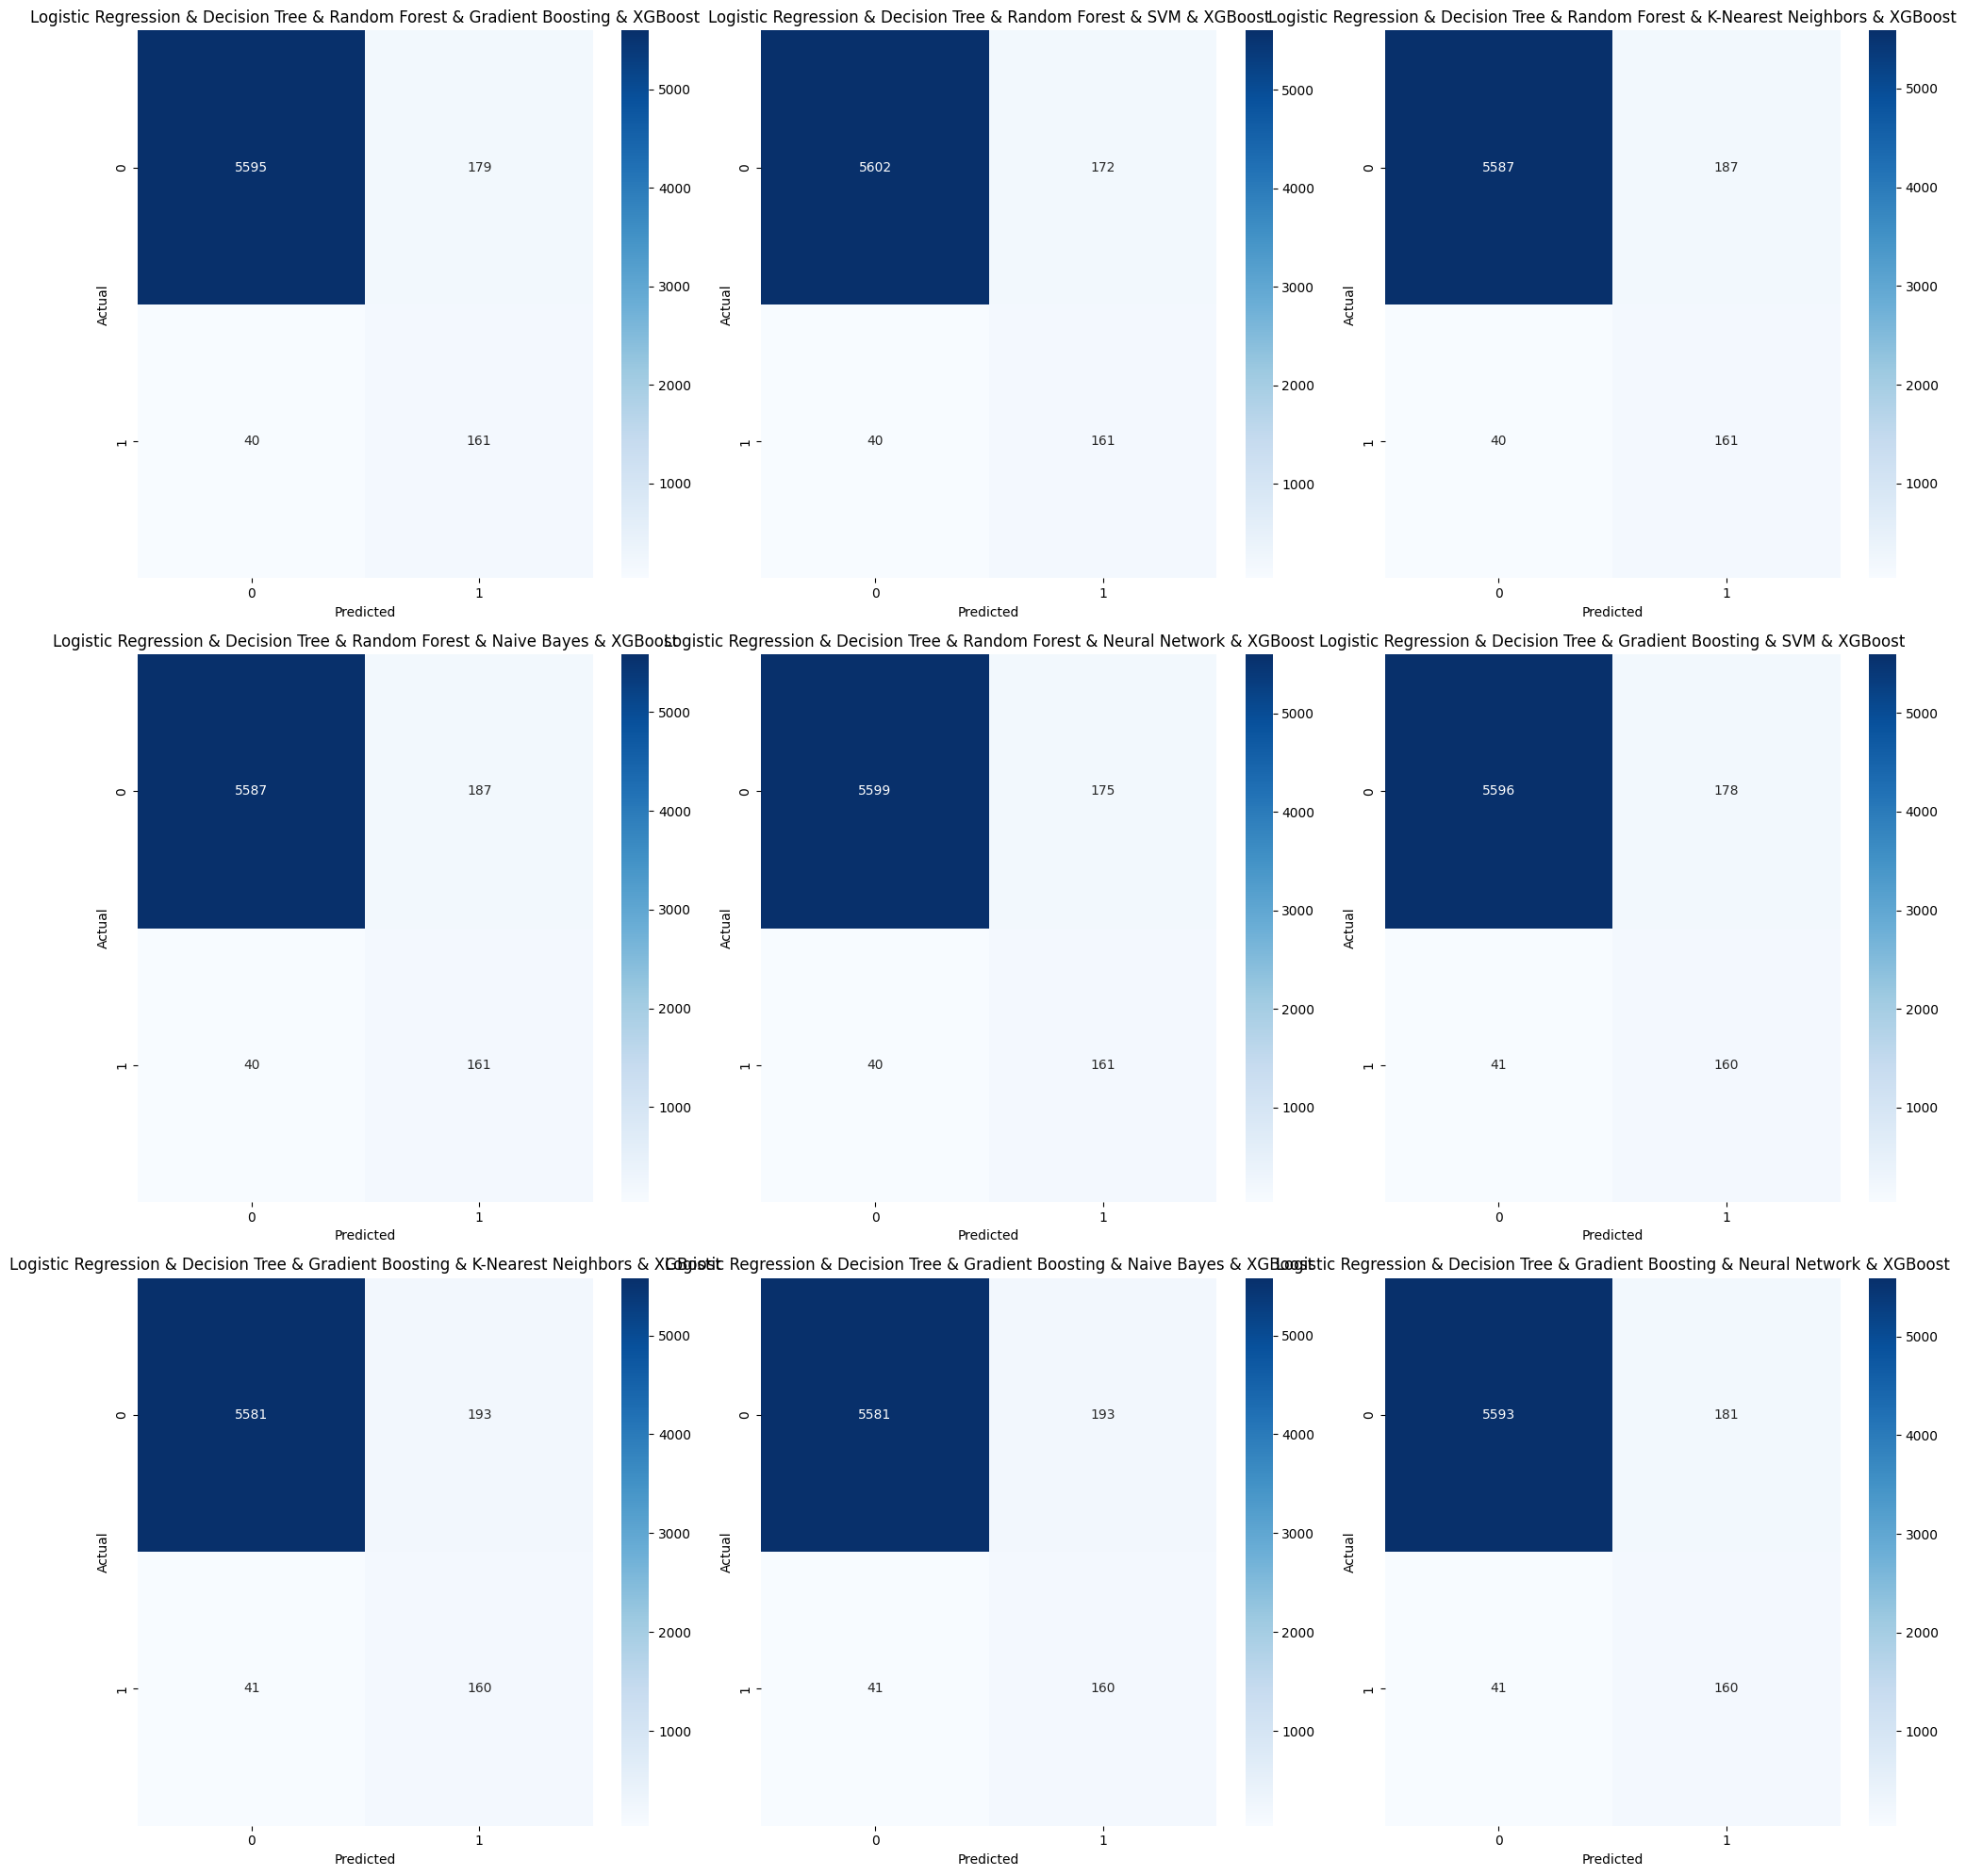

In [ ]:
######################### Year 0-15 ########################

X = XY_0_15.iloc[:,2:-2]

y = XY_0_15.iloc[:,-1]

# Separate the data based on y
X_y1 = X[y == 1]
y_y1 = y[y == 1]
X_y0 = X[y == 0]
y_y0 = y[y == 0]

# Split each subset into training and testing sets with a ratio of 6:4
X_y1_train, X_y1_test, y_y1_train, y_y1_test = train_test_split(X_y1, y_y1, test_size=0.4, random_state=42)
X_y0_train, X_y0_test, y_y0_train, y_y0_test = train_test_split(X_y0, y_y0, test_size=0.4, random_state=42)

# Combine the training sets and testing sets from both subsets
X_train = pd.concat([X_y1_train, X_y0_train])
y_train = pd.concat([y_y1_train, y_y0_train])
X_test = pd.concat([X_y1_test, X_y0_test])
y_test = pd.concat([y_y1_test, y_y0_test])

# Shuffle the combined training and testing sets
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Reindex the shuffled sets
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Now X_train, X_test, y_train, and y_test are ready for use
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree:\n", classification_report(y_test, y_pred_dt))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting:\n", classification_report(y_test, y_pred_gb))

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine:\n", classification_report(y_test, y_pred_svm))

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("K-Nearest Neighbors:\n", classification_report(y_test, y_pred_knn))

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))

# Neural Network
nn = MLPClassifier()
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
print("Neural Network:\n", classification_report(y_test, y_pred_nn))

# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(),
    "XGBoost": XGBClassifier()
}

# Train and predict
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Plotting metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for idx, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    sns.barplot(x=list(models.keys()), y=values, ax=axs[idx])
    axs[idx].set_title(metric)
    axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Plotting confusion matrices
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for idx, model in enumerate(models):
    cm = results[model]["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(model)
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('True')

plt.tight_layout()
plt.show()




import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and predict
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# Create DataFrame of predictions
pred_df = pd.DataFrame(predictions)

# Evaluate all possible juries of 4 models
combinations_list = list(combinations(models.keys(), 5))
results = []

for combo in combinations_list:
    votes = pred_df[list(combo)]
    votes['sum'] = votes.sum(axis=1)
    votes['final_prediction'] = votes['sum'].apply(lambda x: 1 if x >= 1 else 0)

    # Filter out 'do not score' predictions
    valid_votes = votes[votes['final_prediction'] != 'do not score']
    valid_indices = valid_votes.index
    actual_values = y_test.iloc[valid_indices]
    voted_predictions = valid_votes['final_prediction'].astype(int)  # Ensure binary targets

    # Calculate accuracy
    accuracy = accuracy_score(actual_values, voted_predictions)

    # Calculate true positives (TP)
    conf_matrix = confusion_matrix(actual_values, voted_predictions)
    true_positives = conf_matrix[1, 1]

    # Store the result
    results.append({
        'models': combo,
        'accuracy': accuracy,
        'valid_count': len(voted_predictions),
        'conf_matrix': conf_matrix,
        'true_positives': true_positives
    })

# Sort results by true positives in descending order and select top 9 combinations
results_sorted = sorted(results, key=lambda x: x['true_positives'], reverse=True)
top_9_results = results_sorted[:9]

# Plotting confusion matrices for the top 9 combinations
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.ravel()

for idx, result in enumerate(top_9_results):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(' & '.join(result['models']))
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()


Training set size: 8960
Test set size: 5975
Logistic Regression:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5774
           1       0.30      0.15      0.20       201

    accuracy                           0.96      5975
   macro avg       0.63      0.57      0.59      5975
weighted avg       0.95      0.96      0.95      5975



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Decision Tree:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5774
           1       0.85      0.72      0.78       201

    accuracy                           0.99      5975
   macro avg       0.92      0.86      0.89      5975
weighted avg       0.99      0.99      0.99      5975

Random Forest:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5774
           1       0.96      0.73      0.83       201

    accuracy                           0.99      5975
   macro avg       0.98      0.86      0.91      5975
weighted avg       0.99      0.99      0.99      5975

Gradient Boosting:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5774
           1       0.96      0.73      0.83       201

    accuracy                           0.99      5975
   macro avg       0.98      0.87      0.91      5975
weighted avg       0.9

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-86-3b3310bf24d3>:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')
<ipython-input-86-3b3310bf24d3>:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')
<ipython-input-86-3b3310bf24d3>:131: UserWarning: FixedFormatter should only be used together with FixedL

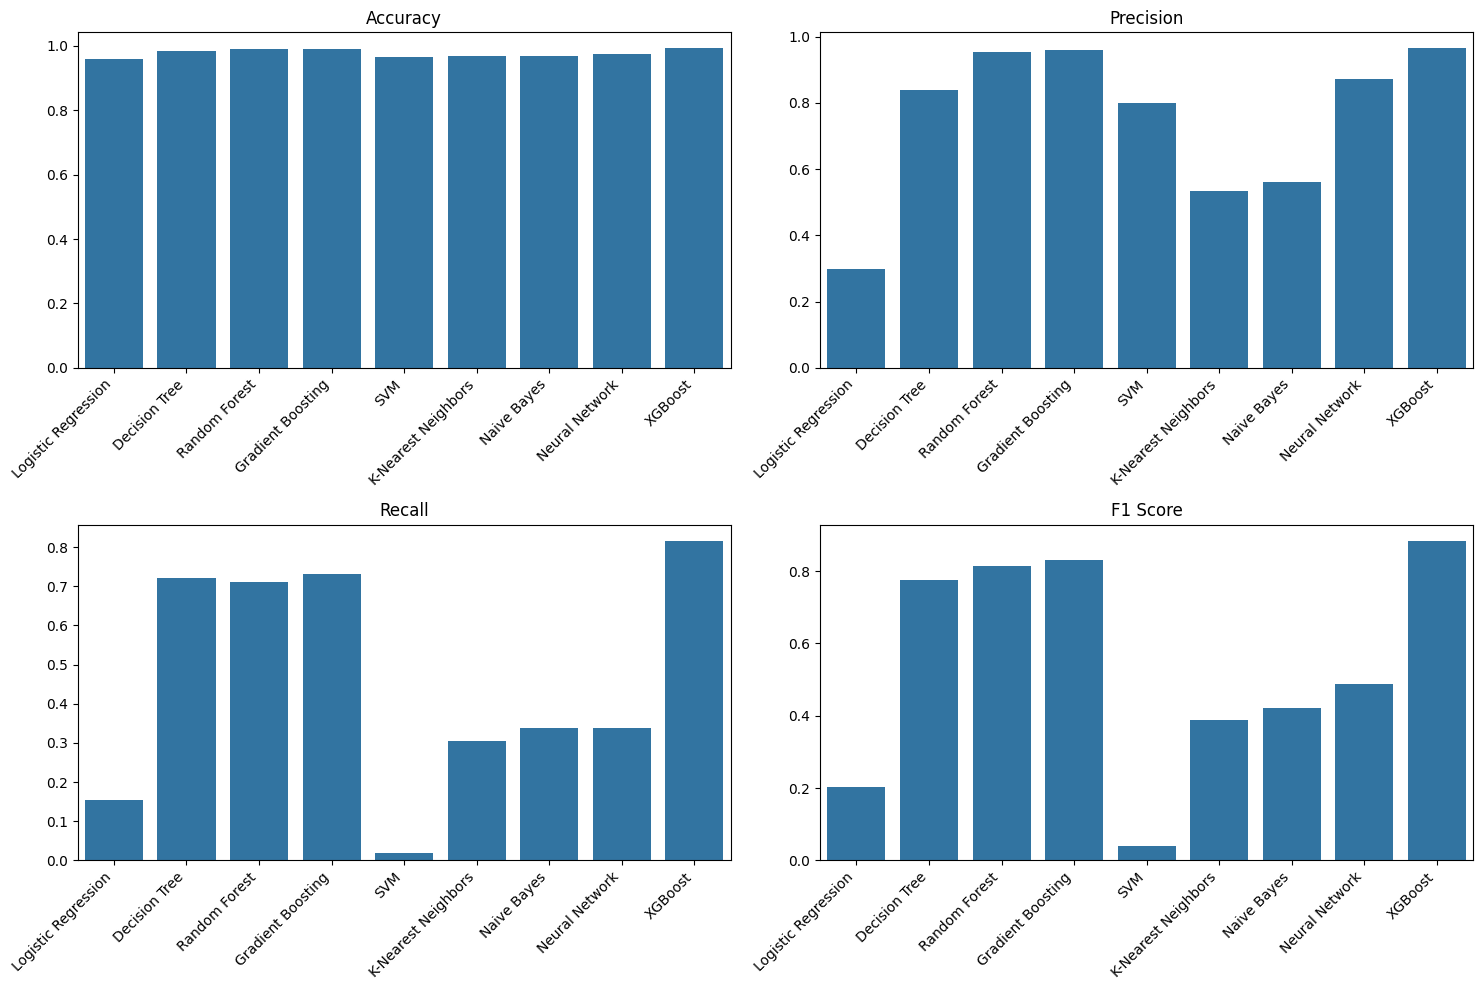

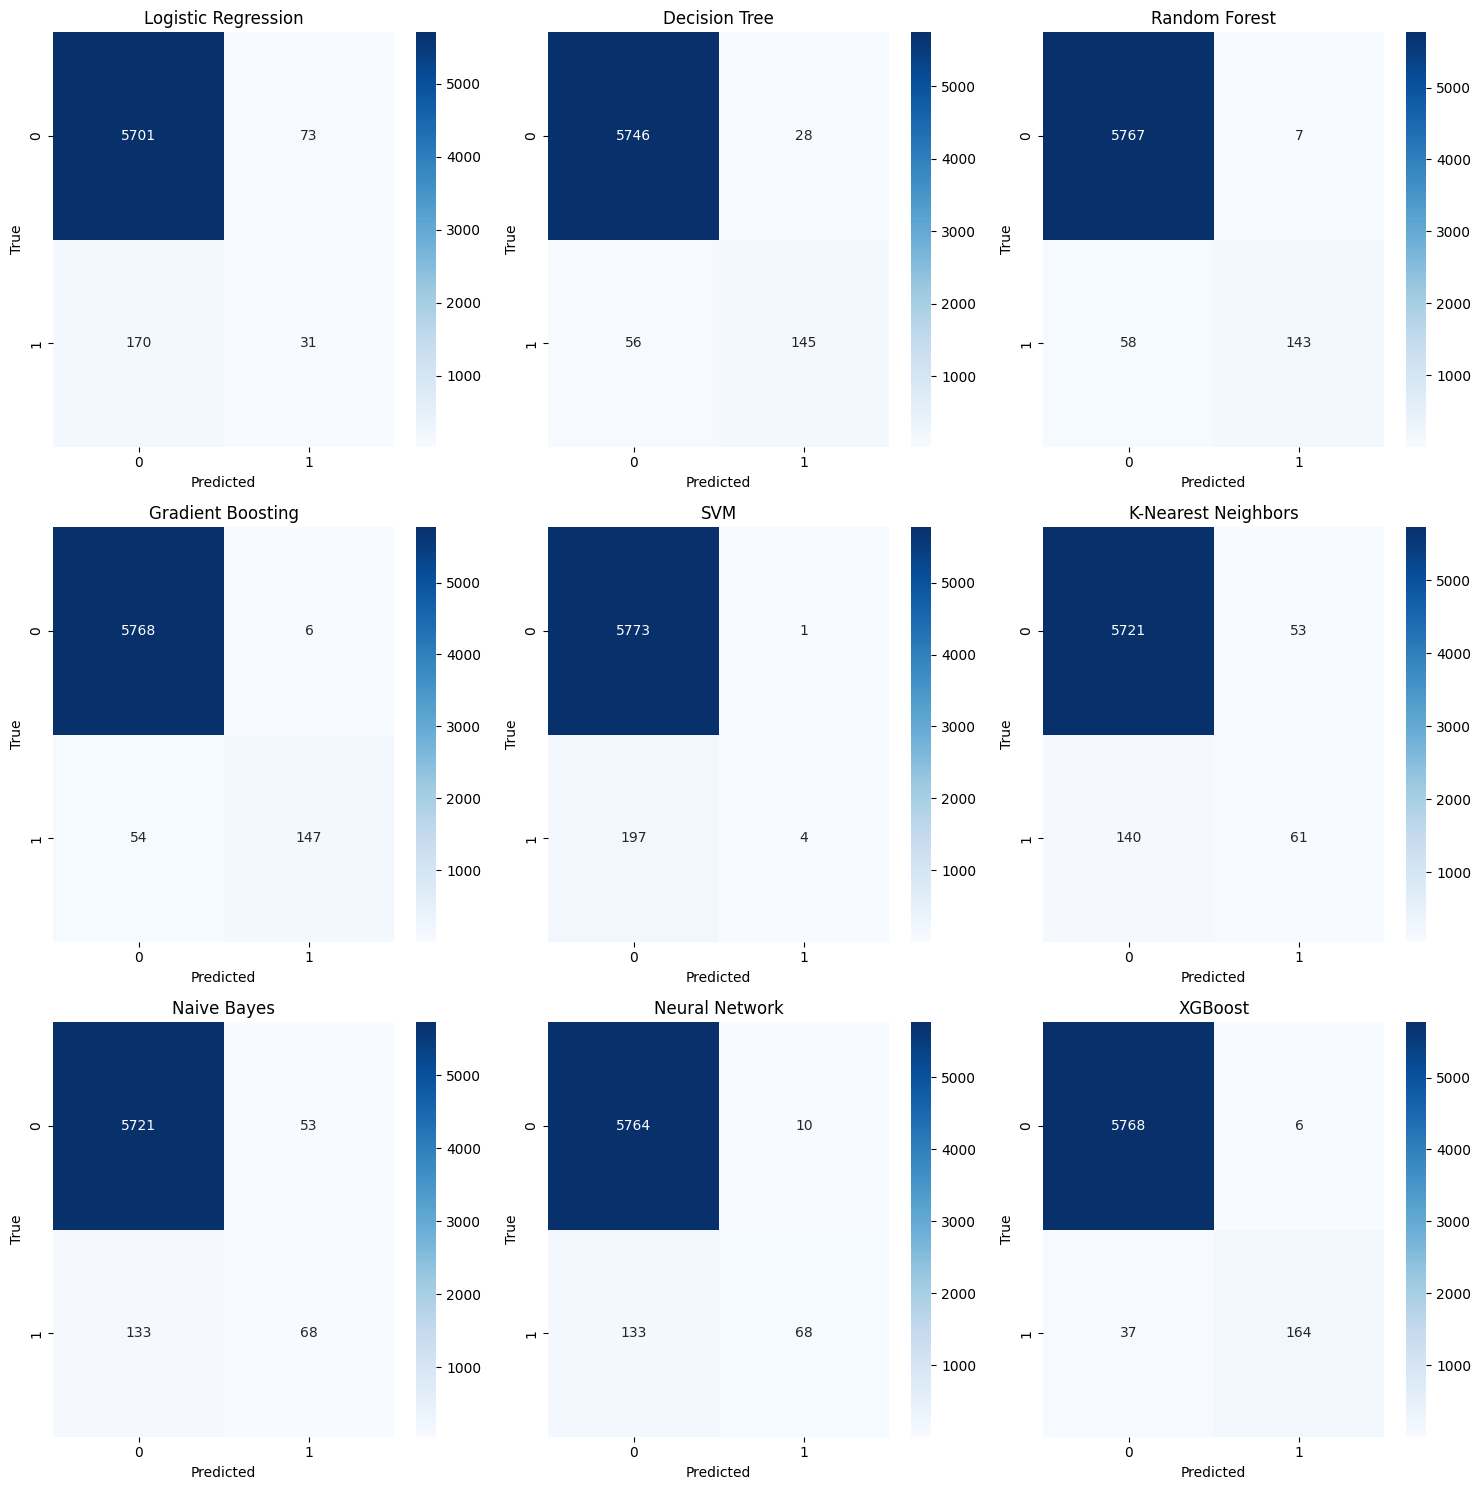

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-86-3b3310bf24d3>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes['sum'] = votes.sum(axis=1)
<ipython-input-86-3b3310bf24d3>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


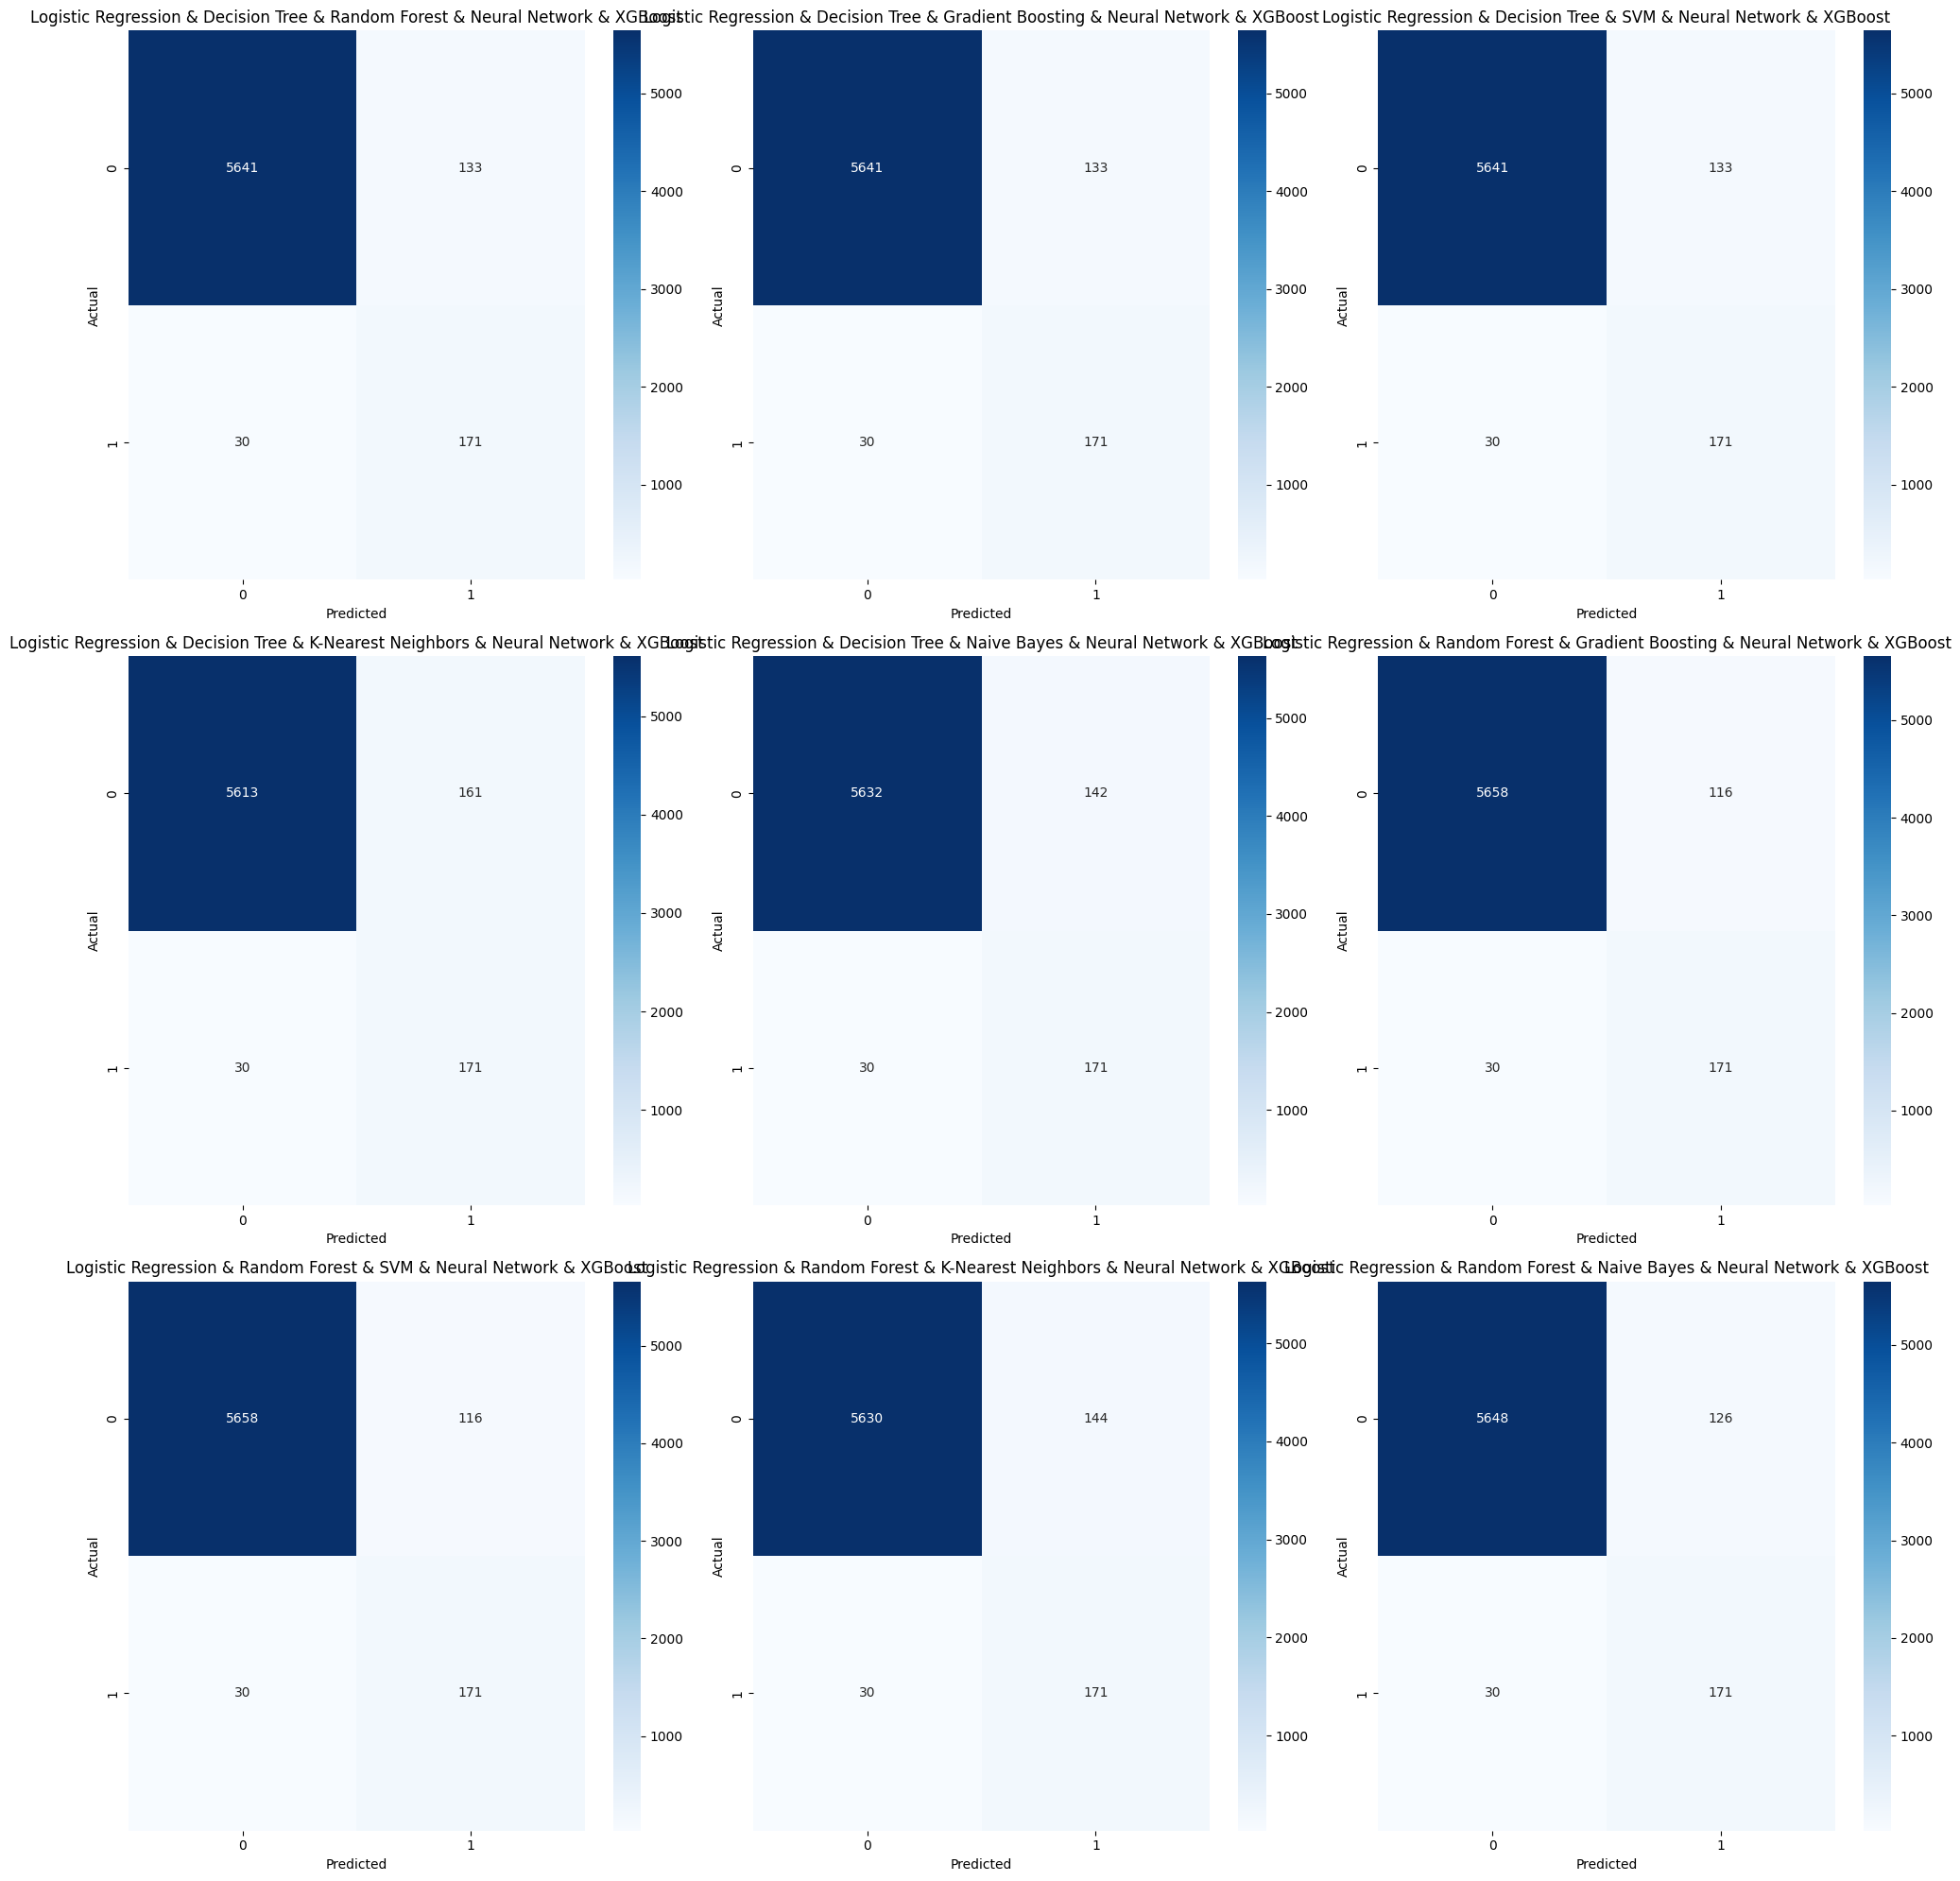

In [ ]:
######################### Year 5-10 ########################

X = XY_5_10.iloc[:,2:-2]

y = XY_5_10.iloc[:,-1]

# Separate the data based on y
X_y1 = X[y == 1]
y_y1 = y[y == 1]
X_y0 = X[y == 0]
y_y0 = y[y == 0]

# Split each subset into training and testing sets with a ratio of 6:4
X_y1_train, X_y1_test, y_y1_train, y_y1_test = train_test_split(X_y1, y_y1, test_size=0.4, random_state=42)
X_y0_train, X_y0_test, y_y0_train, y_y0_test = train_test_split(X_y0, y_y0, test_size=0.4, random_state=42)

# Combine the training sets and testing sets from both subsets
X_train = pd.concat([X_y1_train, X_y0_train])
y_train = pd.concat([y_y1_train, y_y0_train])
X_test = pd.concat([X_y1_test, X_y0_test])
y_test = pd.concat([y_y1_test, y_y0_test])

# Shuffle the combined training and testing sets
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Reindex the shuffled sets
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Now X_train, X_test, y_train, and y_test are ready for use
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree:\n", classification_report(y_test, y_pred_dt))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting:\n", classification_report(y_test, y_pred_gb))

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine:\n", classification_report(y_test, y_pred_svm))

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("K-Nearest Neighbors:\n", classification_report(y_test, y_pred_knn))

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))

# Neural Network
nn = MLPClassifier()
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
print("Neural Network:\n", classification_report(y_test, y_pred_nn))

# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(),
    "XGBoost": XGBClassifier()
}

# Train and predict
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Plotting metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for idx, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    sns.barplot(x=list(models.keys()), y=values, ax=axs[idx])
    axs[idx].set_title(metric)
    axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Plotting confusion matrices
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for idx, model in enumerate(models):
    cm = results[model]["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(model)
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('True')

plt.tight_layout()
plt.show()




import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and predict
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# Create DataFrame of predictions
pred_df = pd.DataFrame(predictions)

# Evaluate all possible juries of 4 models
combinations_list = list(combinations(models.keys(), 5))
results = []

for combo in combinations_list:
    votes = pred_df[list(combo)]
    votes['sum'] = votes.sum(axis=1)
    votes['final_prediction'] = votes['sum'].apply(lambda x: 1 if x >= 1 else 0)

    # Filter out 'do not score' predictions
    valid_votes = votes[votes['final_prediction'] != 'do not score']
    valid_indices = valid_votes.index
    actual_values = y_test.iloc[valid_indices]
    voted_predictions = valid_votes['final_prediction'].astype(int)  # Ensure binary targets

    # Calculate accuracy
    accuracy = accuracy_score(actual_values, voted_predictions)

    # Calculate true positives (TP)
    conf_matrix = confusion_matrix(actual_values, voted_predictions)
    true_positives = conf_matrix[1, 1]

    # Store the result
    results.append({
        'models': combo,
        'accuracy': accuracy,
        'valid_count': len(voted_predictions),
        'conf_matrix': conf_matrix,
        'true_positives': true_positives
    })

# Sort results by true positives in descending order and select top 9 combinations
results_sorted = sorted(results, key=lambda x: x['true_positives'], reverse=True)
top_9_results = results_sorted[:9]

# Plotting confusion matrices for the top 9 combinations
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.ravel()

for idx, result in enumerate(top_9_results):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(' & '.join(result['models']))
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()


Training set size: 8960
Test set size: 5975


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5774
           1       0.37      0.29      0.33       201

    accuracy                           0.96      5975
   macro avg       0.67      0.64      0.65      5975
weighted avg       0.96      0.96      0.96      5975

Decision Tree:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      5774
           1       0.95      0.80      0.87       201

    accuracy                           0.99      5975
   macro avg       0.97      0.90      0.93      5975
weighted avg       0.99      0.99      0.99      5975

Random Forest:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      5774
           1       0.99      0.78      0.87       201

    accuracy                           0.99      5975
   macro avg       0.99      0.89      0.94      5975
weighted avg       0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-91-e7522906633f>:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')
<ipython-input-91-e7522906633f>:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')
<ipython-input-91-e7522906633f>:131: UserWarning: FixedFormatter should only be used together with FixedL

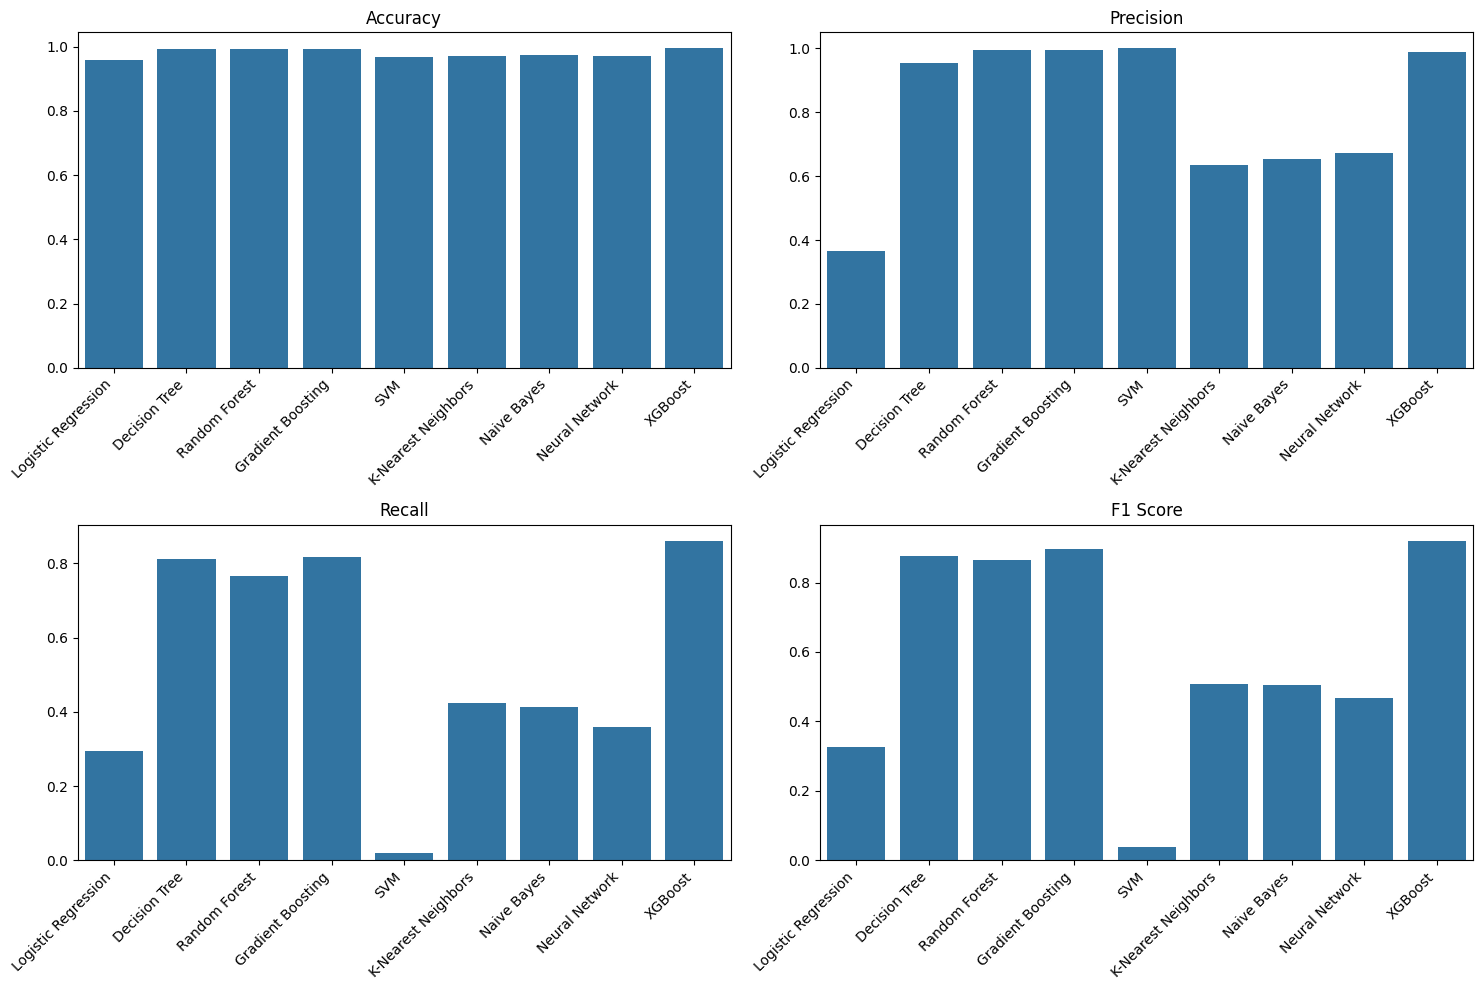

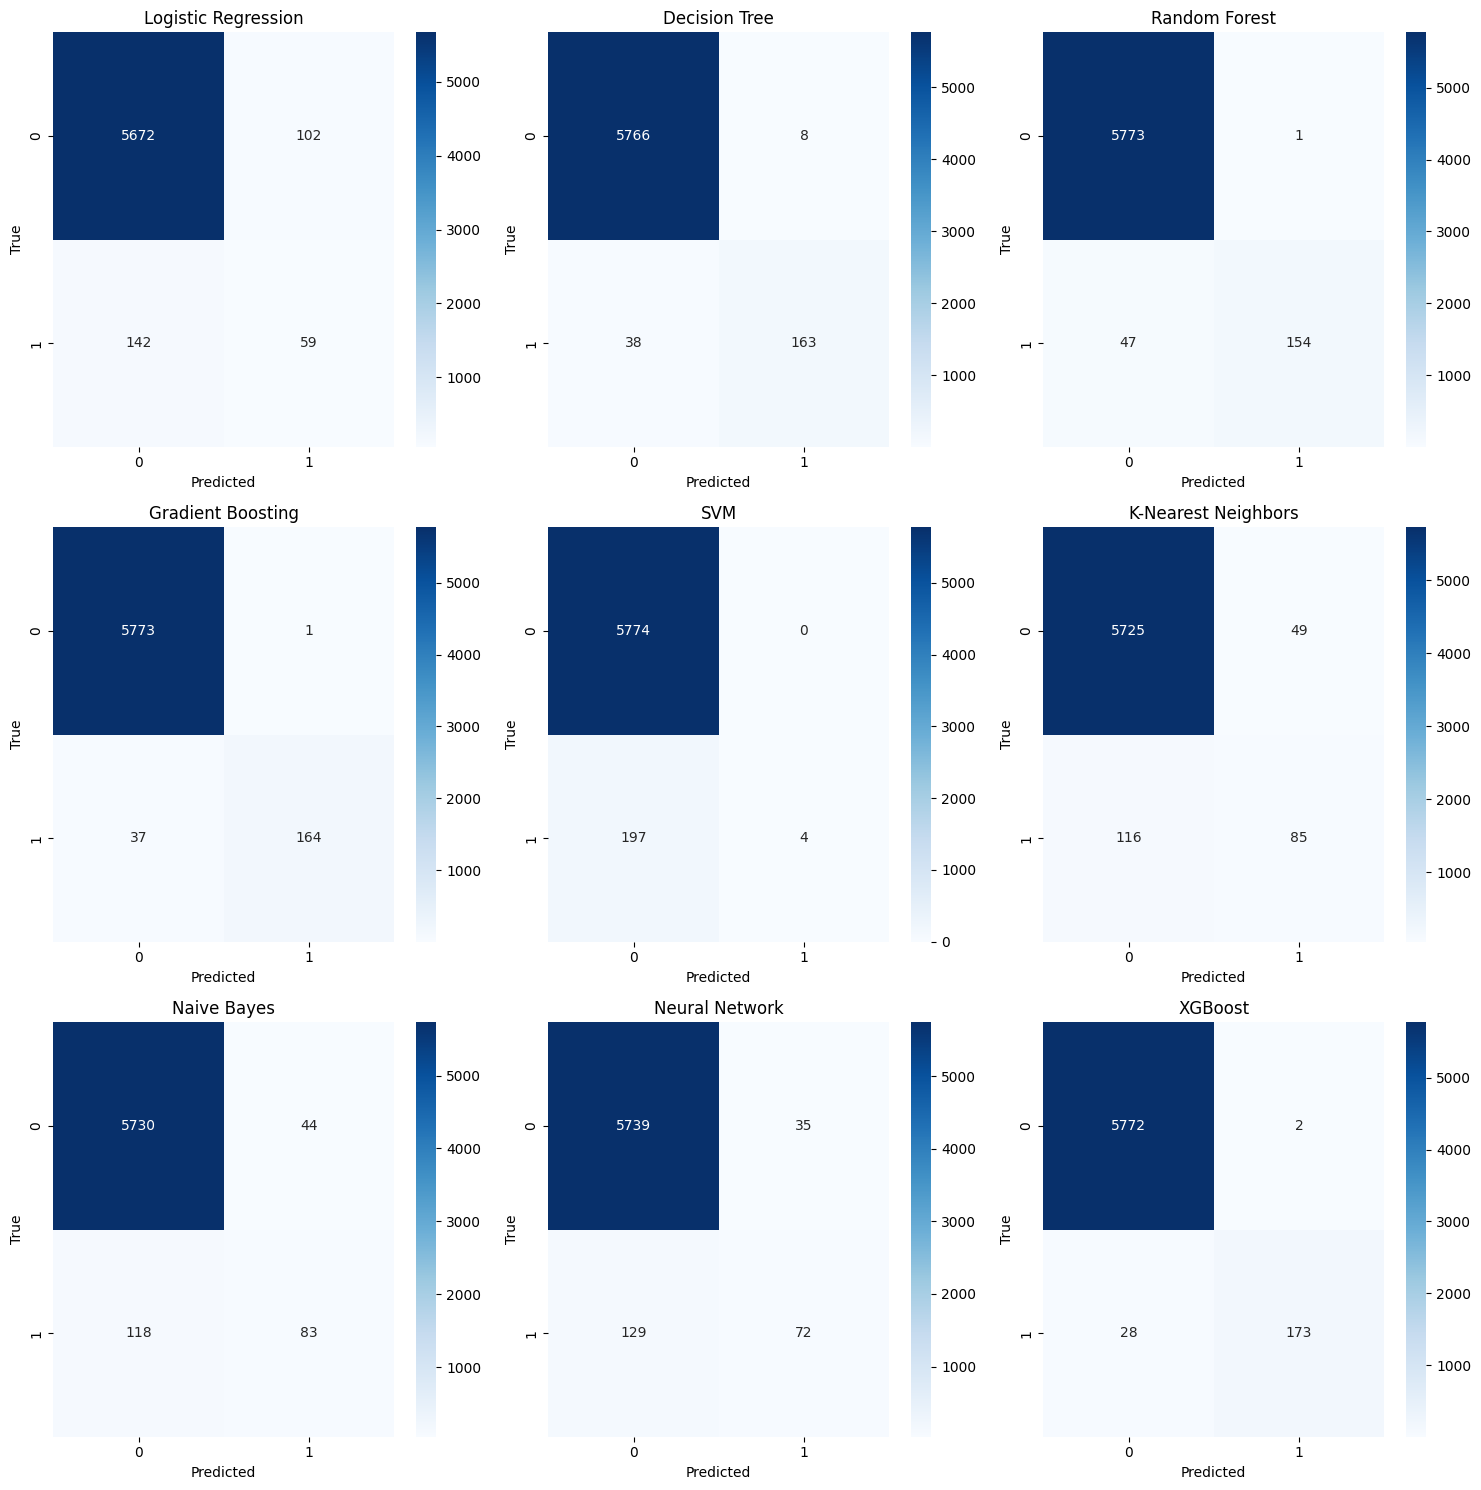

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-91-e7522906633f>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes['sum'] = votes.sum(axis=1)
<ipython-input-91-e7522906633f>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


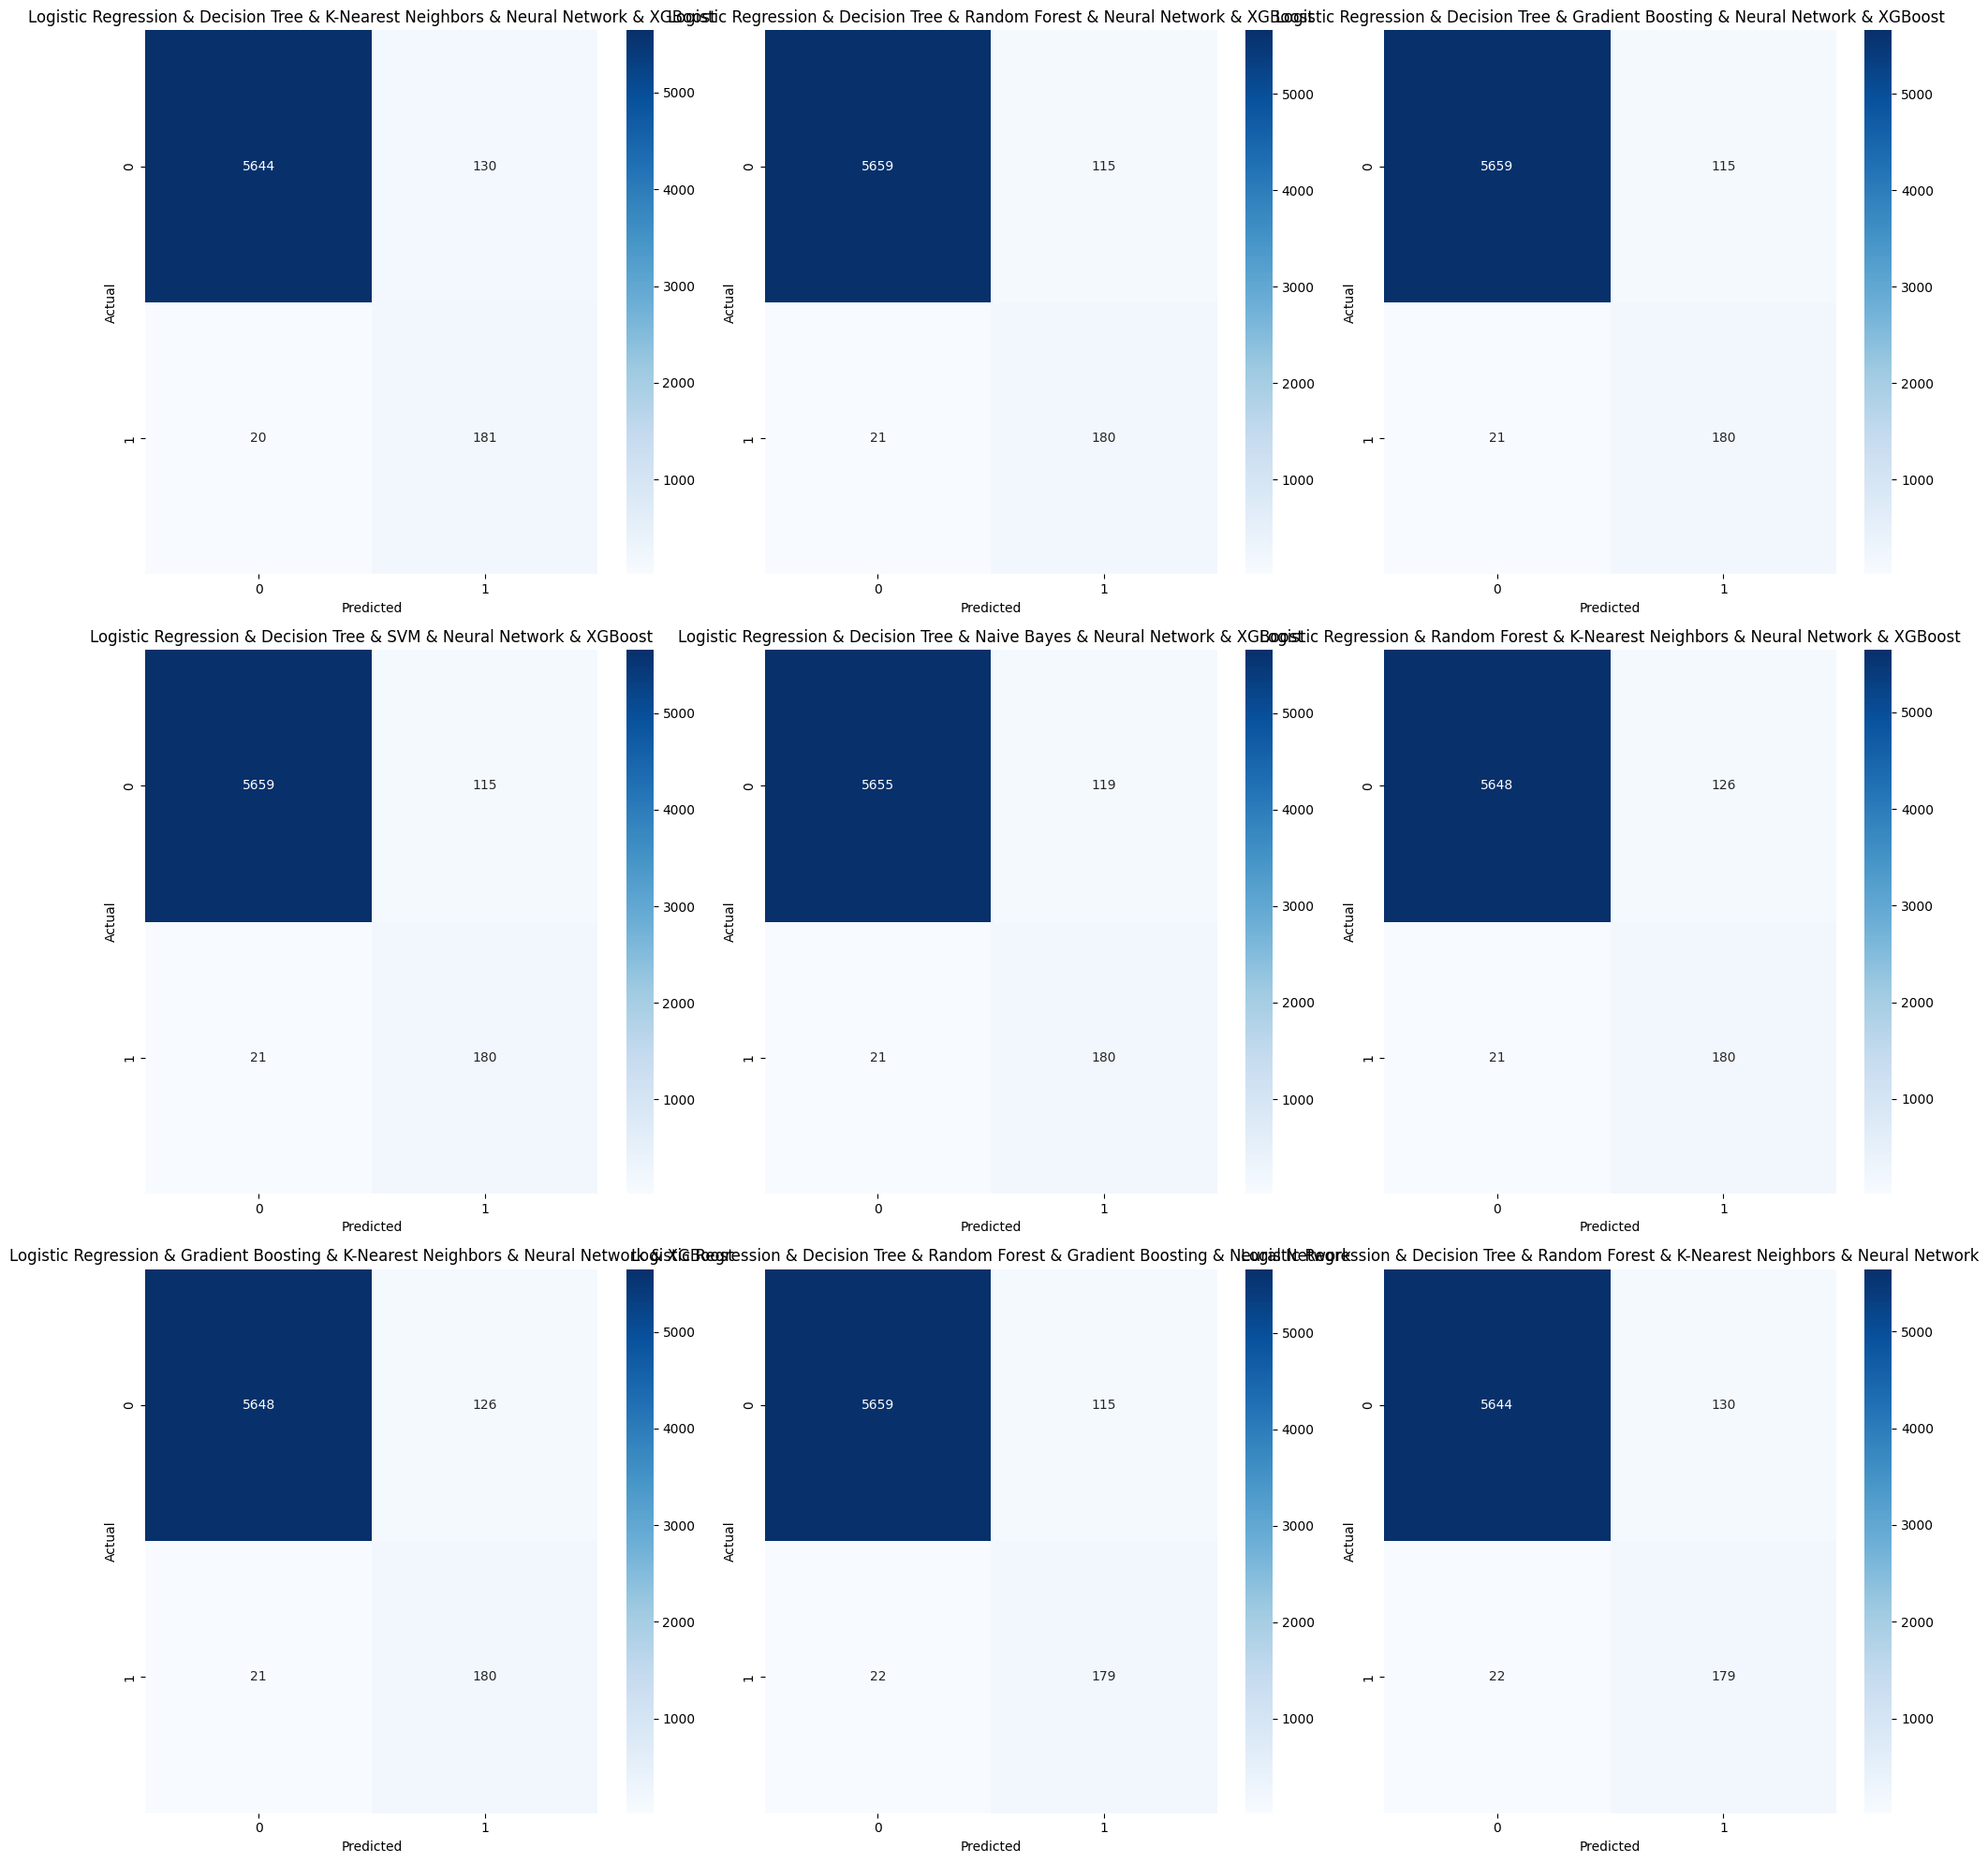

In [ ]:
######################### Year 10-15 ########################

X = XY_10_15.iloc[:,2:-2]

y = XY_10_15.iloc[:,-1]

# Separate the data based on y
X_y1 = X[y == 1]
y_y1 = y[y == 1]
X_y0 = X[y == 0]
y_y0 = y[y == 0]

# Split each subset into training and testing sets with a ratio of 6:4
X_y1_train, X_y1_test, y_y1_train, y_y1_test = train_test_split(X_y1, y_y1, test_size=0.4, random_state=42)
X_y0_train, X_y0_test, y_y0_train, y_y0_test = train_test_split(X_y0, y_y0, test_size=0.4, random_state=42)

# Combine the training sets and testing sets from both subsets
X_train = pd.concat([X_y1_train, X_y0_train])
y_train = pd.concat([y_y1_train, y_y0_train])
X_test = pd.concat([X_y1_test, X_y0_test])
y_test = pd.concat([y_y1_test, y_y0_test])

# Shuffle the combined training and testing sets
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Reindex the shuffled sets
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Now X_train, X_test, y_train, and y_test are ready for use
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree:\n", classification_report(y_test, y_pred_dt))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting:\n", classification_report(y_test, y_pred_gb))

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine:\n", classification_report(y_test, y_pred_svm))

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("K-Nearest Neighbors:\n", classification_report(y_test, y_pred_knn))

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))

# Neural Network
nn = MLPClassifier()
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
print("Neural Network:\n", classification_report(y_test, y_pred_nn))

# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(),
    "XGBoost": XGBClassifier()
}

# Train and predict
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Plotting metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for idx, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    sns.barplot(x=list(models.keys()), y=values, ax=axs[idx])
    axs[idx].set_title(metric)
    axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Plotting confusion matrices
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for idx, model in enumerate(models):
    cm = results[model]["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(model)
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('True')

plt.tight_layout()
plt.show()




import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and predict
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# Create DataFrame of predictions
pred_df = pd.DataFrame(predictions)

# Evaluate all possible juries of 4 models
combinations_list = list(combinations(models.keys(), 5))
results = []

for combo in combinations_list:
    votes = pred_df[list(combo)]
    votes['sum'] = votes.sum(axis=1)
    votes['final_prediction'] = votes['sum'].apply(lambda x: 1 if x >= 1 else 0)

    # Filter out 'do not score' predictions
    valid_votes = votes[votes['final_prediction'] != 'do not score']
    valid_indices = valid_votes.index
    actual_values = y_test.iloc[valid_indices]
    voted_predictions = valid_votes['final_prediction'].astype(int)  # Ensure binary targets

    # Calculate accuracy
    accuracy = accuracy_score(actual_values, voted_predictions)

    # Calculate true positives (TP)
    conf_matrix = confusion_matrix(actual_values, voted_predictions)
    true_positives = conf_matrix[1, 1]

    # Store the result
    results.append({
        'models': combo,
        'accuracy': accuracy,
        'valid_count': len(voted_predictions),
        'conf_matrix': conf_matrix,
        'true_positives': true_positives,
        'actual_values': actual_values,
        'voted_predictions': voted_predictions,
        'valid_indices': valid_indices
    })

# Sort results by true positives in descending order and select top 9 combinations
results_sorted = sorted(results, key=lambda x: x['true_positives'], reverse=True)
top_9_results = results_sorted[:9]

# Plotting confusion matrices for the top 9 combinations
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.ravel()

for idx, result in enumerate(top_9_results):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_title(' & '.join(result['models']))
    axs[idx].set_xlabel('Predicted')
    axs[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [ ]:
# Select the best combination based on accuracy or another criterion
best_result = max(results, key=lambda x: x['accuracy'])

# Extract true positives, false positives, and false negatives
actual_values = best_result['actual_values']
voted_predictions = best_result['voted_predictions']
valid_indices = best_result['valid_indices']

X_test_valid = X_test.iloc[valid_indices]
X_test_valid['actual'] = actual_values.values
X_test_valid['predicted'] = voted_predictions.values

true_positives = X_test_valid[(X_test_valid['actual'] == 1) & (X_test_valid['predicted'] == 1)]
false_positives = X_test_valid[(X_test_valid['actual'] == 0) & (X_test_valid['predicted'] == 1)]
false_negatives = X_test_valid[(X_test_valid['actual'] == 1) & (X_test_valid['predicted'] == 0)]

# Save to CSV files
true_positives.to_csv('/content/drive/MyDrive/portal_innovation/code/true_positives.csv', index=False)
false_positives.to_csv('/content/drive/MyDrive/portal_innovation/code/false_positives.csv', index=False)
false_negatives.to_csv('/content/drive/MyDrive/portal_innovation/code/false_negatives.csv', index=False)